# Neural Networks for Machine Learning Project

## Part I: Convolutional neural networks for image analysis

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import numpy as np

2023-12-18 01:46:22.233698: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 01:46:22.257985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 01:46:22.258012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 01:46:22.258677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 01:46:22.263418: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Image preprocessing function
# Could switch to lambda instead but labels in loader make it hard to do
def preprocess(image, label):
    # Swap to BGR format with zero-centering
    image = keras.applications.resnet50.preprocess_input(image)
    return image, label

# Create 10 new cropped images from given image
# Gets center, each corner, and a flip of each
def tenCrop(image):
    # Cropping offset
    offset = 8
    crop = []
    newImage = tf.image.resize(image, (40, 40))

    topLeft = tf.image.resize(tf.image.crop_to_bounding_box(newImage, 0, 0, 32 - offset, 32 - offset), (32, 32))
    crop.append(topLeft)
    crop.append(tf.image.flip_left_right(topLeft))

    botLeft = tf.image.resize(tf.image.crop_to_bounding_box(newImage, offset, 0, 32 - offset, 32 - offset), (32, 32))
    crop.append(botLeft)
    crop.append(tf.image.flip_left_right(botLeft))

    topRight = tf.image.resize(tf.image.crop_to_bounding_box(newImage, 0, offset, 32, 32), (32, 32))
    crop.append(topRight)
    crop.append(tf.image.flip_left_right(topRight))

    botRight = tf.image.resize(tf.image.crop_to_bounding_box(newImage, offset, offset, 32, 32), (32, 32))
    crop.append(botRight)
    crop.append(tf.image.flip_left_right(botRight))

    center = tf.image.resize(tf.image.crop_to_bounding_box(newImage, offset, offset, 32 - offset, 32 - offset), (32, 32))
    crop.append(center)
    crop.append(tf.image.flip_left_right(center))

    return tf.cast(crop, tf.uint8)

# Repeats given label 10 times
# Companion function to tenCrop
def tenRepeat(label):
    return tf.stack([label for i in range(10)])

# Import CIFAR-10 data set
(xTrain, yTrain), (xTest, yTest) = keras.datasets.cifar10.load_data()

# Split out 5k validation set from training set per paper
xTrain, xVal, yTrain, yVal = tts(xTrain, yTrain, test_size=0.1, random_state=42)

# Preprocess the data
# Convert labels to binary class matrix; should resolve tensor size issue
yTrain = keras.utils.to_categorical(yTrain, 10)
yVal = keras.utils.to_categorical(yVal, 10)
yTest = keras.utils.to_categorical(yTest, 10)

# Create dataset loader objects; should alleviate OOM errors
trainLoader = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
valLoader = tf.data.Dataset.from_tensor_slices((xVal, yVal))
testLoader = tf.data.Dataset.from_tensor_slices((xTest, yTest))

# Create 10-crops of both validation and test set
xValCropLoader = tf.data.Dataset.from_tensor_slices(xVal)
xValCropLoader = xValCropLoader.map(tenCrop).unbatch()
yValCropLoader = tf.data.Dataset.from_tensor_slices(yVal)
yValCropLoader = yValCropLoader.map(tenRepeat).unbatch()

xTestCropLoader = tf.data.Dataset.from_tensor_slices(xTest)
xTestCropLoader = xTestCropLoader.map(tenCrop).unbatch()
yTestCropLoader = tf.data.Dataset.from_tensor_slices(yTest)
yTestCropLoader = yTestCropLoader.map(tenRepeat).unbatch()

# Preprocess data and make batches
# Batch size 128 for CIFAR-10 per paper
batchSize = 128
trainLoader = trainLoader.map(preprocess).batch(batchSize)
valLoader = valLoader.map(preprocess).batch(batchSize)
testLoader = testLoader.map(preprocess).batch(batchSize)
valCropLoader = tf.data.Dataset.zip((xValCropLoader, yValCropLoader)).map(preprocess).batch(batchSize)
testCropLoader = tf.data.Dataset.zip((xTestCropLoader, yTestCropLoader)).map(preprocess).batch(batchSize)

2023-12-18 01:46:24.467942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 01:46:24.487585: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 01:46:24.487624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 01:46:24.491327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 01:46:24.491372: I external/local_xla/xla/stream_executor

In [3]:
# Train given model over CIFAR-10 data set
def trainModel(model, trainLoader, valLoader, testLoader, type):
    # Adjust layers for CIFAR-10
    # Input are 32x32x3 images
    inputs = model.input
    # Outputs are 10 classes over a softmax activiation
    outputs = keras.layers.Dense(10, activation='softmax')(model.output)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    # Compile model
    # Need to track training error, testing error, top-1 error, and top-5 error
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy, tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top-1 accuracy'), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top-5 accuracy')])

    # Train model
    print("-------------")
    print("Training model")
    print("-------------")
    print("\n")
    history = model.fit(trainLoader, epochs = 10, validation_data = valLoader)

    # Test model
    print("\n")
    print("-------------")
    print("Testing model")
    print("-------------")
    print("\n")
    
    print("On validation set:")
    loss, accuracy, top1, top5 = model.evaluate(valLoader)
    print("Loss:", loss)
    print("Accuracy:", accuracy)
    print("Top-1 accuracy:", top1)
    print("Top-5 accuracy:", top5)
    print("Top-1 error:", 1 - top1)
    print("Top-5 error:", 1 - top5)
    print("\n")

    print("On test set:")
    loss, accuracy, top1, top5 = model.evaluate(testLoader)
    print("Loss:", loss)
    print("Accuracy:", accuracy)
    print("Top-1 accuracy:", top1)
    print("Top-5 accuracy:", top5)
    print("Top-1 error:", 1 - top1)
    print("Top-5 error:", 1 - top5)
    print("\n")

    print("On 10-crop validation set:")
    loss, accuracy, top1, top5 = model.evaluate(valCropLoader)
    print("Loss:", loss)
    print("Accuracy:", accuracy)
    print("Top-1 accuracy:", top1)
    print("Top-5 accuracy:", top5)
    print("Top-1 error:", 1 - top1)
    print("Top-5 error:", 1 - top5)
    print("\n")

    print("On 10-crop Test set:")
    loss, accuracy, top1, top5 = model.evaluate(testCropLoader)
    print("Loss:", loss)
    print("Accuracy:", accuracy)
    print("Top-1 accuracy:", top1)
    print("Top-5 accuracy:", top5)
    print("Top-1 error:", 1 - top1)
    print("Top-5 error:", 1 - top5)
    print("=============")
    print("\n")

    print("-------------")
    print("Saving model")
    print("-------------")
    model.save("models/resnet/model{}".format(type))

    return history

In [4]:
# Import ResNet50 model
resNet50 = keras.applications.resnet50.ResNet50(include_top = False, weights = None, input_shape = (32, 32, 3), pooling = "avg")

# Train and test ResNet50 model
historyRN50 = trainModel(resNet50, trainLoader, valLoader, testLoader, 50)

-------------
Training model
-------------


Epoch 1/10


2023-12-18 01:46:30.907578: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-18 01:46:31.099029: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 01:46:31.538074: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 01:46:33.113723: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9739886b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 01:46:33.113762: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1702881993.139344  411446 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 [==============================] - 31s 51ms/step - loss: 2.3887 - categorical_accuracy: 0.2646 - top-1 accuracy: 0.2646 - top-5 accuracy: 0.7684 - val_loss: 1.9410 - val_categorical_accuracy: 0.3050 - val_top-1 accuracy: 0.3050 - val_top-5 accuracy: 0.8082
Epoch 2/10
352/352 [==============================] - 12s 34ms/step - loss: 1.8865 - categorical_accuracy: 0.3882 - top-1 accuracy: 0.3882 - top-5 accuracy: 0.8761 - val_loss: 2.0832 - val_categorical_accuracy: 0.3710 - val_top-1 accuracy: 0.3710 - val_top-5 accuracy: 0.8664
Epoch 3/10
352/352 [==============================] - 12s 34ms/step - loss: 1.6789 - categorical_accuracy: 0.4593 - top-1 accuracy: 0.4593 - top-5 accuracy: 0.9112 - val_loss: 2.2874 - val_categorical_accuracy: 0.3898 - val_top-1 accuracy: 0.3898 - val_top-5 accuracy: 0.8794
Epoch 4/10
352/352 [==============================] - 12s 34ms/step - loss: 1.4993 - categorical_accuracy: 0.5131 - top-1 accuracy: 0.5131 - top-5 accuracy: 0.9350 - val_loss: 2.5223 

INFO:tensorflow:Assets written to: models/resnet/model50/assets


In [5]:
# Import ResNet101 model
resNet101 = keras.applications.resnet.ResNet101(include_top = False, weights = None, input_shape = (32, 32, 3), pooling = "avg")

# Train and test ResNet101 model
historyRN101 = trainModel(resNet101, trainLoader, valLoader, testLoader, 101)

-------------
Training model
-------------


Epoch 1/10
352/352 [==============================] - 39s 63ms/step - loss: 2.4149 - categorical_accuracy: 0.2694 - top-1 accuracy: 0.2694 - top-5 accuracy: 0.7668 - val_loss: 2.1642 - val_categorical_accuracy: 0.2840 - val_top-1 accuracy: 0.2840 - val_top-5 accuracy: 0.7918
Epoch 2/10
352/352 [==============================] - 21s 60ms/step - loss: 1.9166 - categorical_accuracy: 0.3814 - top-1 accuracy: 0.3814 - top-5 accuracy: 0.8718 - val_loss: 2.4156 - val_categorical_accuracy: 0.3852 - val_top-1 accuracy: 0.3852 - val_top-5 accuracy: 0.8806
Epoch 3/10
352/352 [==============================] - 21s 60ms/step - loss: 1.7400 - categorical_accuracy: 0.4437 - top-1 accuracy: 0.4437 - top-5 accuracy: 0.9024 - val_loss: 2.5945 - val_categorical_accuracy: 0.4064 - val_top-1 accuracy: 0.4064 - val_top-5 accuracy: 0.8906
Epoch 4/10
352/352 [==============================] - 21s 61ms/step - loss: 1.6258 - categorical_accuracy: 0.4864 - top-1 accur

INFO:tensorflow:Assets written to: models/resnet/model101/assets


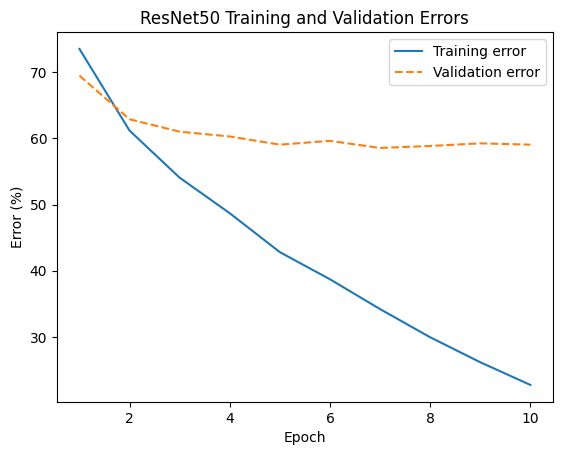

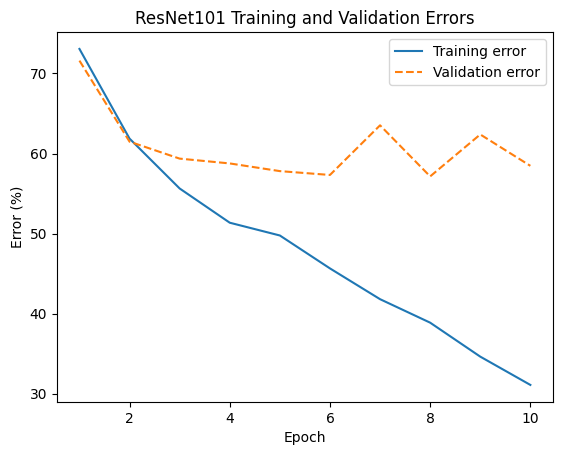

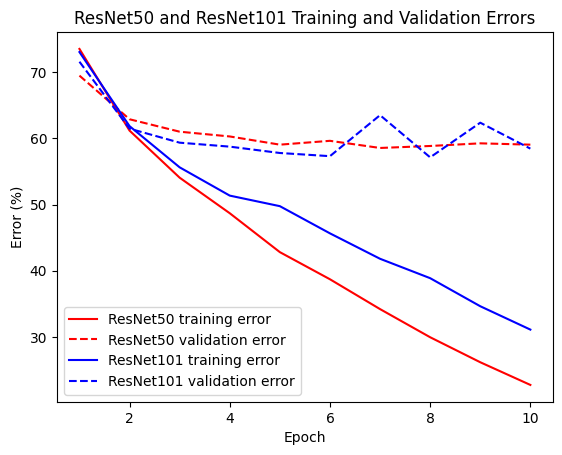

In [6]:
# Plot training and validation errors
plt.figure()
epochs = range(1, 11)
errorTrain50 = [(1 - i) * 100 for i in historyRN50.history['categorical_accuracy']]
errorVal50 = [(1 - i) * 100 for i in historyRN50.history['val_categorical_accuracy']]
plt.plot(np.array(epochs), np.array(errorTrain50), label = "Training error")
plt.plot(np.array(epochs), np.array(errorVal50), label = "Validation error", linestyle = 'dashed')
plt.title("ResNet50 Training and Validation Errors")
plt.xlabel("Epoch")
plt.ylabel("Error (%)")
plt.legend()
plt.show()
plt.figure()
errorTrain101 = [(1 - i) * 100 for i in historyRN101.history['categorical_accuracy']]
errorVal101 = [(1 - i) * 100 for i in historyRN101.history['val_categorical_accuracy']]
plt.plot(np.array(epochs), np.array(errorTrain101), label = "Training error")
plt.plot(np.array(epochs), np.array(errorVal101), label = "Validation error", linestyle = 'dashed')
plt.title("ResNet101 Training and Validation Errors")
plt.xlabel("Epoch")
plt.ylabel("Error (%)")
plt.legend()
plt.show()
plt.figure()
plt.plot(np.array(epochs), np.array(errorTrain50), label = "ResNet50 training error", color = "r")
plt.plot(np.array(epochs), np.array(errorVal50), label = "ResNet50 validation error", linestyle = 'dashed', color = "r")
plt.plot(np.array(epochs), np.array(errorTrain101), label = "ResNet101 training error", color = "b")
plt.plot(np.array(epochs), np.array(errorVal101), label = "ResNet101 validation error", linestyle = 'dashed', color = "b")
plt.title("ResNet50 and ResNet101 Training and Validation Errors")
plt.xlabel("Epoch")
plt.ylabel("Error (%)")
plt.legend()
plt.show()

## Part II: Transformers for text analysis

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences


In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 125s 155ms/step - loss: 0.3925 - accuracy: 0.8137 - val_loss: 0.2941 - val_accuracy: 0.8780
Epoch 2/2
782/782 [==============================] - 107s 136ms/step - loss: 0.1954 - accuracy: 0.9247 - val_loss: 0.3150 - val_accuracy: 0.8717


In [ ]:
model.save("./models/transformer/model")

In [ ]:
# Load saved model and report model details
model = keras.models.load_model("./models/transformer/model")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 32)           646400    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 200, 32)           10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [ ]:
# Evaluate classification capabilities of transformer model

# Test performance on IMDB data set
# Consider only validation set for testing
(xTemp, yTemp), (xIMDB, yIMDB) = keras.datasets.imdb.load_data(num_words=vocab_size)
dictIMDB = keras.datasets.imdb.get_word_index()

# Preprocessing mirroring training procedures
# Limit each text body to first 200 words observed
xIMDB = keras.utils.pad_sequences(xIMDB, maxlen=maxlen)

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
#=================
# HELPER FUNCTIONS
#=================

# Randomly pick some text observations from given data set
def selectTextBody(x, y, textBodyNum):
  index = np.random.choice(range(len(x)), textBodyNum, False)
  return np.array(x[index]), np.array(y[index])

# Reverse text dictionary create index -> word mapping
def reverseDict(textDict):
  return {value: key for key, value in textDict.items()}

# Use given text dictionary for data set to map back used word index to actual words
def translateWords(textBody, textDict):
  translated = []
  for textIdx in textBody:
    # Don't translate meaningless tokens
    if textIdx not in [0, 1, 2]:
      translated.append(textDict[textIdx])
  return " ".join(translated)

# Predict class of given data
def predictClass(model, x, y, textDict):
  prediction = model.predict(x)
  yPred = np.argmax(prediction, 1)

  # Report results
  print("\n")
  print("Transformer classifications over", len(x), "bodies of text")
  print("===================")
  # Report each test result
  for i in range(len(x)):
    print("Text body", i + 1)
    print("Text:", translateWords(x[i], textDict))
    print("Predicted class:", yPred[i])
    print("Actual class:", y[i])
    print("===================")

  # Give accuracy measure
  right = 0
  wrong = 0
  for i in range(len(y)):
    if yPred[i] == y[i]:
      right += 1
    else:
      wrong += 1
  print("Correctly predicted:", right)
  print("Incorrectly predicted:", wrong)
  print("Accuracy:", right / (right + wrong))
  print("Confusion matrix:")
  ConfusionMatrixDisplay(confusion_matrix(y, yPred)).plot()
  plt.show()

4/4 [==============================] - 0s 26ms/step


Transformer classifications over 100 bodies of text
Text body 1
Text: was two for sidney constantly it so shot on if by br of see characters for cult or good much extremely before there so friendship down for well look favorite this only middle of little it tunes that features man clearly comedy our so ticket their for against decided ago this now acting was two for seeing story use as on segment point horror in glad of definitely characters in at this for dust be turned kind time seasons to thing also of complexity for all fairly because characters for all there will this because before one will this of lopez not as on to additions had dust made most all it of watched being this give was mr for all stairs role of applying all fairly but be love what have pretty in can is him on have kids in season as by some to what have he is segment completely have into itself just as on
Predicted class: 1
Actual class: 1
Text body 2
Text: br of 

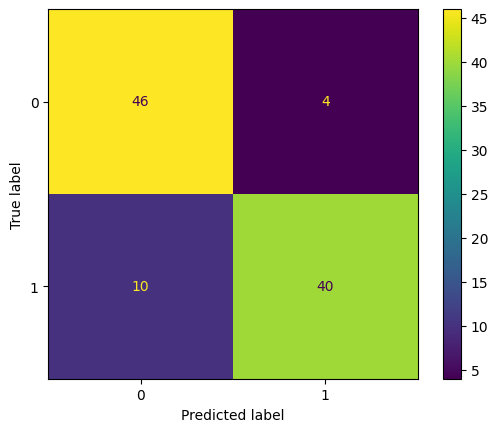

In [ ]:
# Amount of text bodies to pull from data set for testing
exampleCount = 100

# First select text bodies from IMDB set
xTestIMDB, yTestIMDB = selectTextBody(xIMDB, yIMDB, exampleCount)

# Perform class prediction on set
# Class 0 is negative review, class 1 is positive review
predictClass(model, xTestIMDB, yTestIMDB, reverseDict(dictIMDB))

## Part III: Variational autoencoder for image analysis

### Migrate from one framework to another framework

#### PyTorch Baseline

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 88410052.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80488833.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30060597.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15770305.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [7]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [8]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

====> Test set loss: 544.4362
====> Epoch: 1 Average loss: 191.1199
====> Test set loss: 137.1631
====> Epoch: 2 Average loss: 133.1344
====> Test set loss: 116.4844
====> Epoch: 3 Average loss: 121.1870
====> Test set loss: 109.1956
====> Epoch: 4 Average loss: 116.1144
====> Test set loss: 105.3817
====> Epoch: 5 Average loss: 113.3689
====> Test set loss: 103.7160
====> Epoch: 6 Average loss: 111.5341
====> Test set loss: 101.2456
====> Epoch: 7 Average loss: 110.2275
====> Test set loss: 100.3428
====> Epoch: 8 Average loss: 109.2900
====> Test set loss: 99.4350
====> Epoch: 9 Average loss: 108.4651
====> Test set loss: 98.1042
====> Epoch: 10 Average loss: 107.8432
====> Test set loss: 98.1437


<ipython-input-2-febedcb7ee00>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


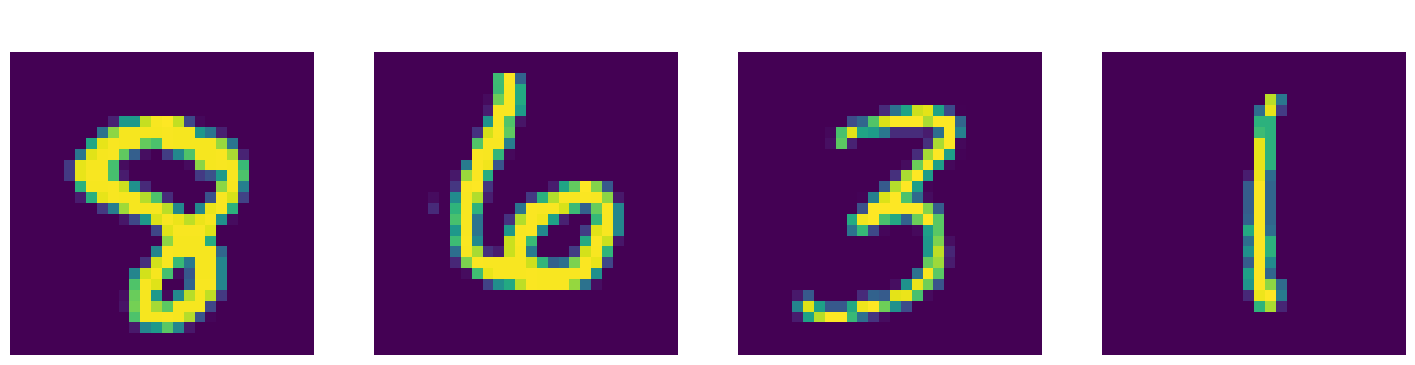

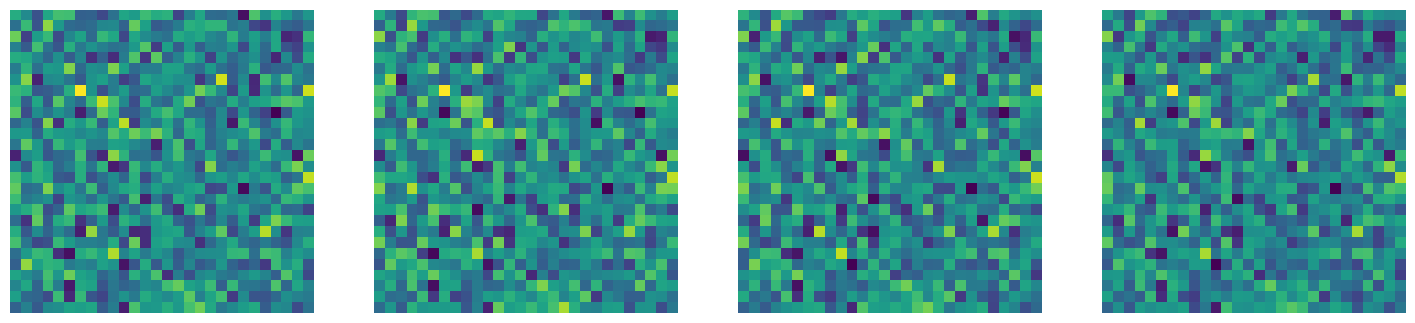

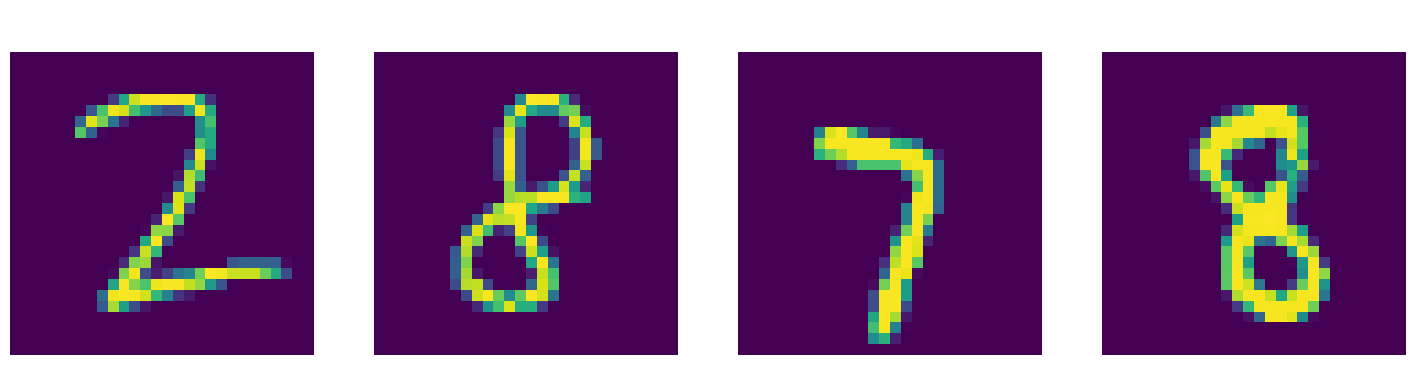

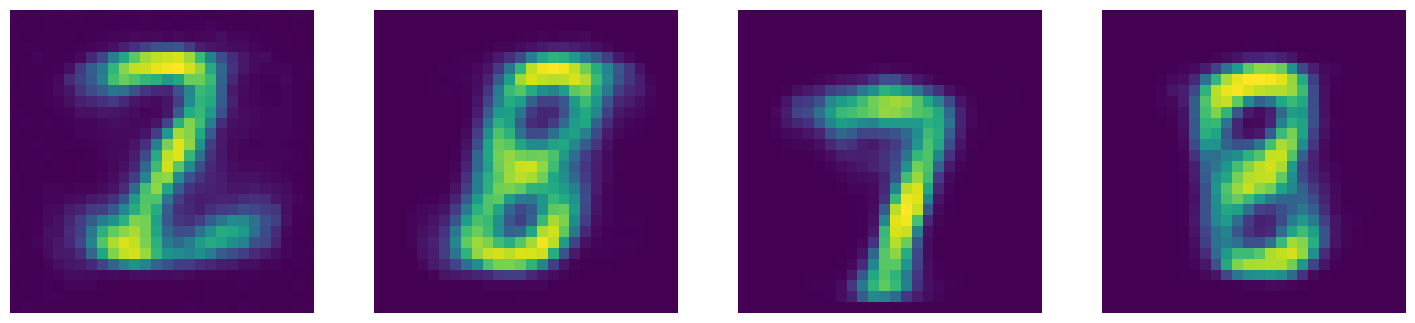

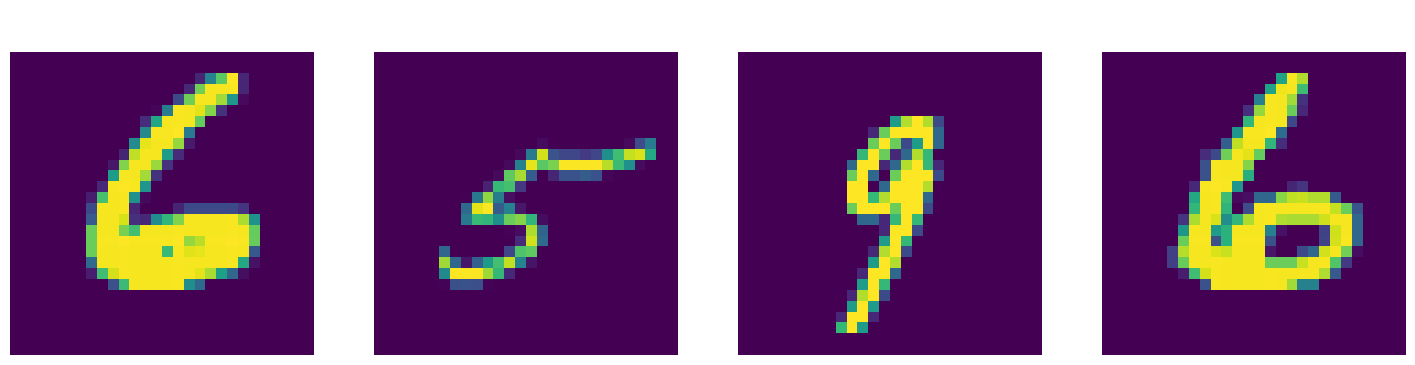

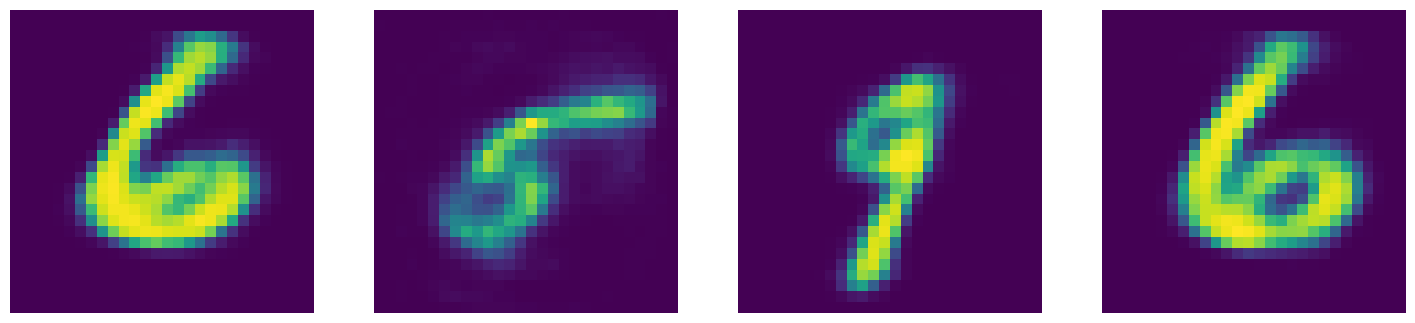

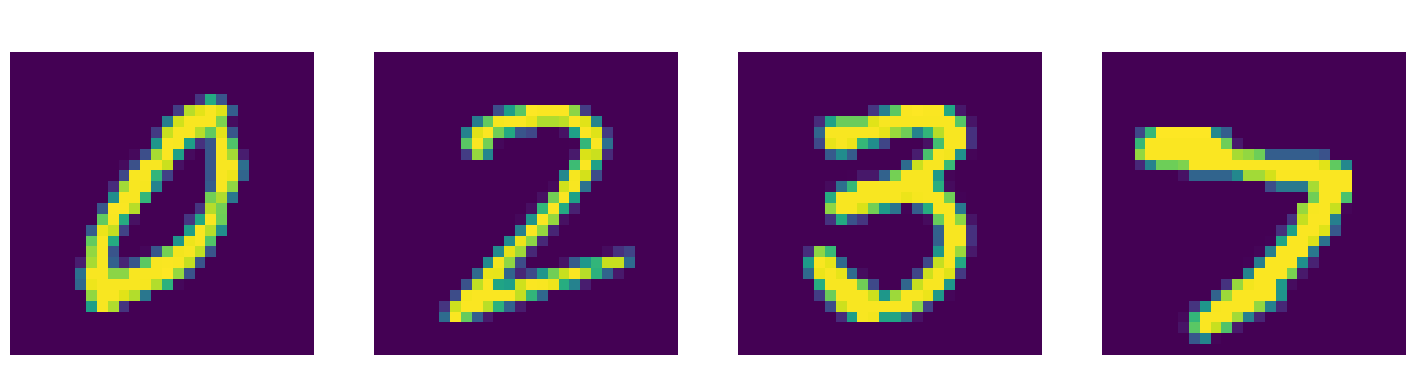

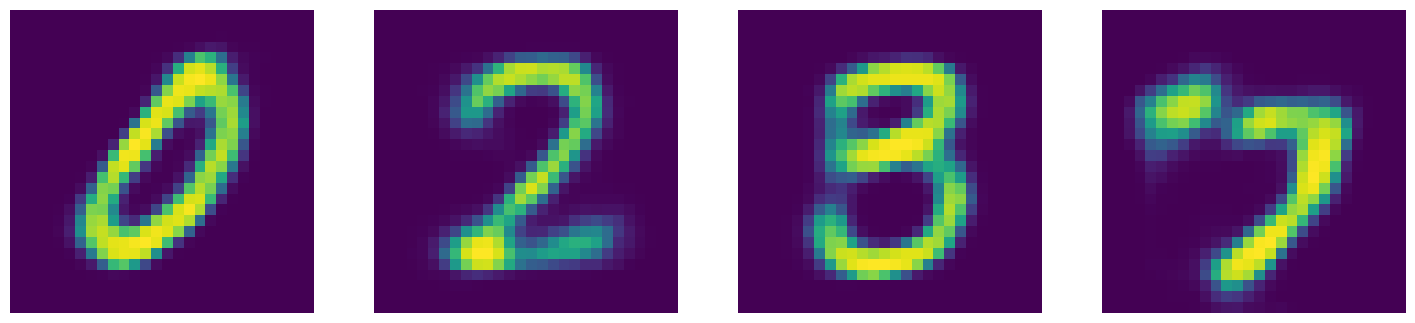

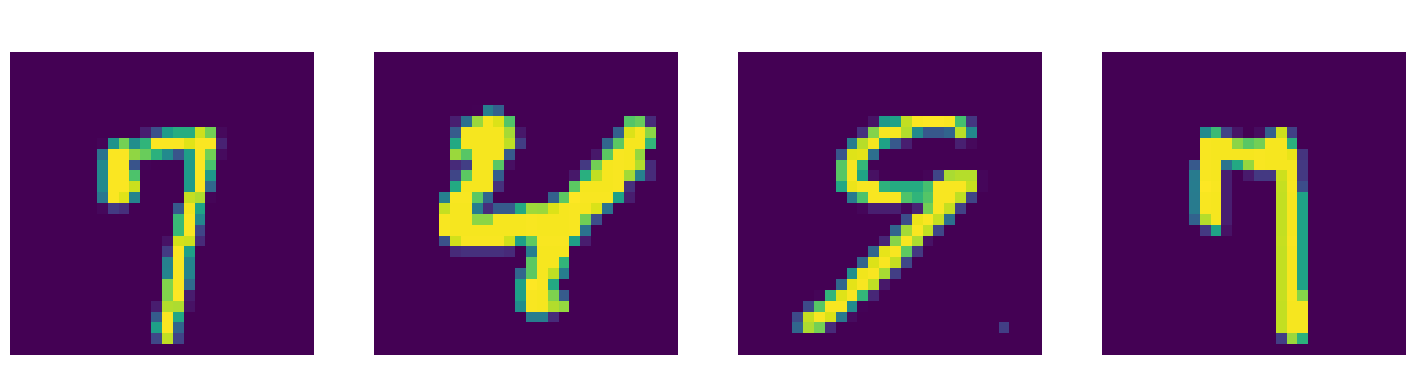

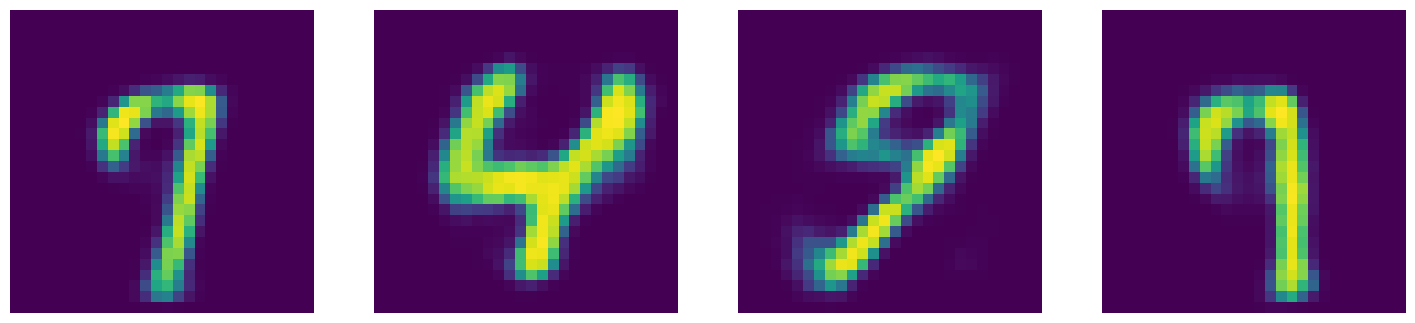

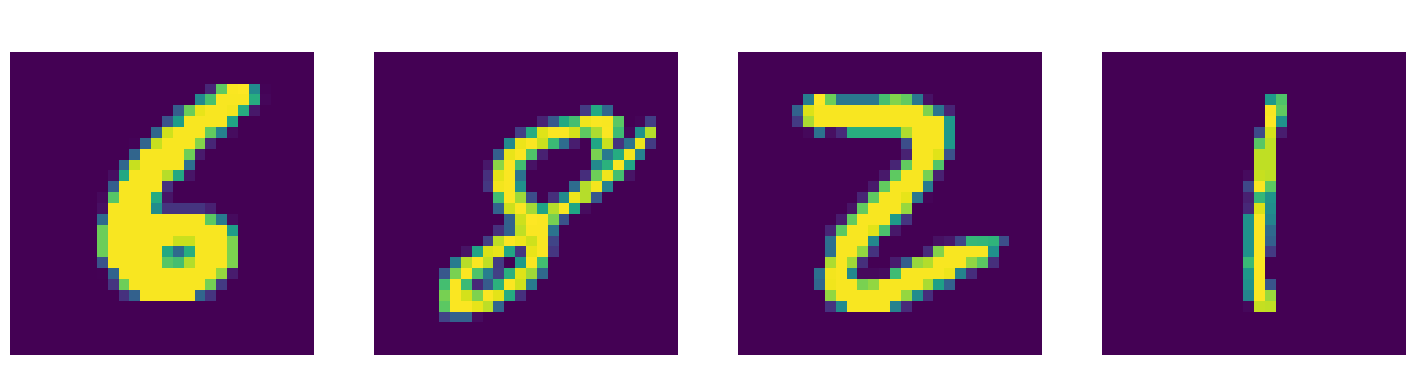

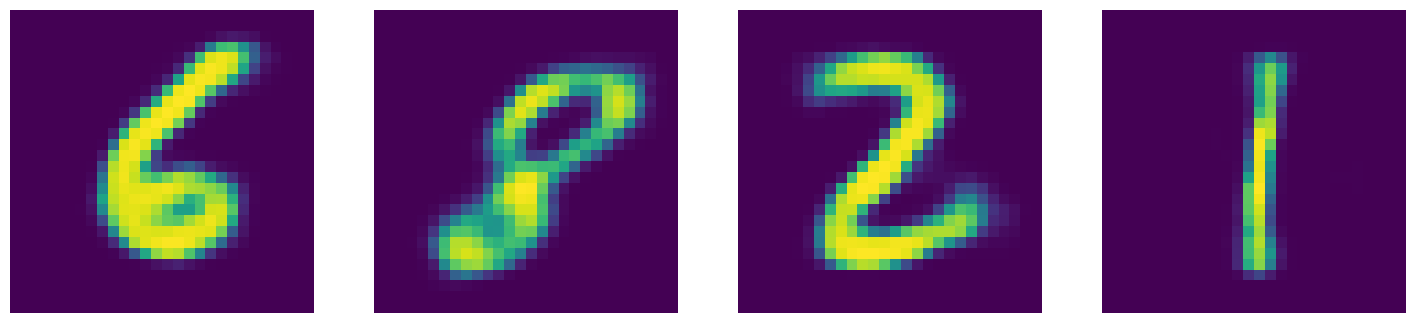

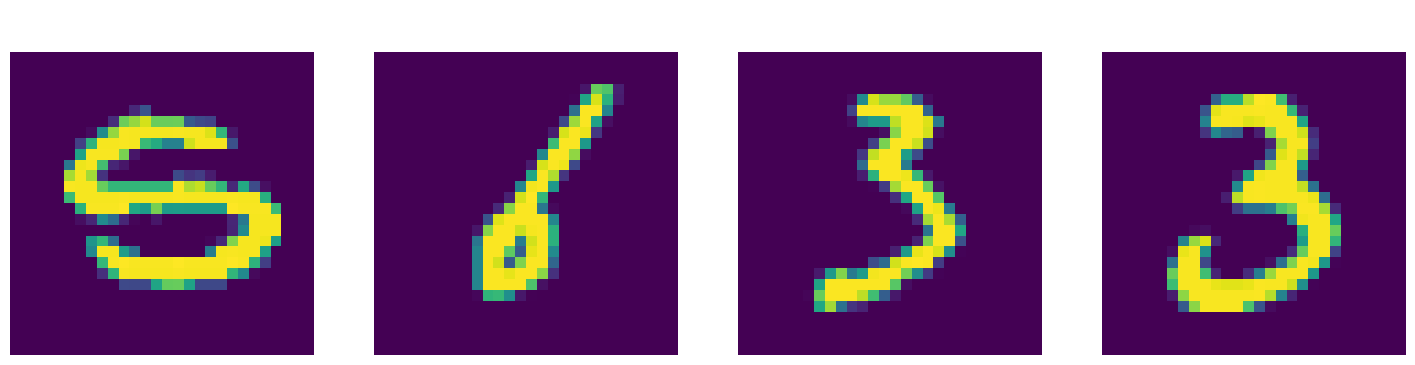

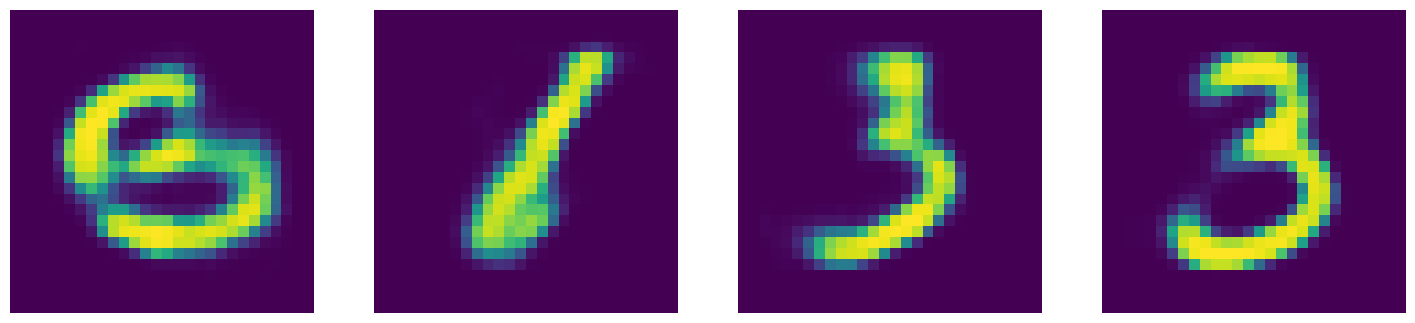

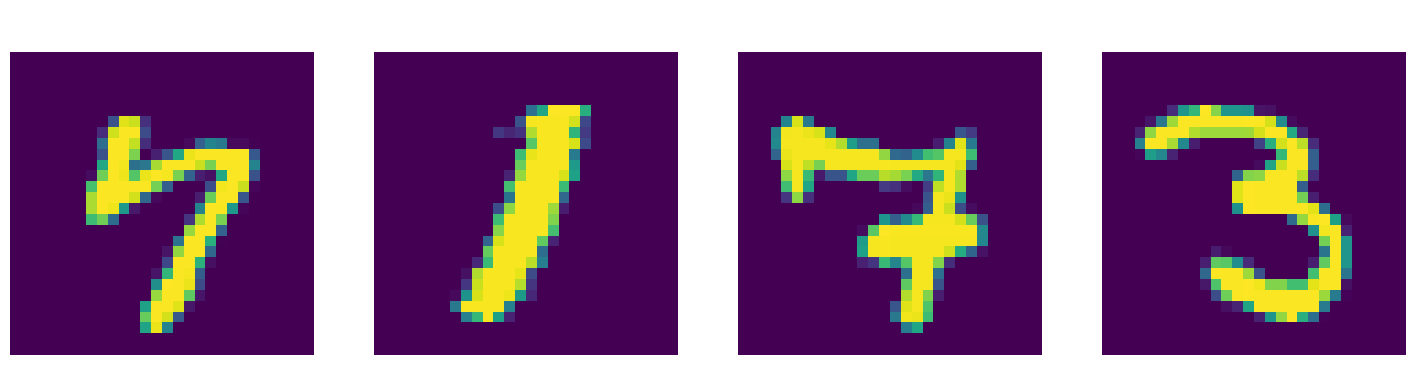

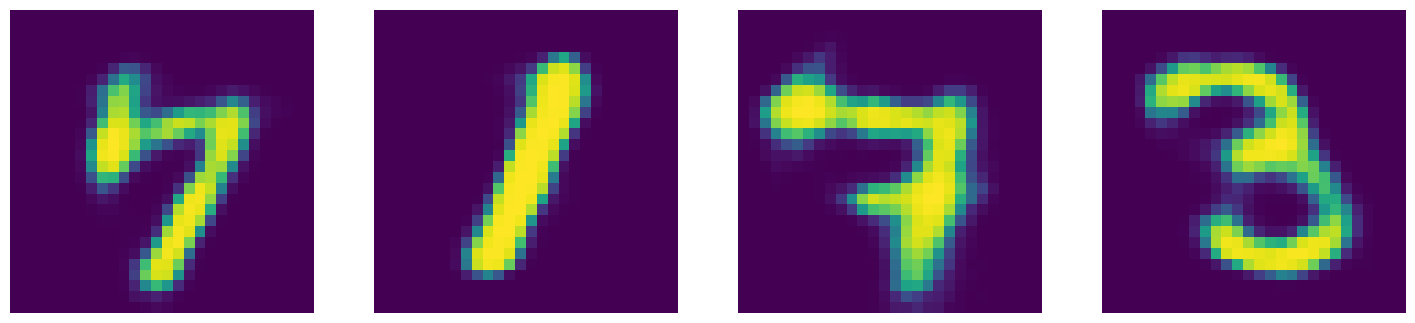

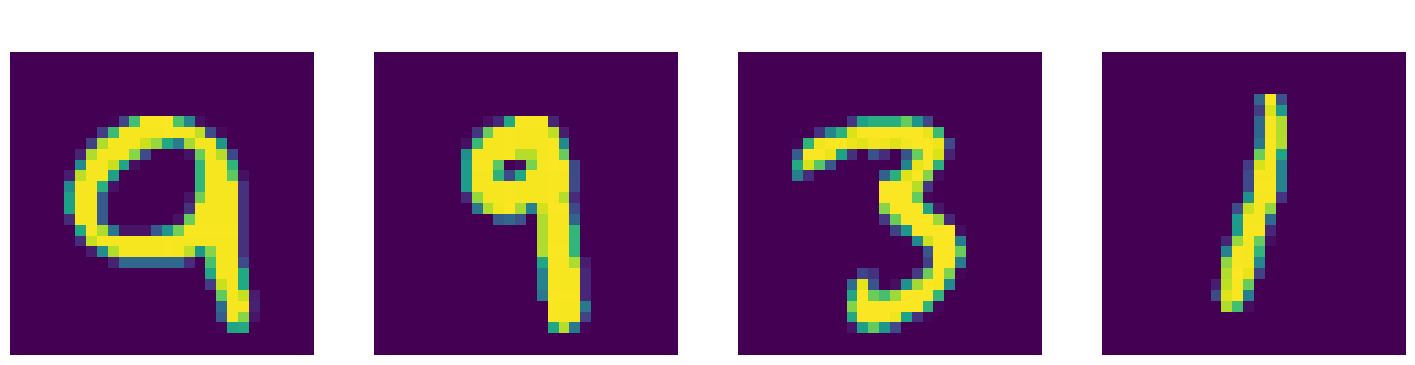

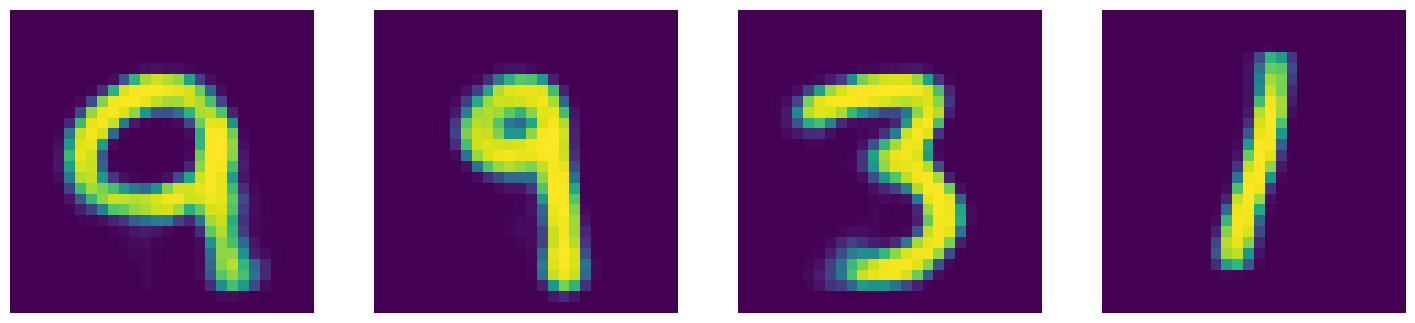

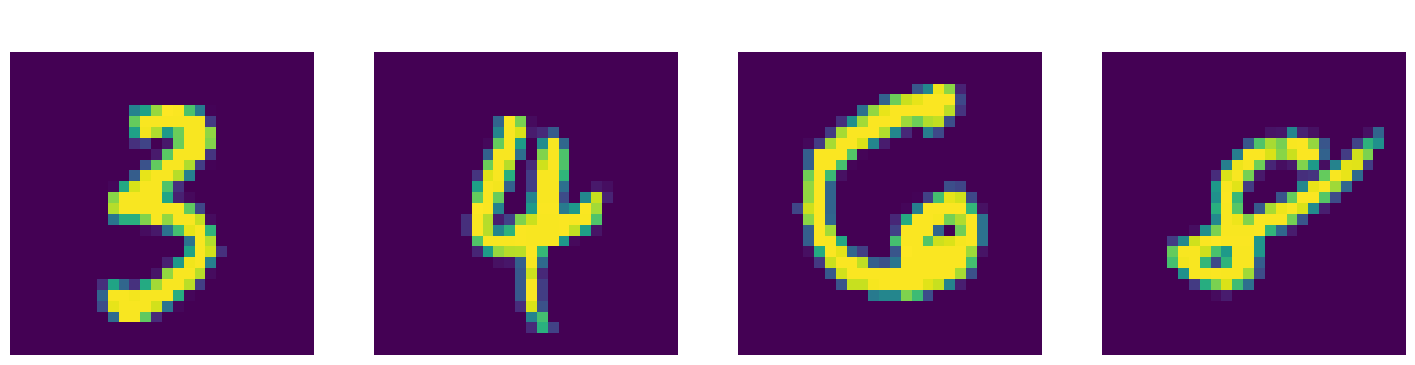

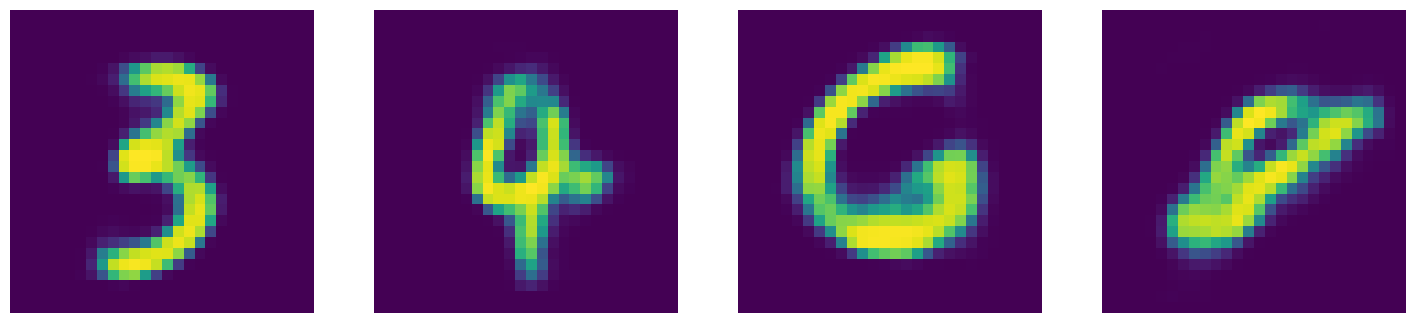

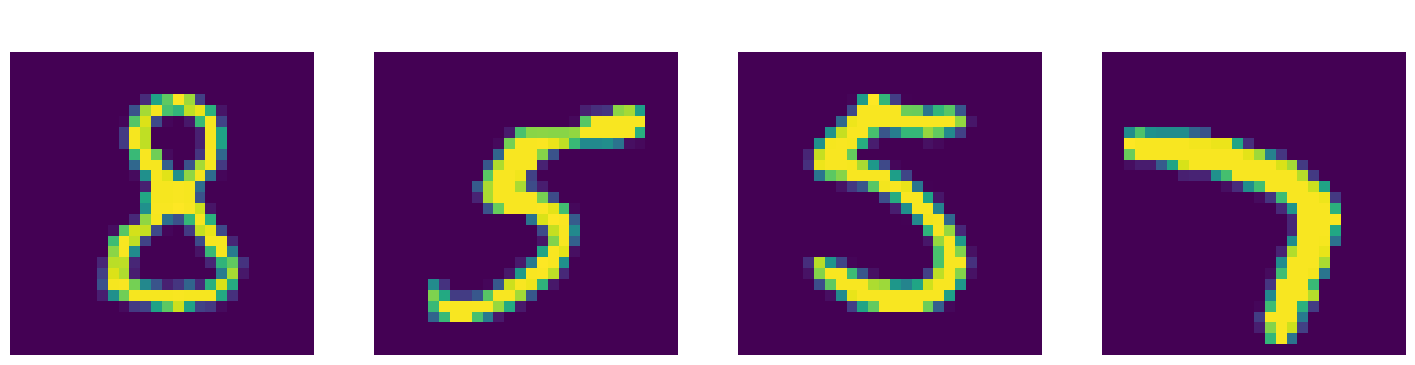

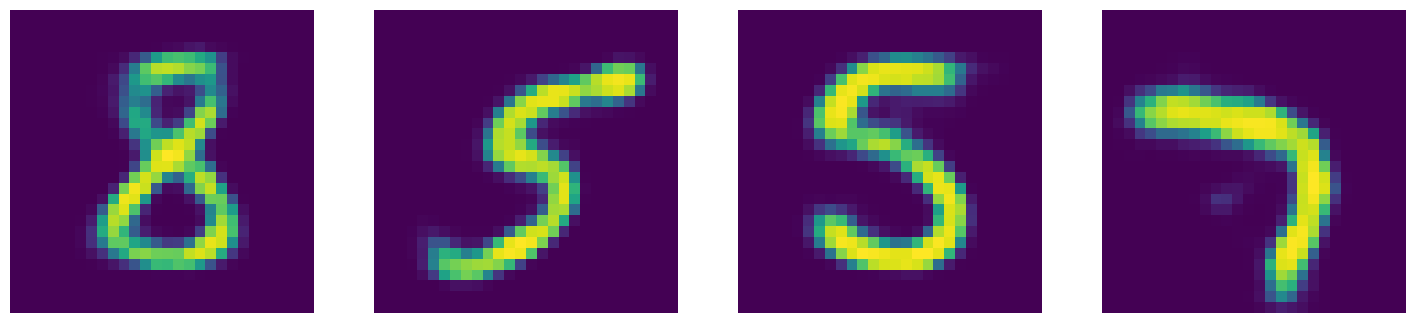

In [9]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # Testing

    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

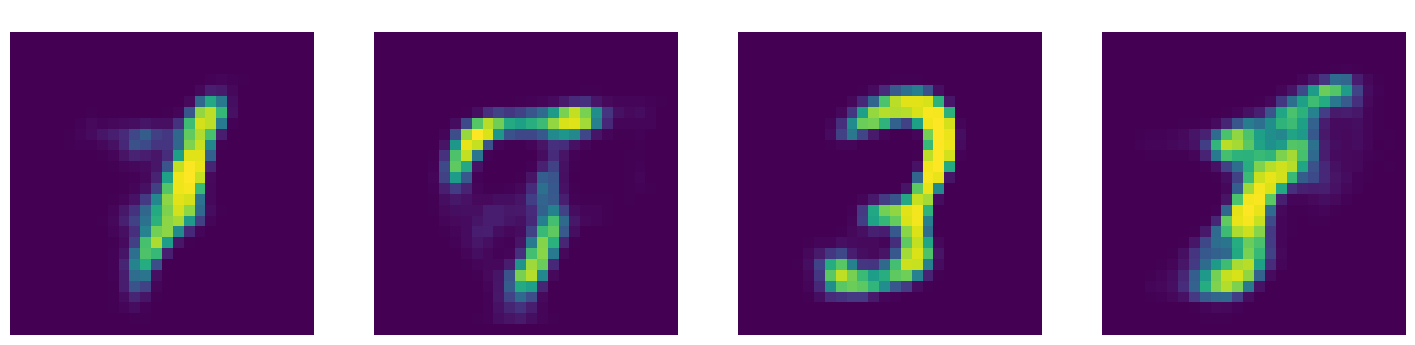

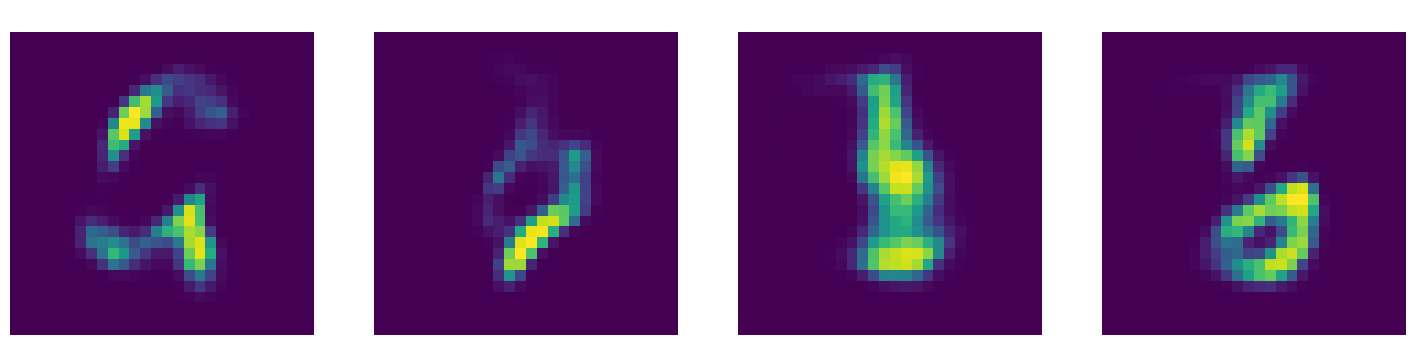

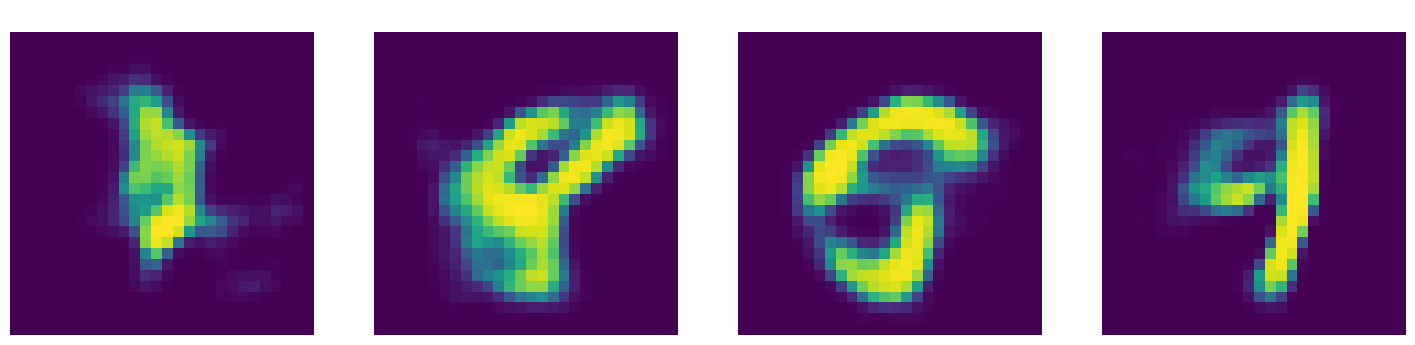

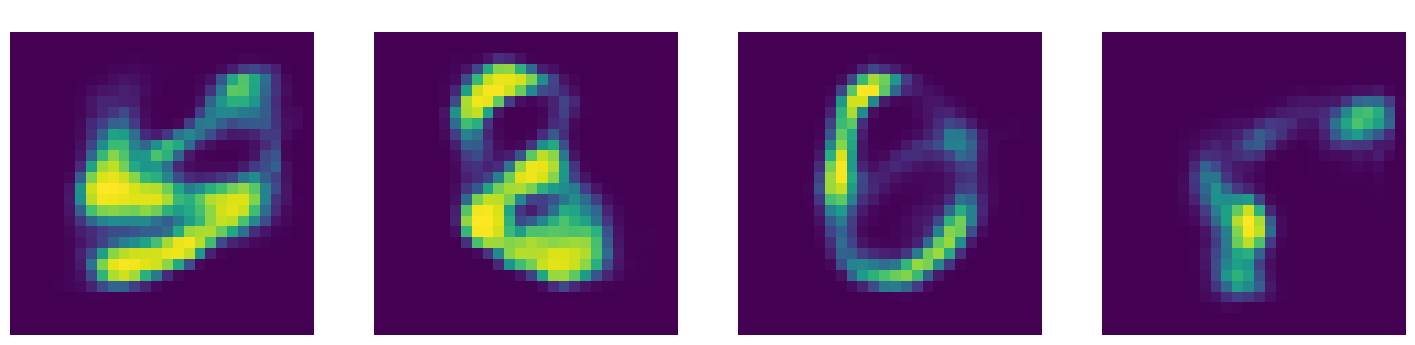

In [10]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

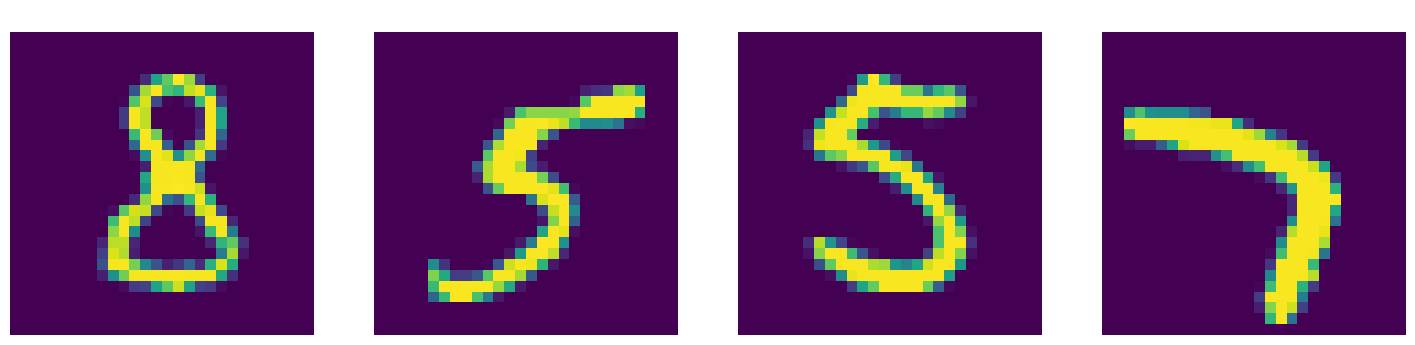

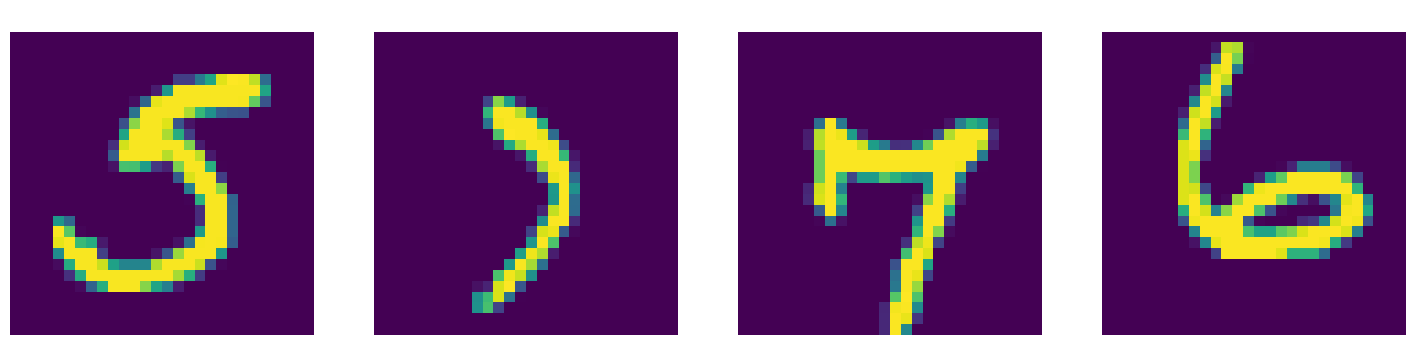

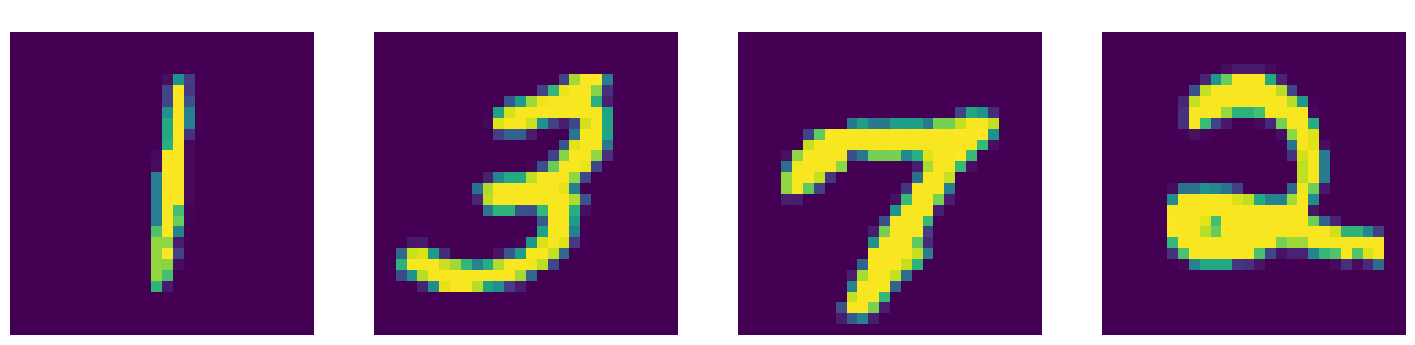

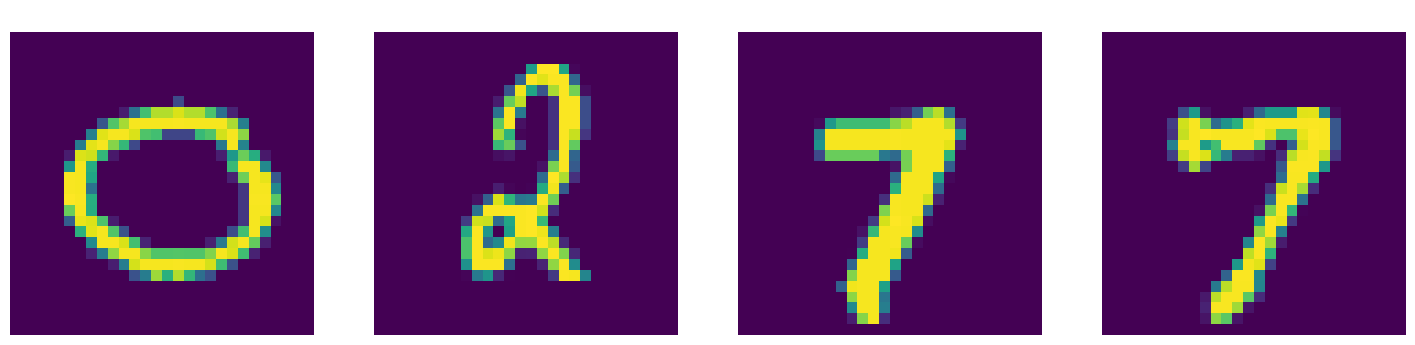

In [11]:
# Display last test batch

display_images(None, x, 4, count=True)

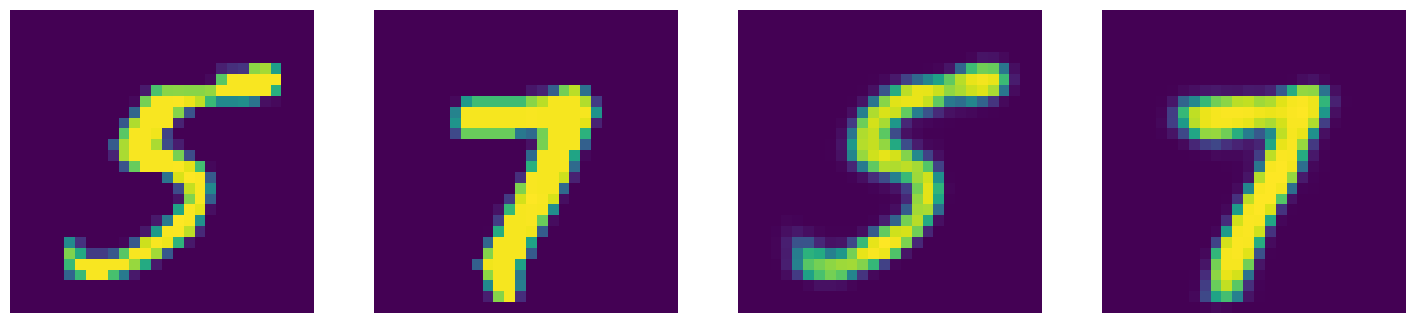

In [12]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

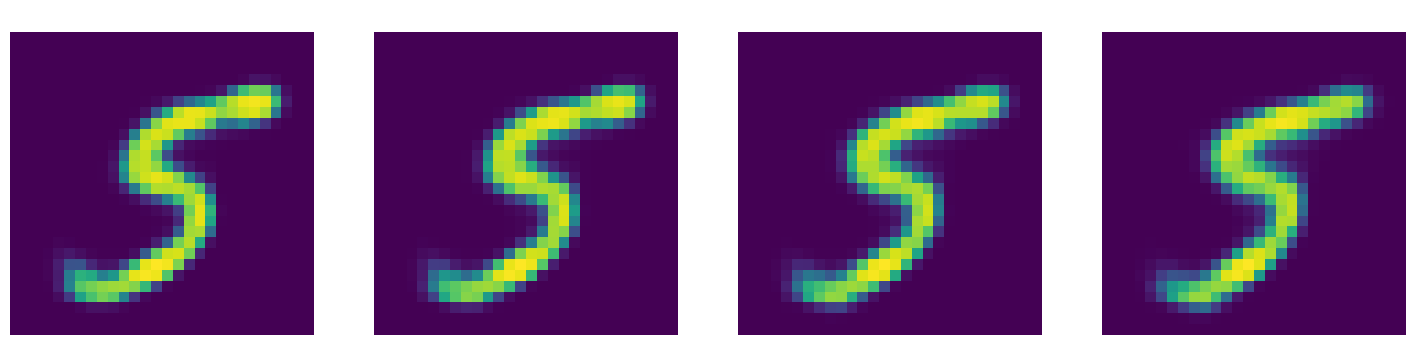

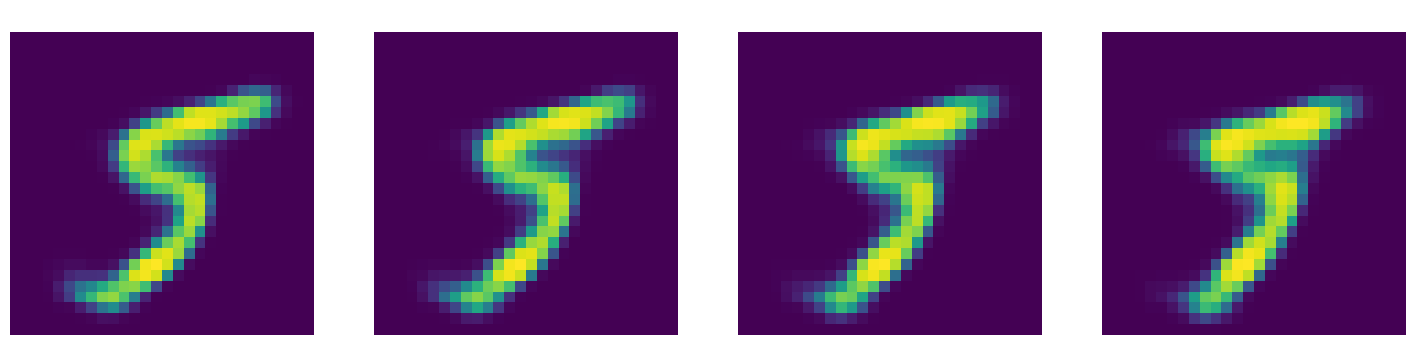

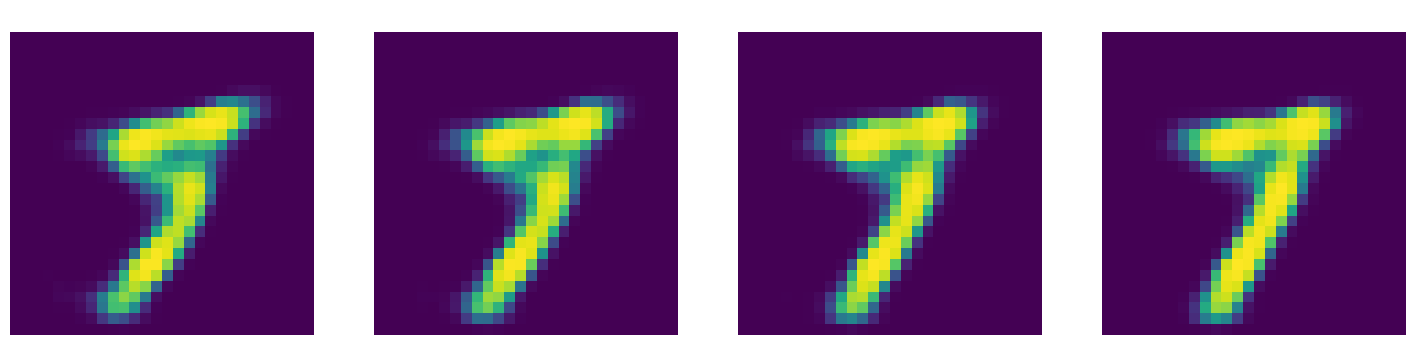

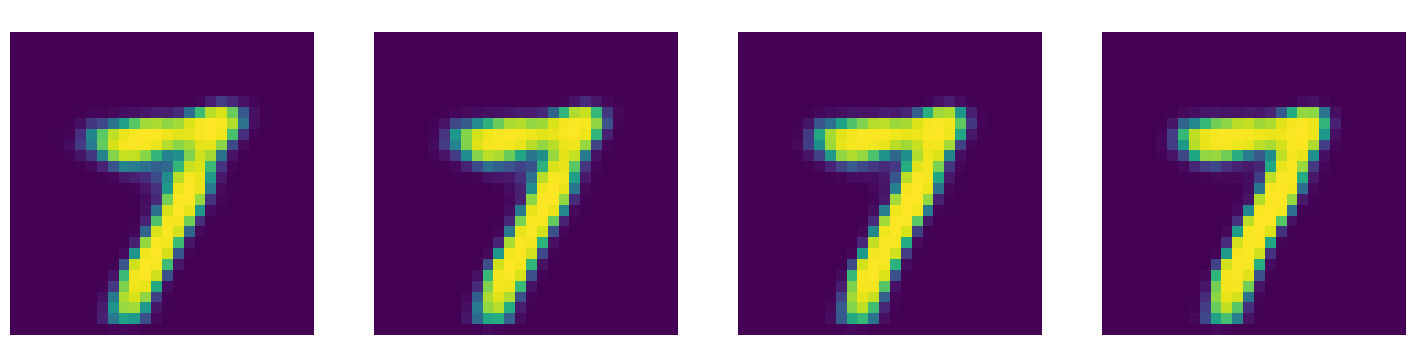

In [13]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [14]:
import numpy as np
from sklearn.manifold import TSNE

In [15]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [16]:
set_default(figsize=(15, 4))

In [17]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

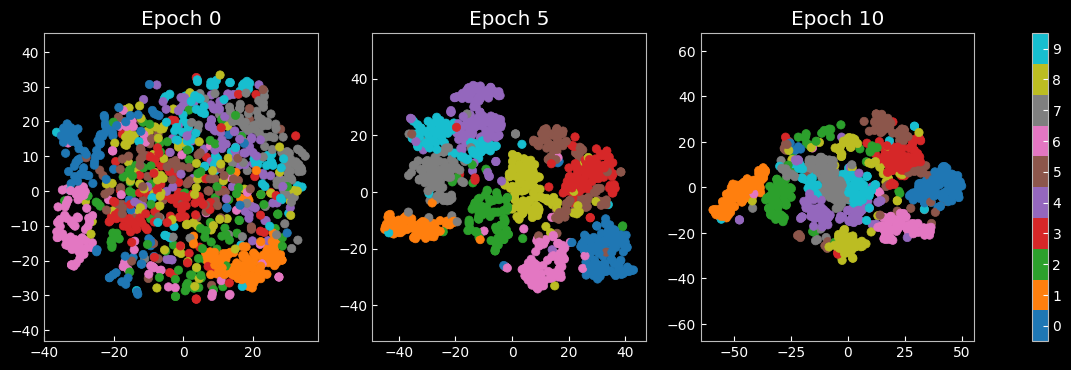

In [18]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

#### Migration to TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt

2023-12-17 18:30:05.699115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 18:30:06.101093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 18:30:06.101128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 18:30:06.162205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 18:30:06.289755: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = tf.reshape(in_, (-1, 28, 28))
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = tf.reshape(out, (-1, 28, 28))
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds
tf.random.set_seed(1)

In [4]:
# Define data loading step
batch_size = 256

# Pull MNIST data using Keras database
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Replicate PyTorch tensor scaling
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
# Replicate PyTorch batching
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(batch_size)
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(1000).batch(batch_size)

2023-12-17 18:30:09.194518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 18:30:09.398582: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 18:30:09.398614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 18:30:09.403451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-17 18:30:09.403486: I external/local_xla/xla/stream_executor

In [5]:
# Defining the model
d = 20

class VAE(keras.Model):
    def __init__(self):
        super().__init__()

        # Class attribute tracking training state
        self.training = False

        self.encoder = keras.Sequential([
            keras.layers.InputLayer((28, 28, 1)),
            keras.layers.Flatten(),
            keras.layers.Dense(d ** 2, activation="relu"),
            keras.layers.Dense(d * 2),
        ])

        self.decoder = keras.Sequential([
            keras.layers.Dense(d ** 2, activation="relu"),
            keras.layers.Dense(784, activation="sigmoid"),
            keras.layers.Reshape((28, 28, 1)),
        ])

    def reparameterise(self, mu, logvar):
        if self.training:
            std = tf.exp(logvar * 0.5)
            eps = tf.random.normal(std.shape)
            return eps * std + mu
        else:
          return mu

    def call(self, x, training):
        # Modify training state when prompted
        self.training = training

        mu_logvar = self.encoder(x)
        mu, logvar = tf.split(mu_logvar, 2, 1)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE()

In [6]:
# Setting the optimiser
learning_rate = 1e-3

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
# Reconstruction + β * KL divergence losses summed over all elements and batch
# Modified to parameterize coefficient 0.5
def loss_function(x_hat, x, mu, logvar, β=1, coeff=0.5):
    BCE = tf.reduce_sum(keras.losses.binary_crossentropy(x, x_hat))
    KLD = coeff * tf.math.reduce_sum(tf.exp(logvar) - logvar - 1 + tf.pow(mu, 2))

    return BCE + β * KLD

====> Test set loss: 532.1551
====> Epoch: 1 Average loss: 188.5462
====> Test set loss: 130.4277
====> Epoch: 2 Average loss: 132.5591
====> Test set loss: 113.7975
====> Epoch: 3 Average loss: 121.9342
====> Test set loss: 106.6475
====> Epoch: 4 Average loss: 116.8852
====> Test set loss: 103.7744
====> Epoch: 5 Average loss: 114.0846
====> Test set loss: 101.7879
====> Epoch: 6 Average loss: 112.1280
====> Test set loss: 99.7073
====> Epoch: 7 Average loss: 110.6521
====> Test set loss: 98.7015
====> Epoch: 8 Average loss: 109.5818
====> Test set loss: 97.8608
====> Epoch: 9 Average loss: 108.6933
====> Test set loss: 97.2376
====> Epoch: 10 Average loss: 107.9837
====> Test set loss: 96.3758


<ipython-input-2-86cf5db85052>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


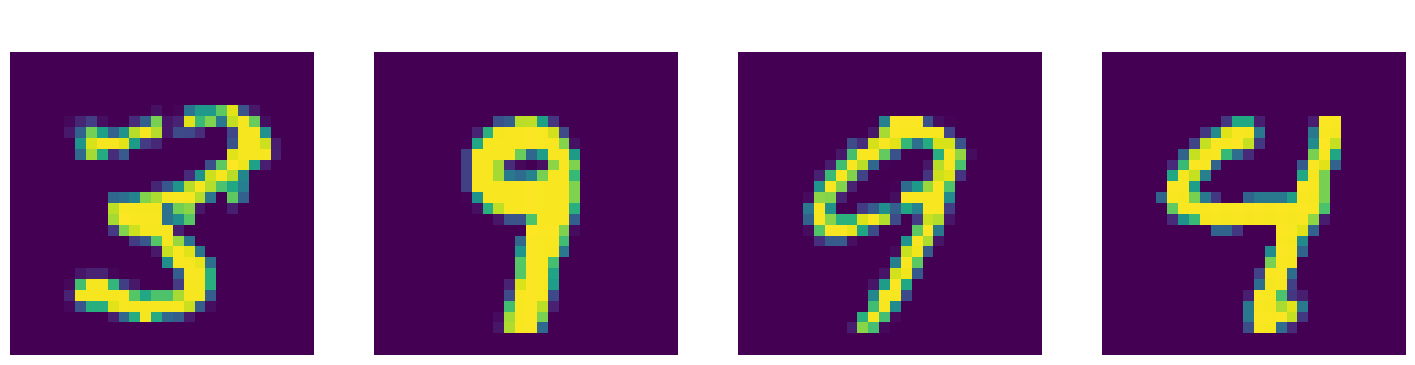

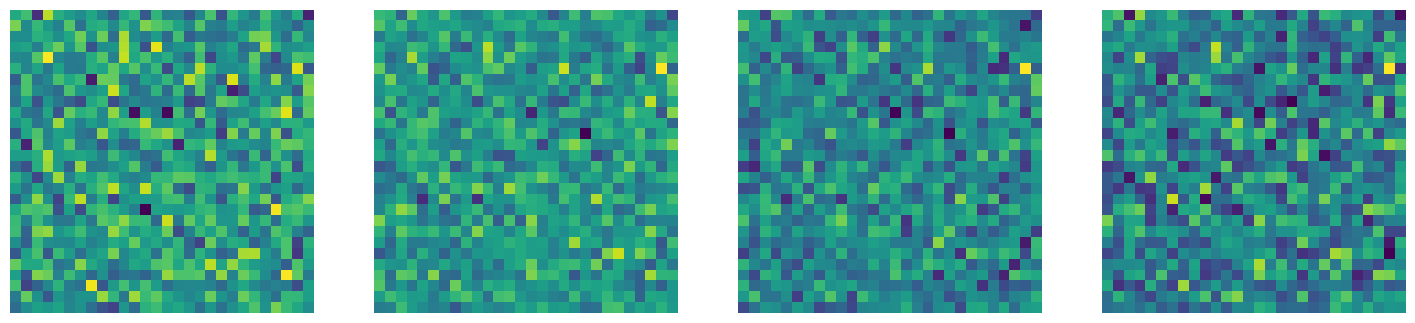

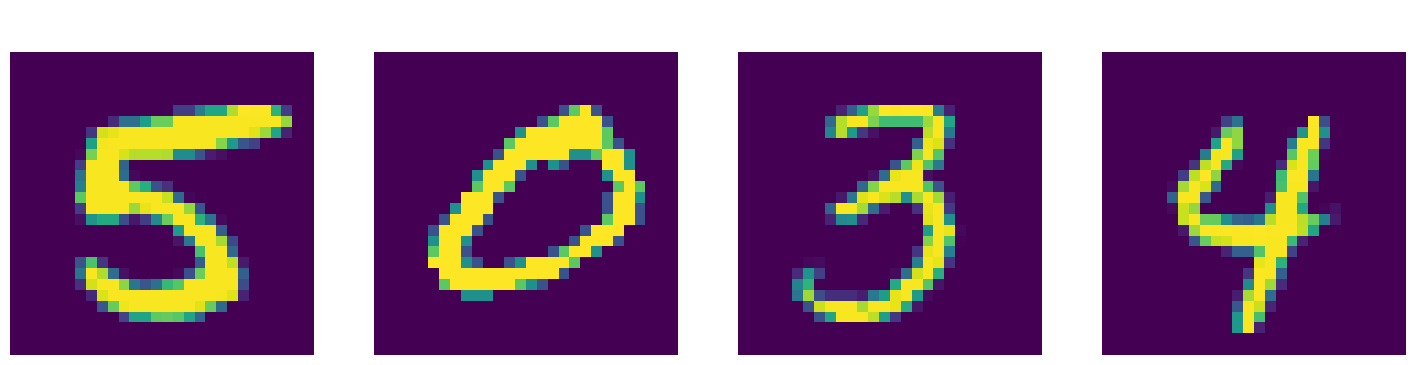

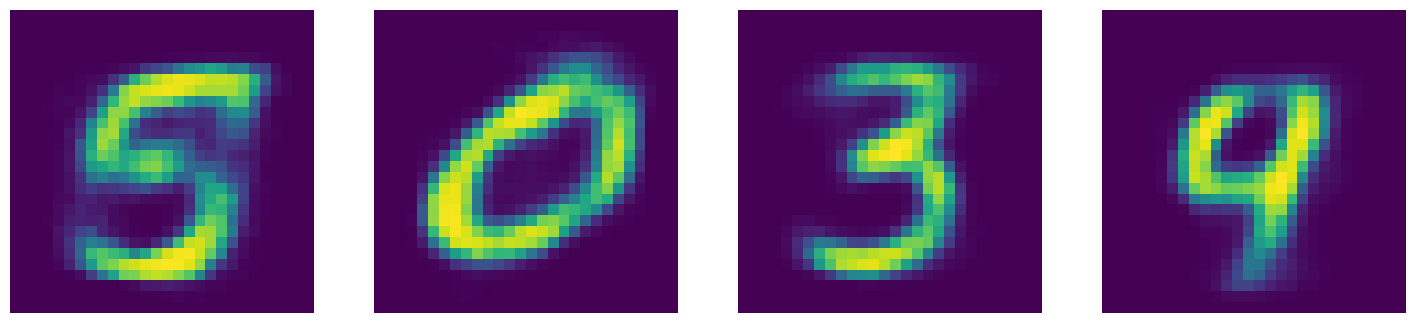

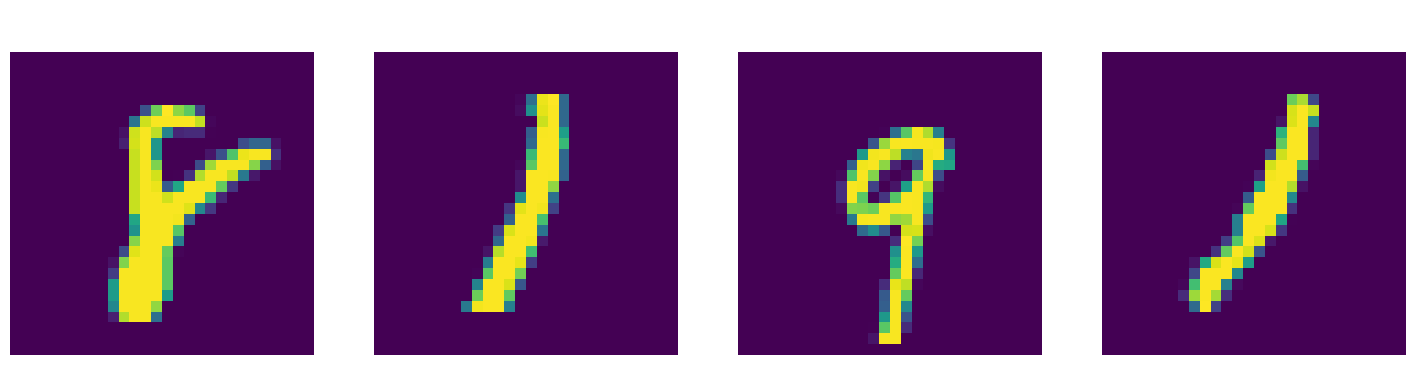

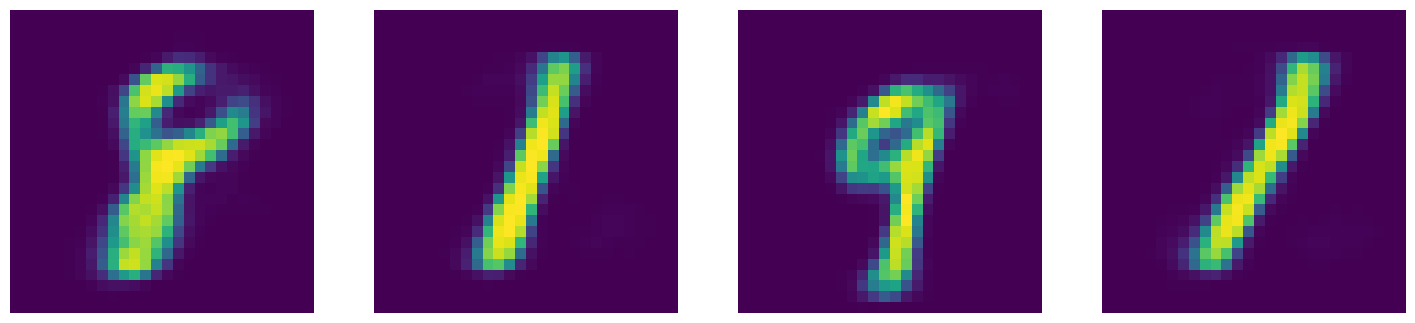

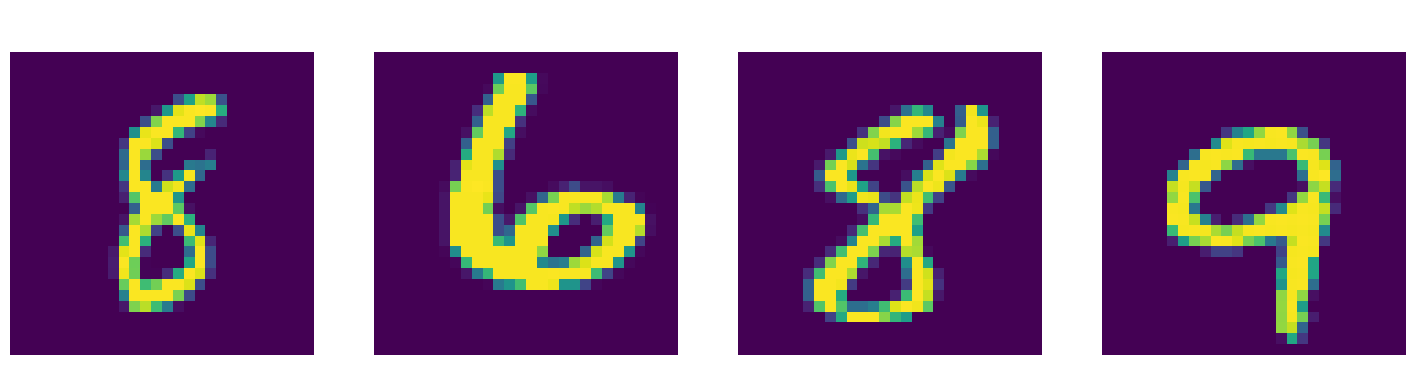

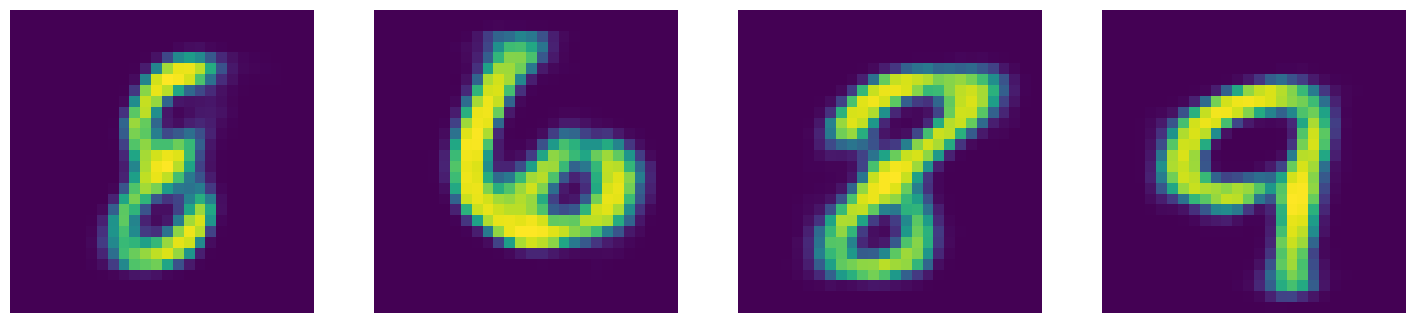

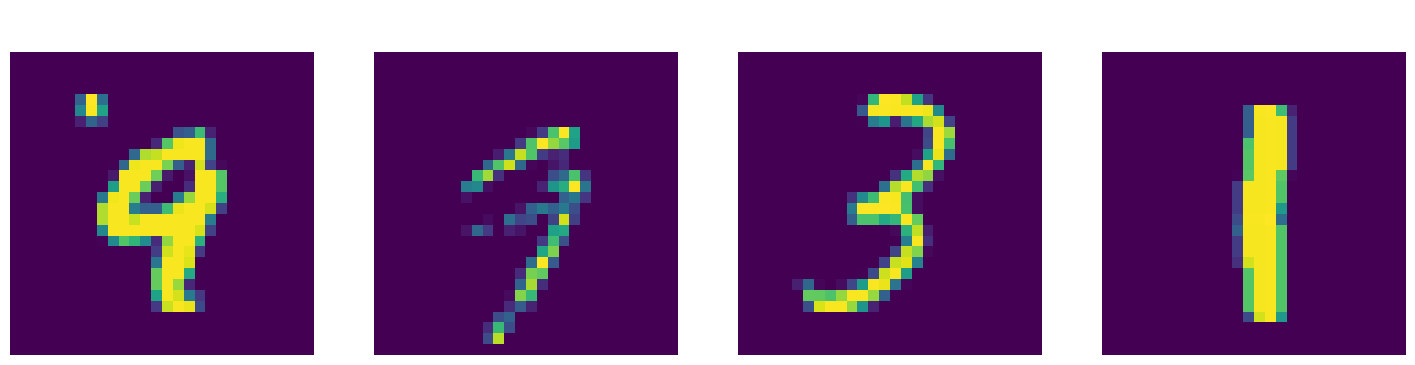

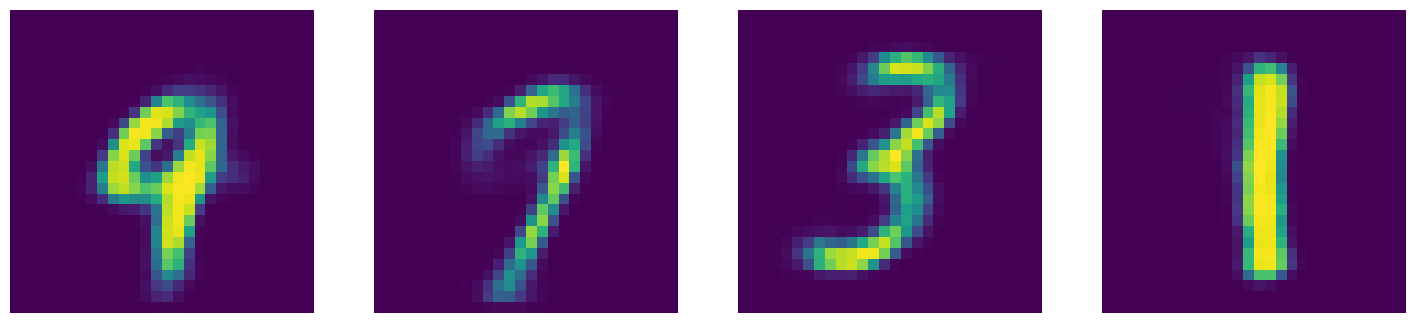

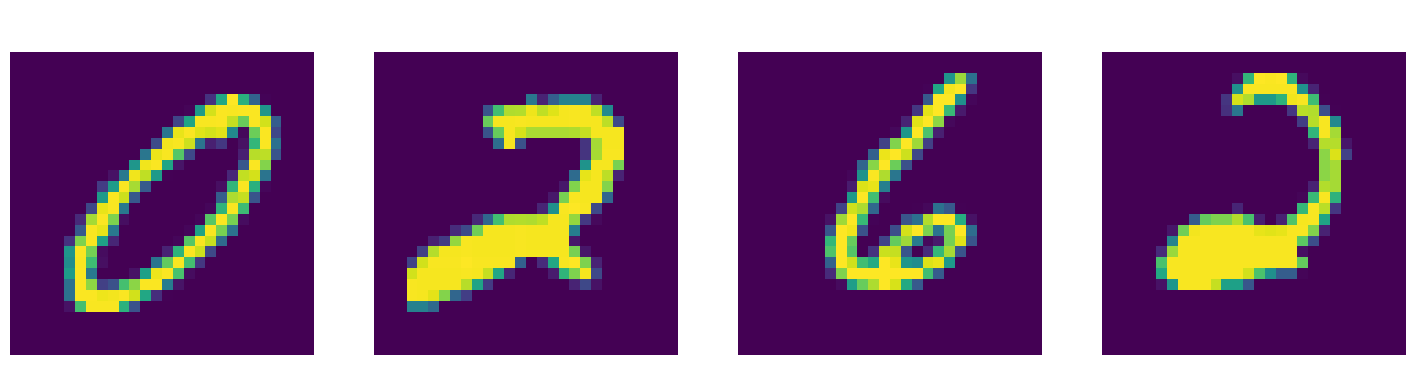

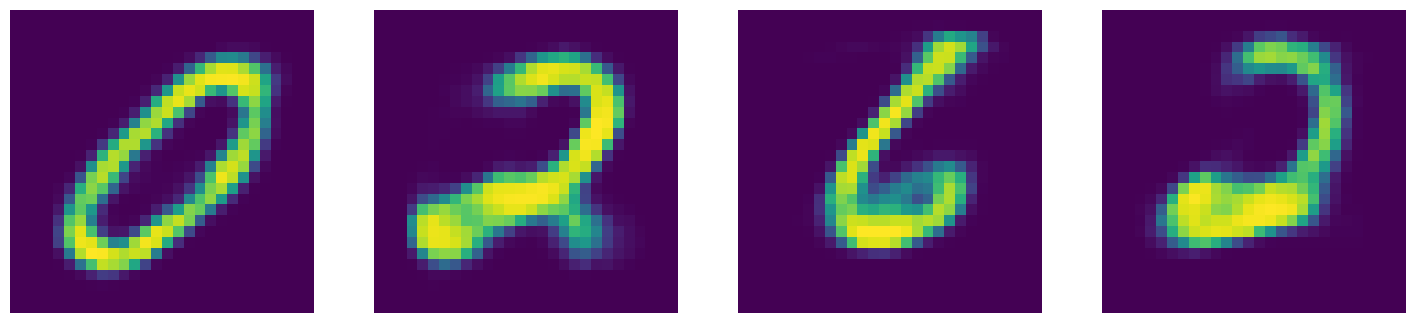

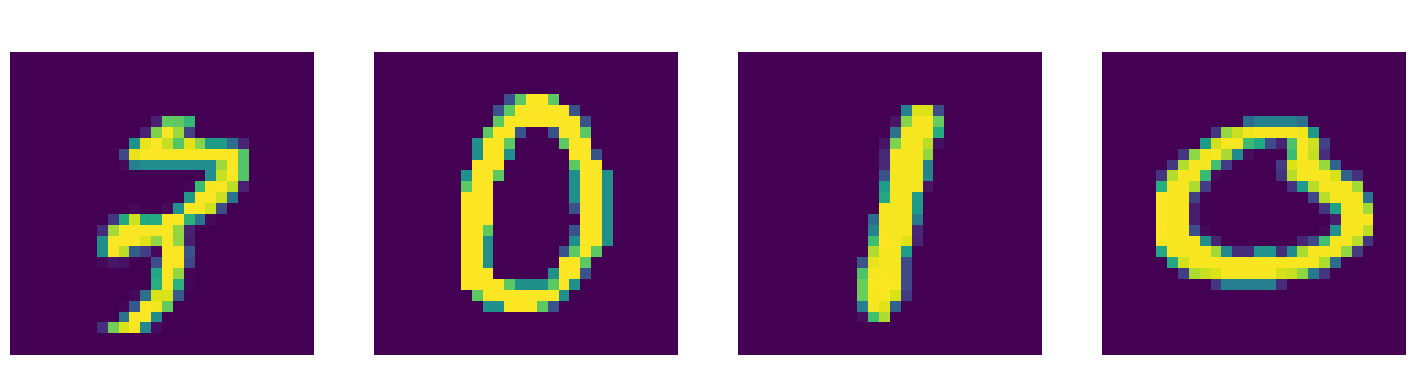

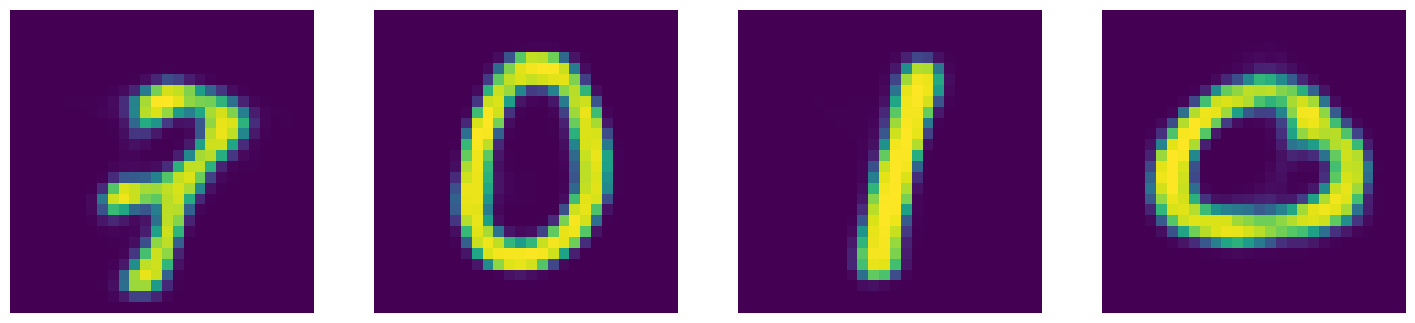

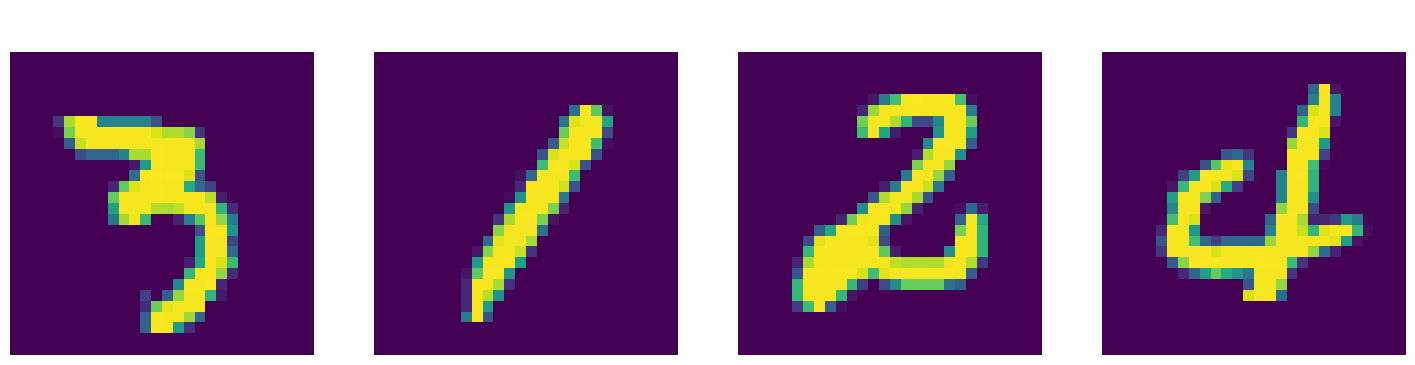

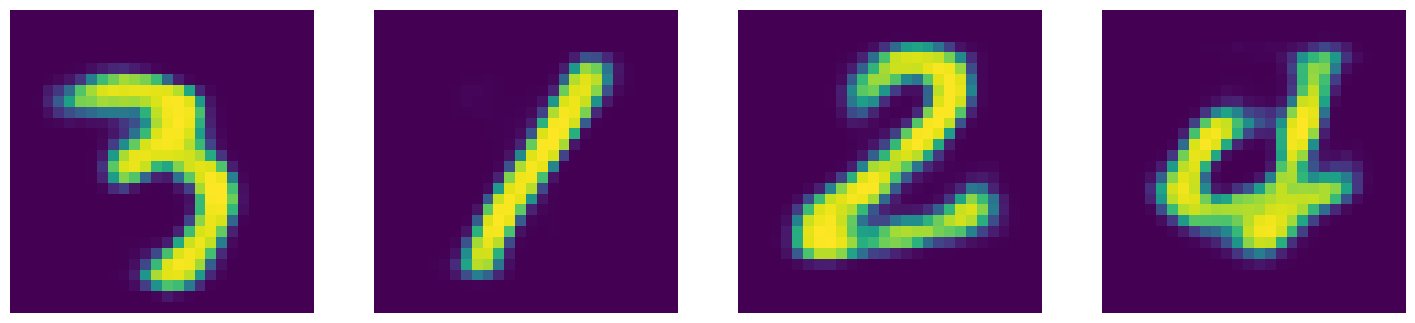

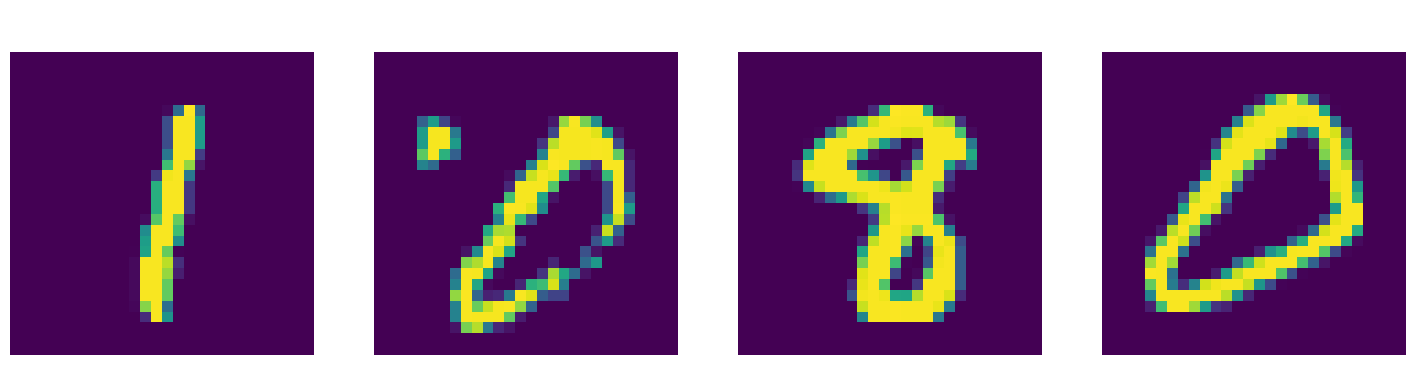

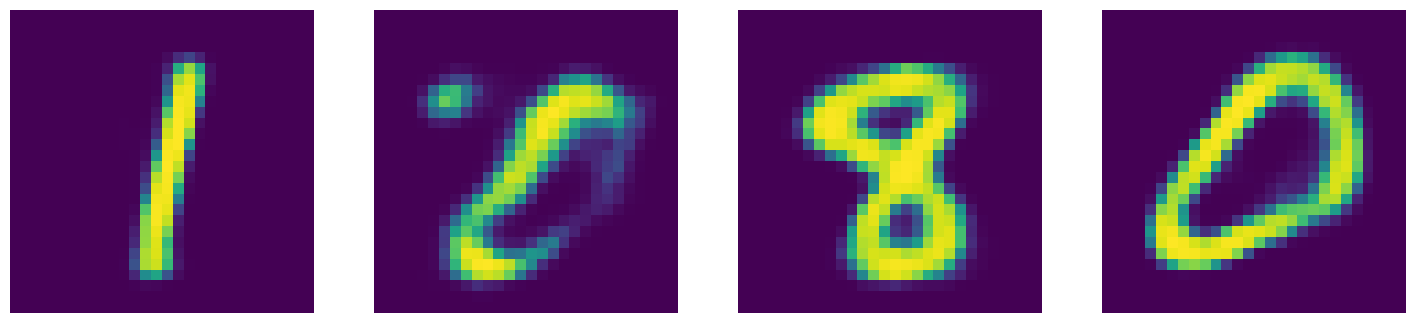

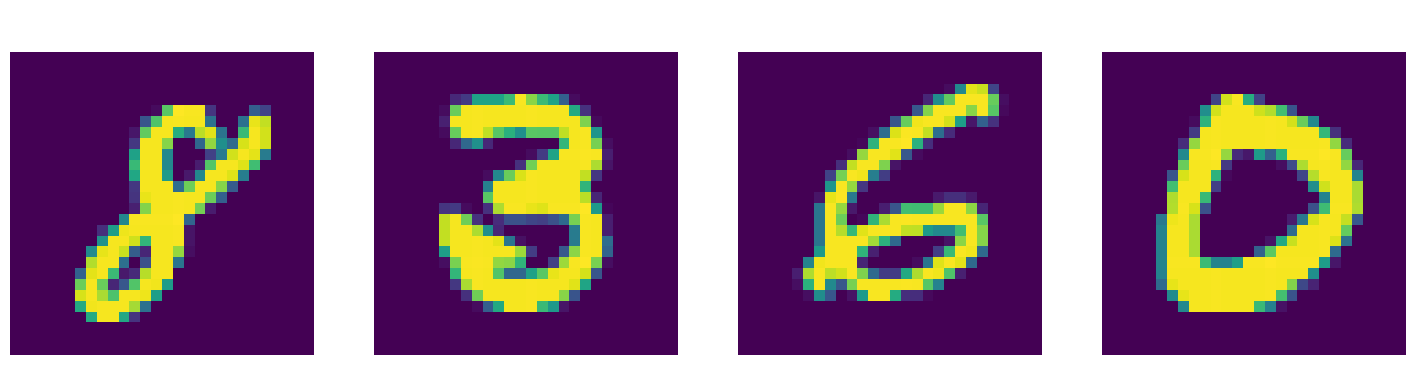

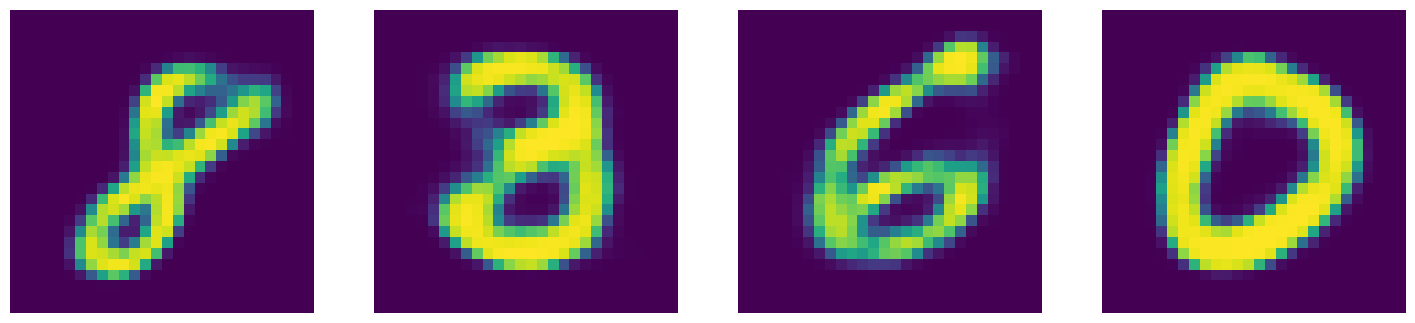

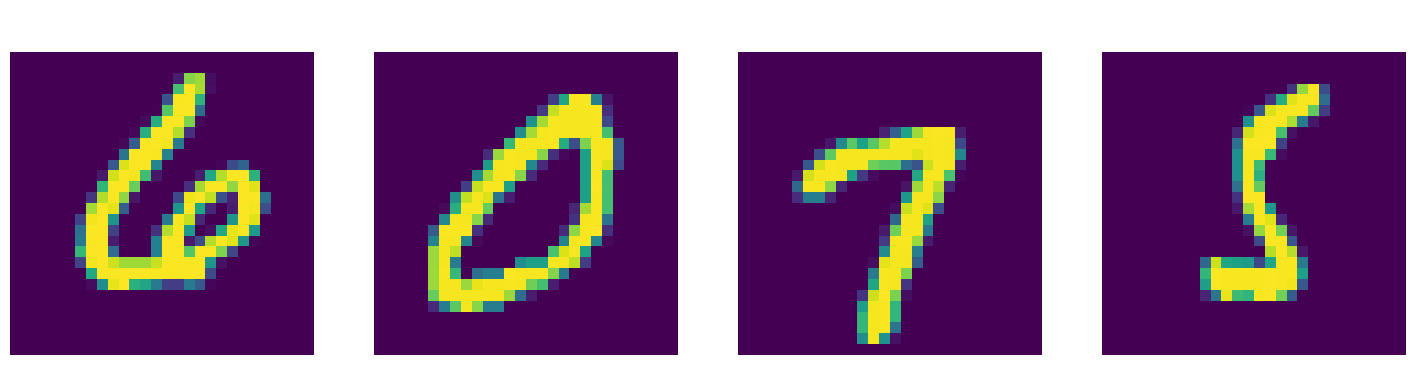

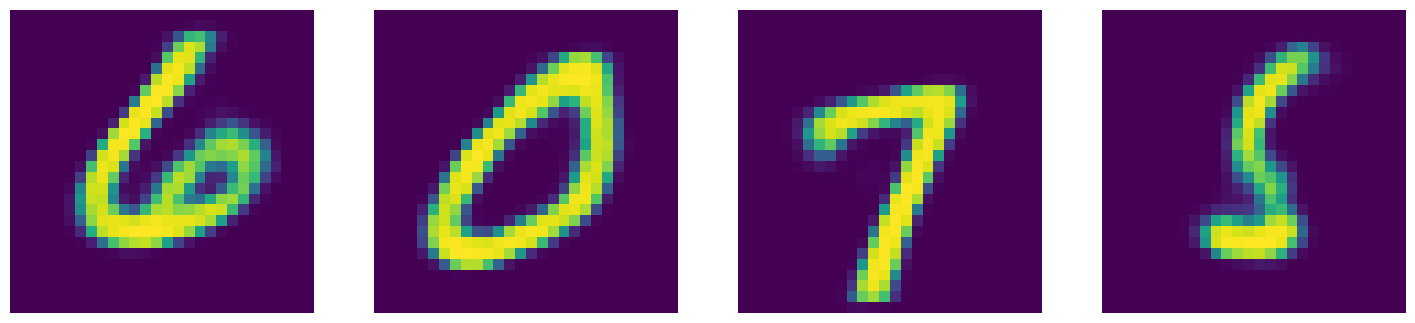

In [8]:
# Training and testing the VAE
epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        train_loss = 0
        for x, _ in train_loader:
            with tf.GradientTape() as tape:
                # ===================forward=====================
                x_hat, mu, logvar = model(x, True)
                loss = loss_function(x_hat, x, mu, logvar)
            gradients = tape.gradient(loss, model.trainable_variables)
            train_loss += loss
            # ===================backward====================
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / (batch_size * len(train_loader)):.4f}')

    # Testing
    means, logvars, labels = list(), list(), list()

    test_loss = 0
    for x, y in test_loader:
        # ===================forward=====================
        x_hat, mu, logvar = model(x, False)
        test_loss += loss_function(x_hat, x, mu, logvar)
        # =====================log=======================
        means.append(mu)
        logvars.append(logvar)
        labels.append(y)
    # ===================log========================
    codes['μ'].append(np.concatenate(means))
    codes['logσ2'].append(np.concatenate(logvars))
    codes['y'].append(np.concatenate(labels))
    test_loss /= (batch_size * len(test_loader))
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

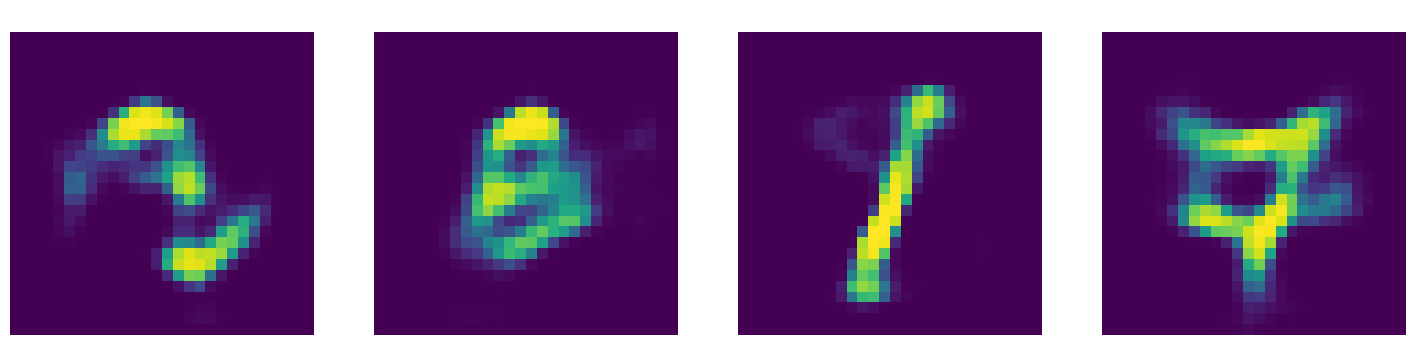

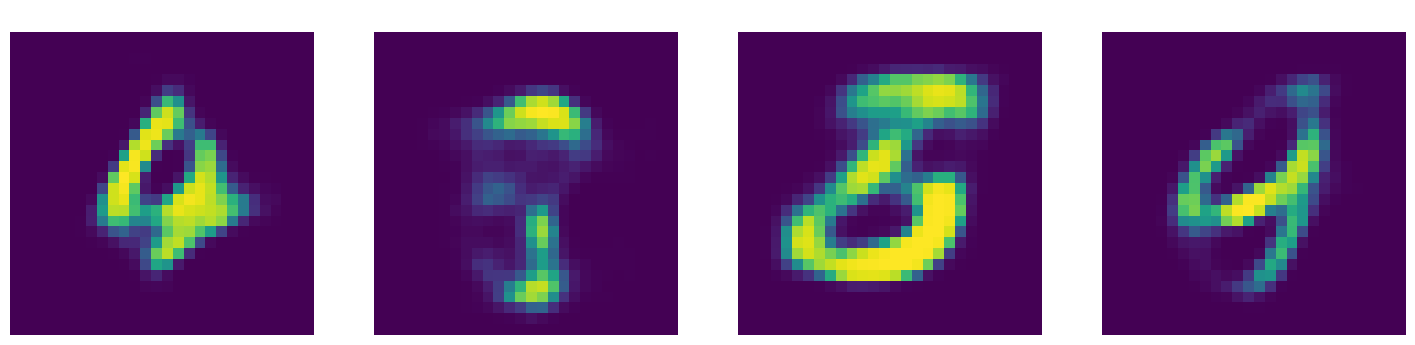

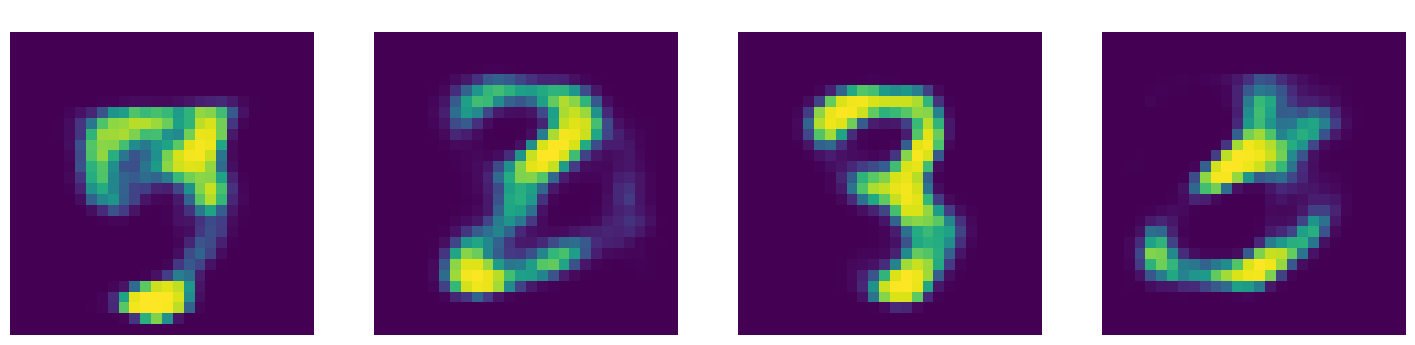

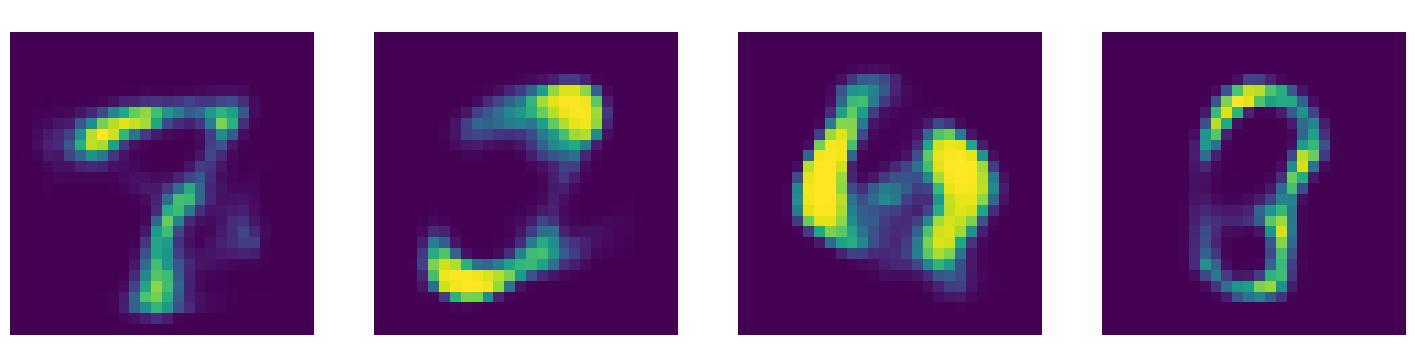

In [9]:
# Generating a few samples
N = 16
z = tf.random.normal((N, d))
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

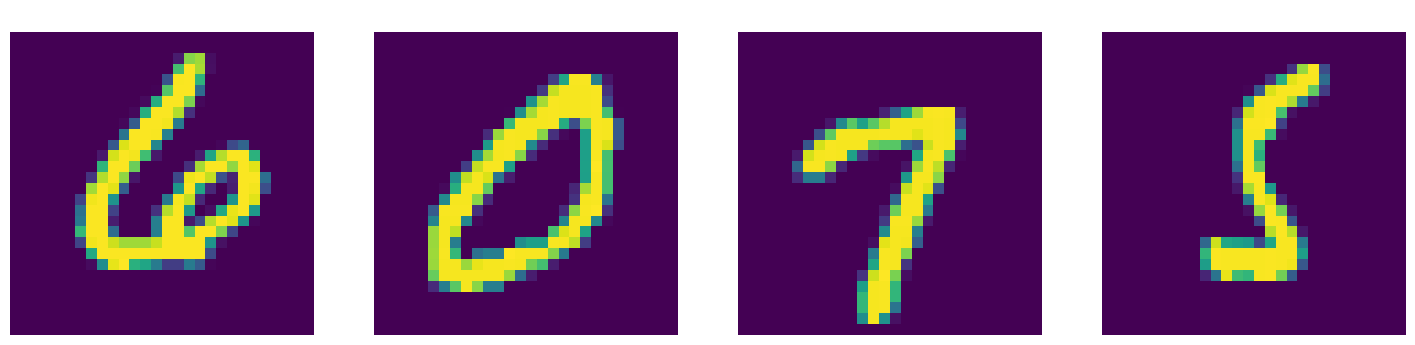

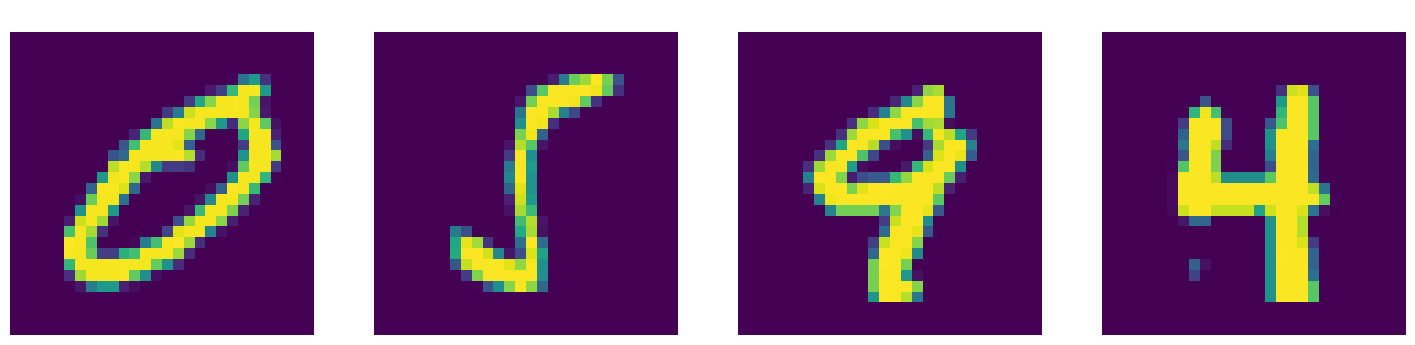

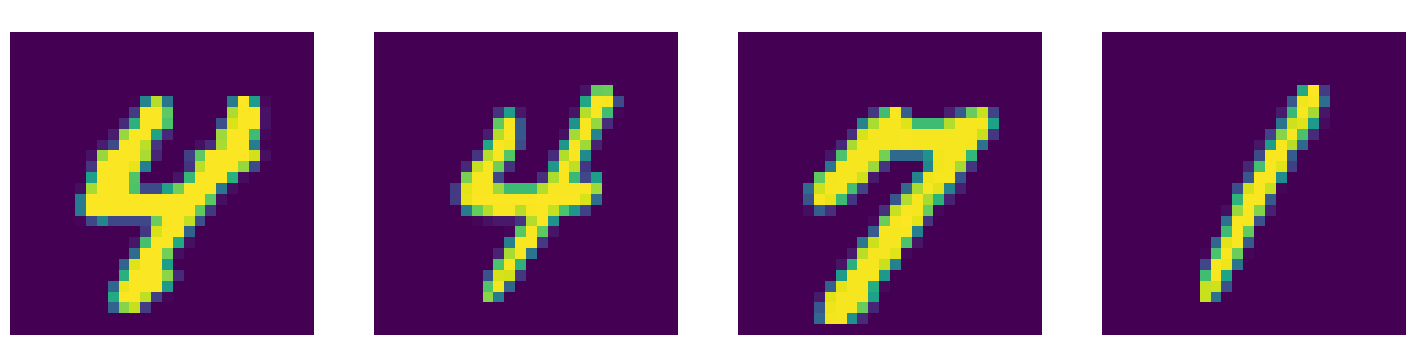

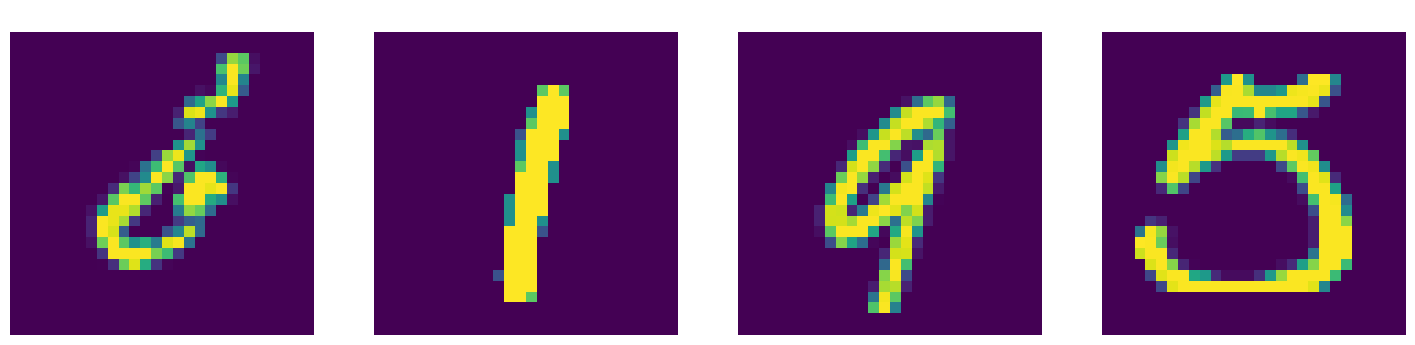

In [10]:
# Display last test batch
display_images(None, x, 4, count=True)

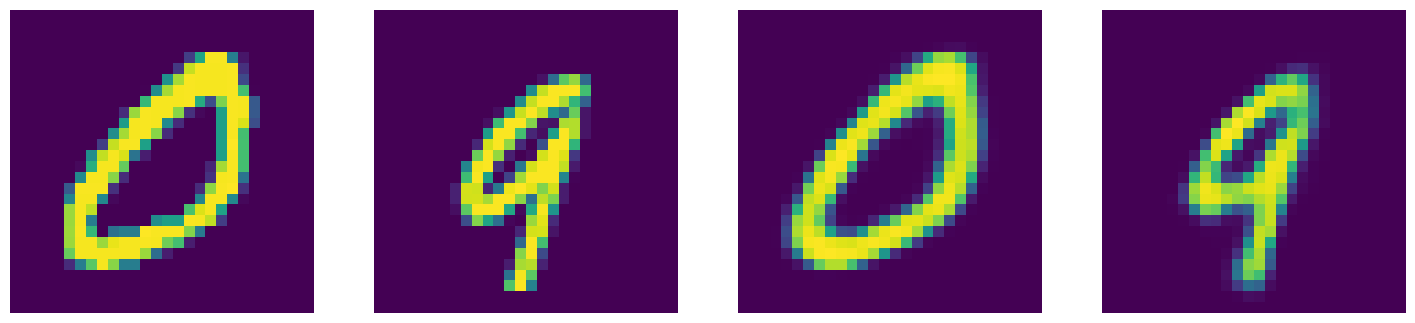

In [11]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed
A, B = 1, 14
sample = model.decoder(np.stack((mu[A], mu[B]), 0))
display_images(None, np.stack(((
    x[A],
    x[B],
    sample[0],
    sample[1]
)), 0))

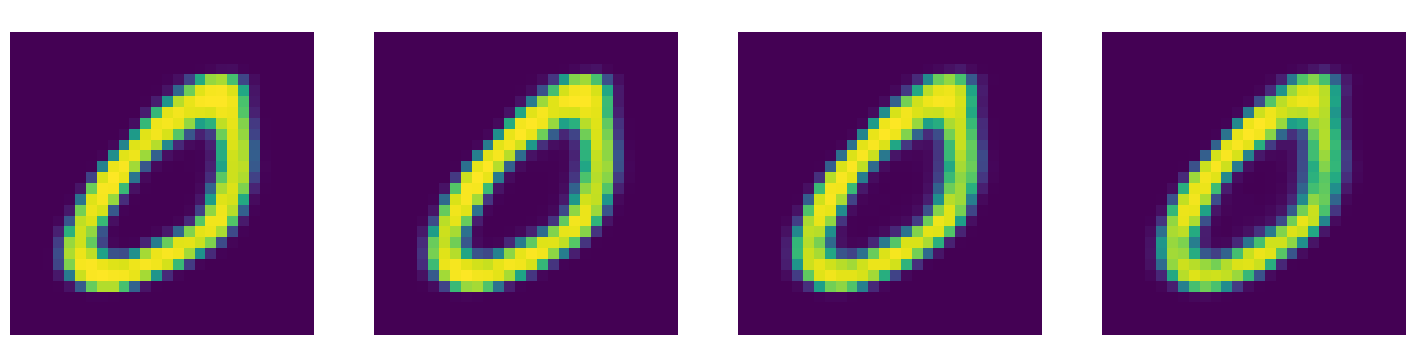

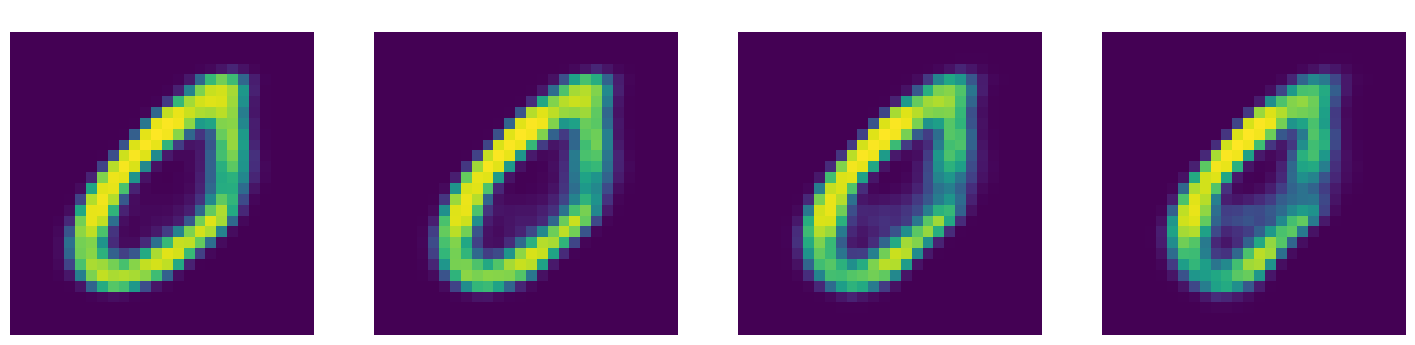

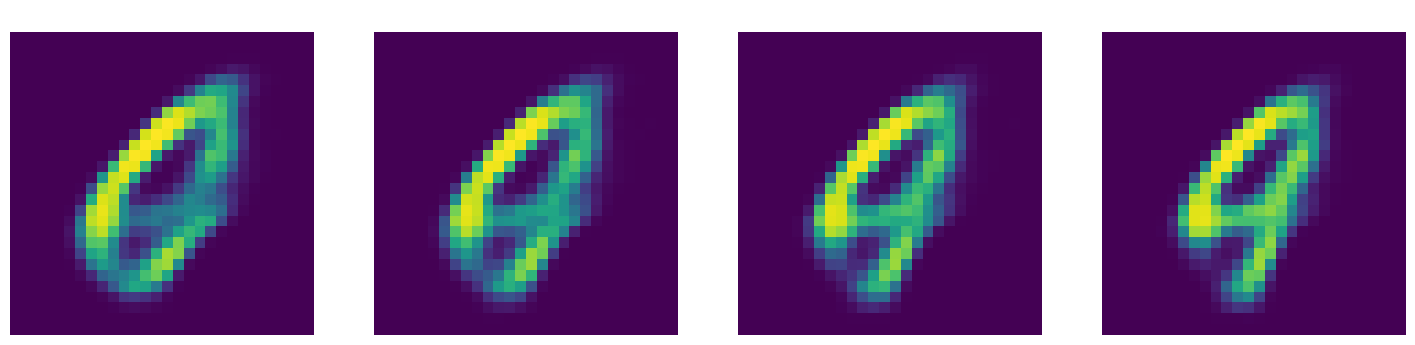

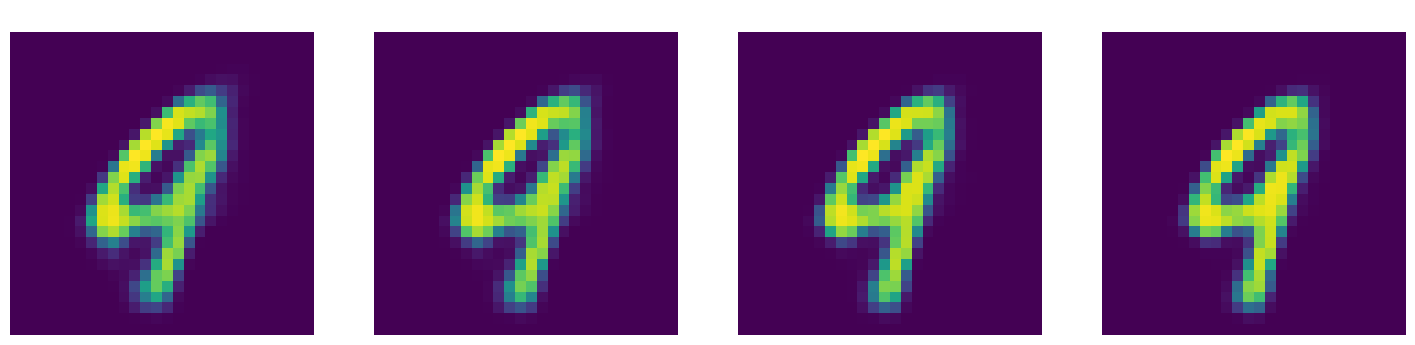

In [12]:
# Perform an interpolation between input A and B, in N steps
N = 16
code = np.zeros((N, 20))
sample = np.zeros((N, 28, 28))
for i in range(N):
    code[i] = i / (N - 1) * mu[B] + (1 - i / (N - 1) ) * mu[A]
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [13]:
import numpy as np
from sklearn.manifold import TSNE

In [14]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [15]:
set_default(figsize=(15, 4))

In [16]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

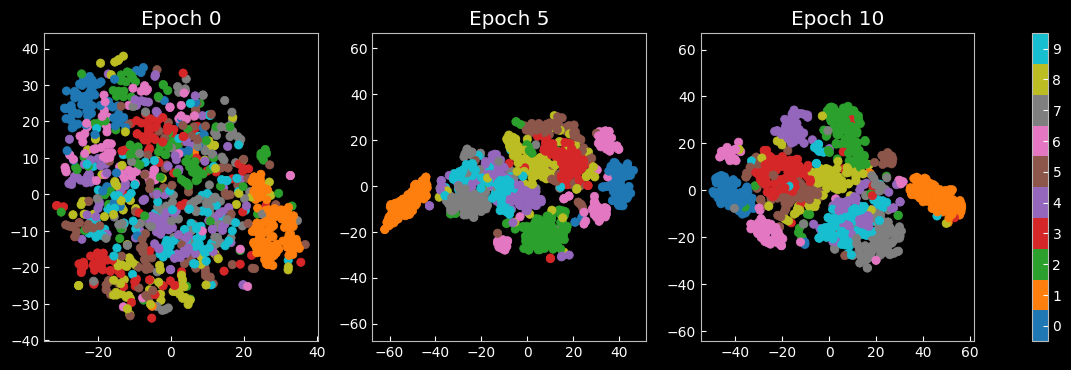

In [17]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

### Experiment with different model configurations

#### Modify optimizer

In [9]:
# Methodization of model training procedure for optimization and coefficient variation experiment
def experiment(optimizer, coeff=0.5, showImg = True):
    # Make a new model
    model = VAE()
    print("Coefficient:", coeff)
    #=====================================
    # Model training
    #=====================================
    # Training and testing the VAE
    epochs = 10
    codes = dict(μ=list(), logσ2=list(), y=list())
    for epoch in range(0, epochs + 1):
        # Training
        if epoch > 0:  # test untrained net first
            train_loss = 0
            for x, _ in train_loader:
                with tf.GradientTape() as tape:
                    # ===================forward=====================
                    x_hat, mu, logvar = model(x, True)
                    loss = loss_function(x_hat, x, mu, logvar, coeff)
                gradients = tape.gradient(loss, model.trainable_variables)
                train_loss += loss
                # ===================backward====================
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # ===================log========================
            print(f'====> Epoch: {epoch} Average loss: {train_loss / (batch_size * len(train_loader)):.4f}')

        # Testing
        means, logvars, labels = list(), list(), list()

        test_loss = 0
        for x, y in test_loader:
            # ===================forward=====================
            x_hat, mu, logvar = model(x, False)
            test_loss += loss_function(x_hat, x, mu, logvar, coeff)
            # =====================log=======================
            means.append(mu)
            logvars.append(logvar)
            labels.append(y)
        # ===================log========================
        codes['μ'].append(np.concatenate(means))
        codes['logσ2'].append(np.concatenate(logvars))
        codes['y'].append(np.concatenate(labels))
        test_loss /= (batch_size * len(test_loader))
        print(f'====> Test set loss: {test_loss:.4f}')
        if showImg:
            display_images(x, x_hat, 1, f'Epoch {epoch}')

In [10]:
# Global learning rate for all optimizers
learning_rate = 1e-3

Coefficient: 0.5
====> Test set loss: 532.3303
====> Epoch: 1 Average loss: 545.1244
====> Test set loss: 529.9140
====> Epoch: 2 Average loss: 537.9263
====> Test set loss: 526.3149
====> Epoch: 3 Average loss: 528.3138
====> Test set loss: 516.7273
====> Epoch: 4 Average loss: 506.0876
====> Test set loss: 473.2318
====> Epoch: 5 Average loss: 423.6784
====> Test set loss: 351.1246
====> Epoch: 6 Average loss: 323.1888
====> Test set loss: 289.1666
====> Epoch: 7 Average loss: 283.8019
====> Test set loss: 265.7274
====> Epoch: 8 Average loss: 266.3157
====> Test set loss: 253.3233
====> Epoch: 9 Average loss: 256.2245
====> Test set loss: 245.4582
====> Epoch: 10 Average loss: 249.5739
====> Test set loss: 239.9198


<ipython-input-2-86cf5db85052>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


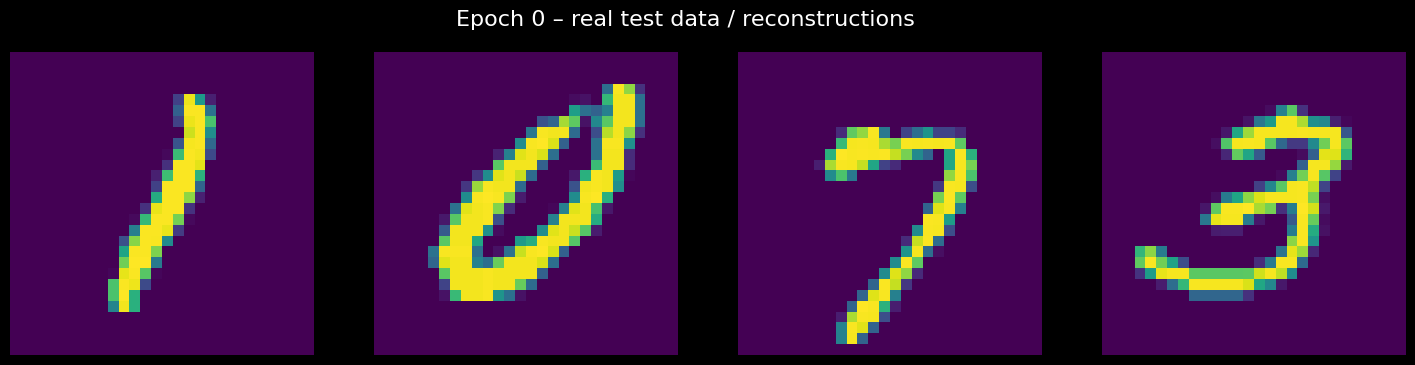

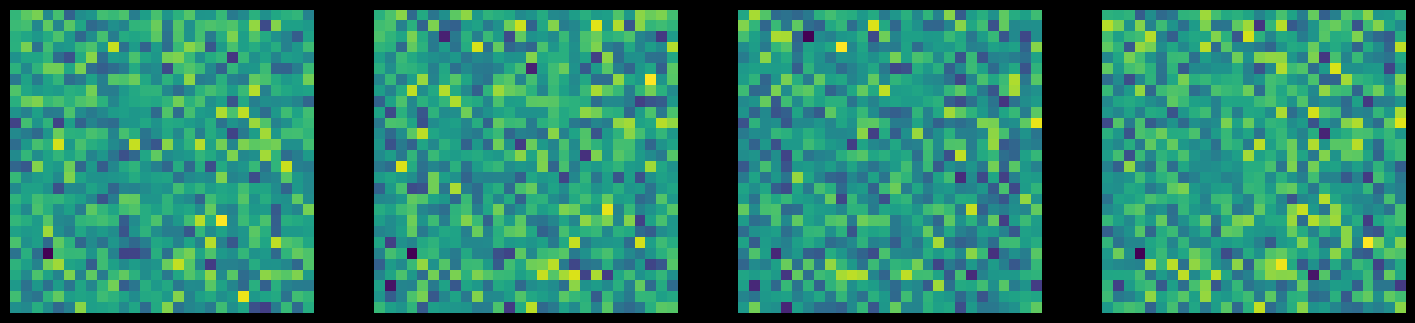

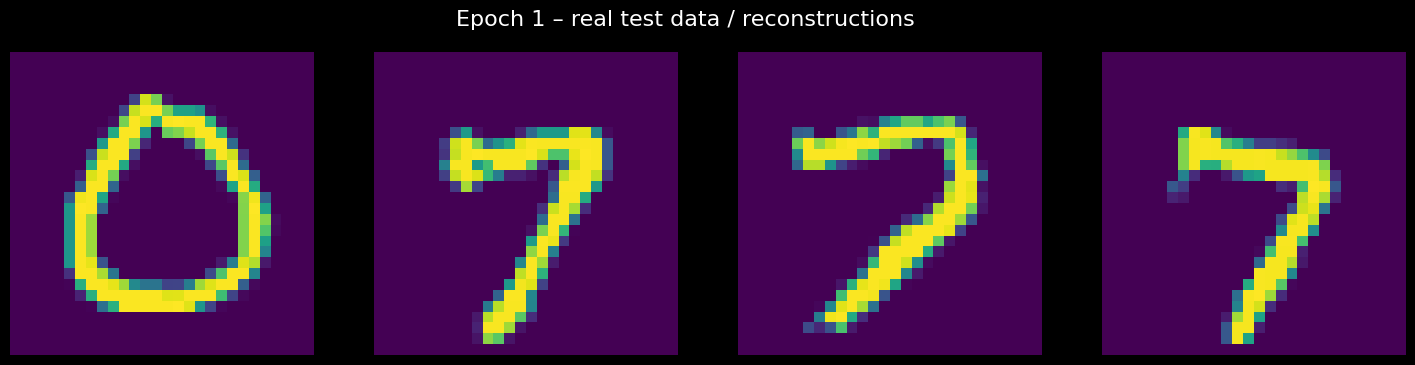

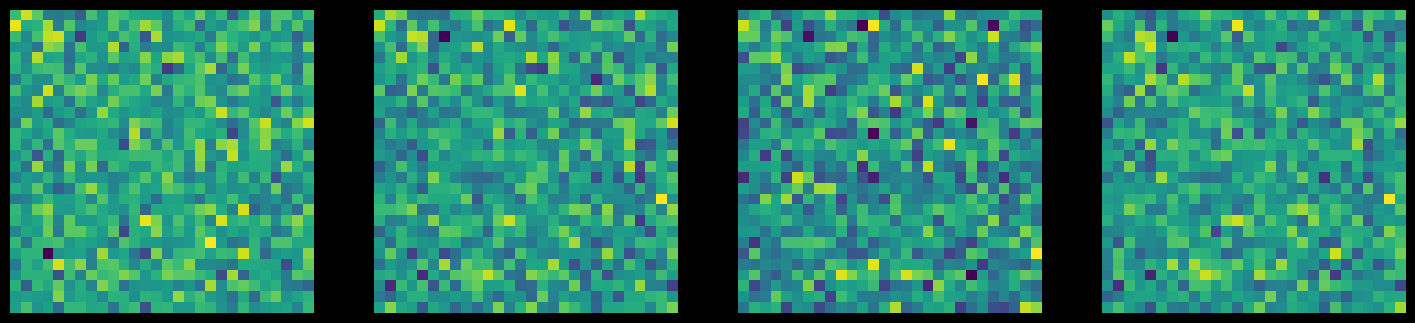

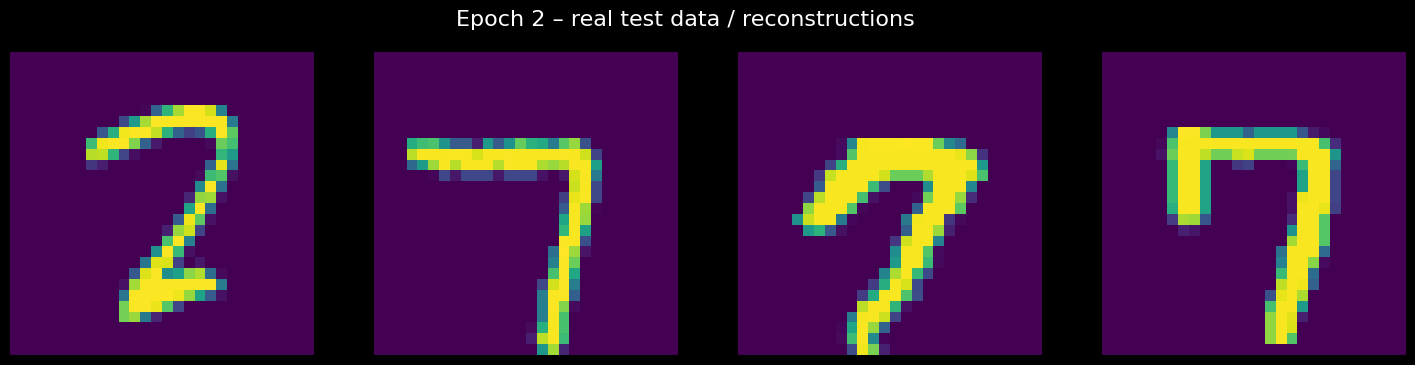

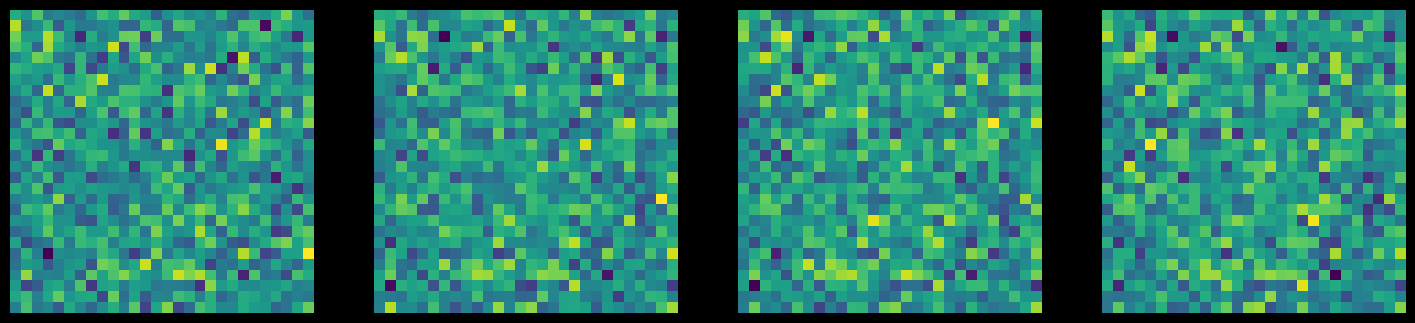

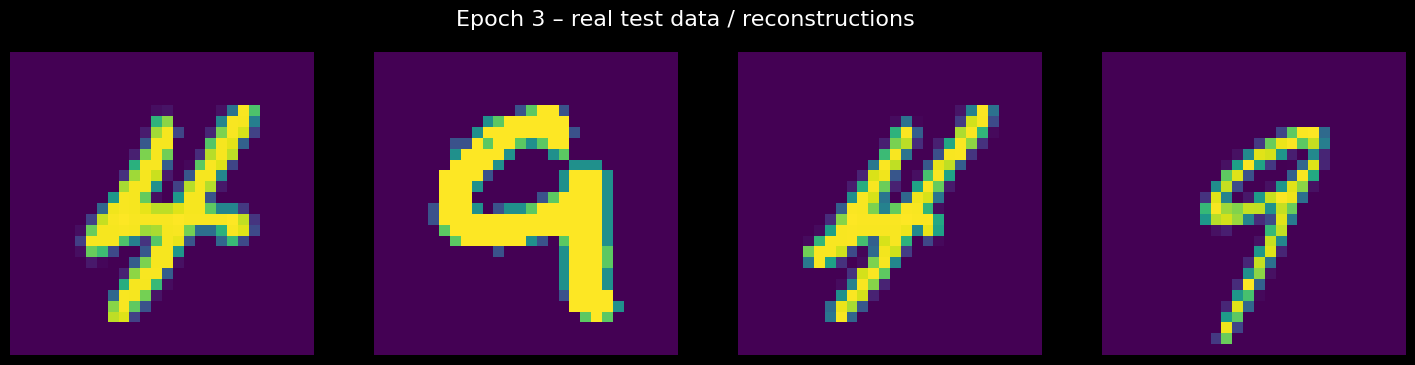

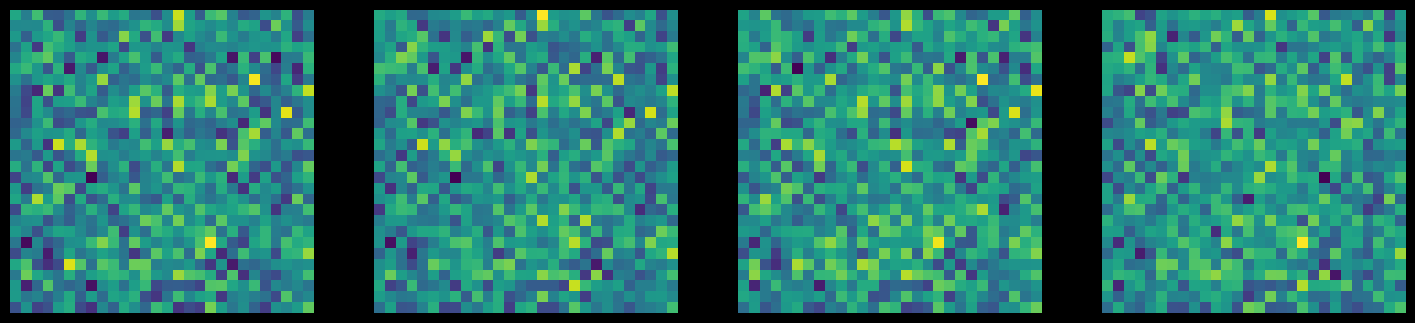

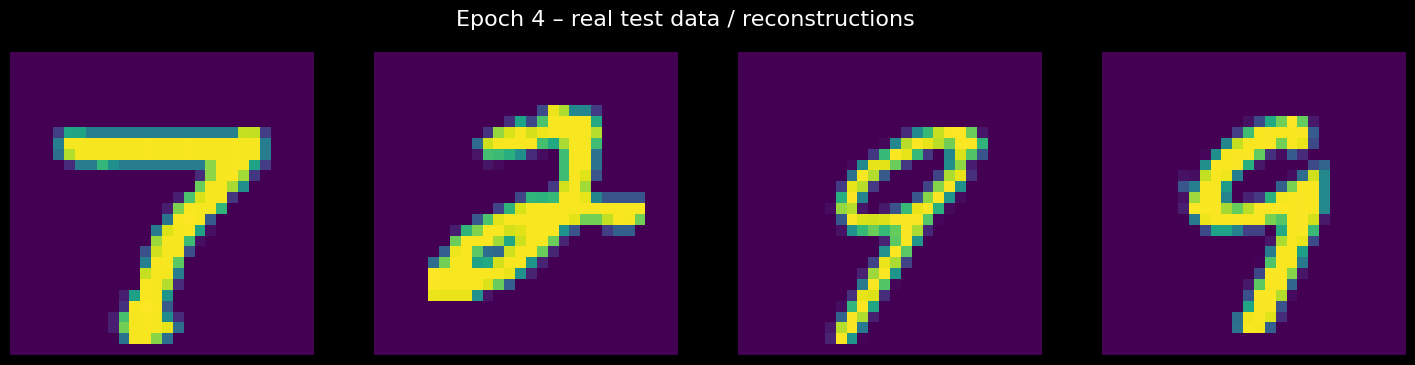

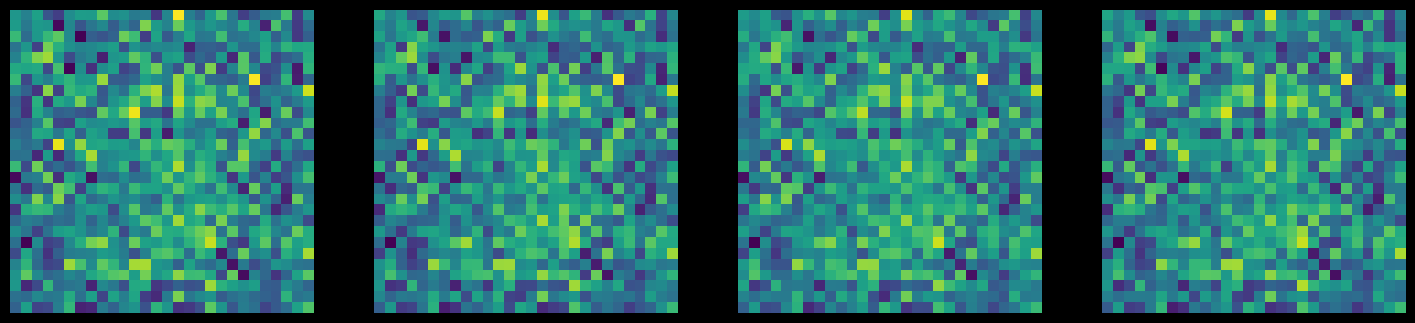

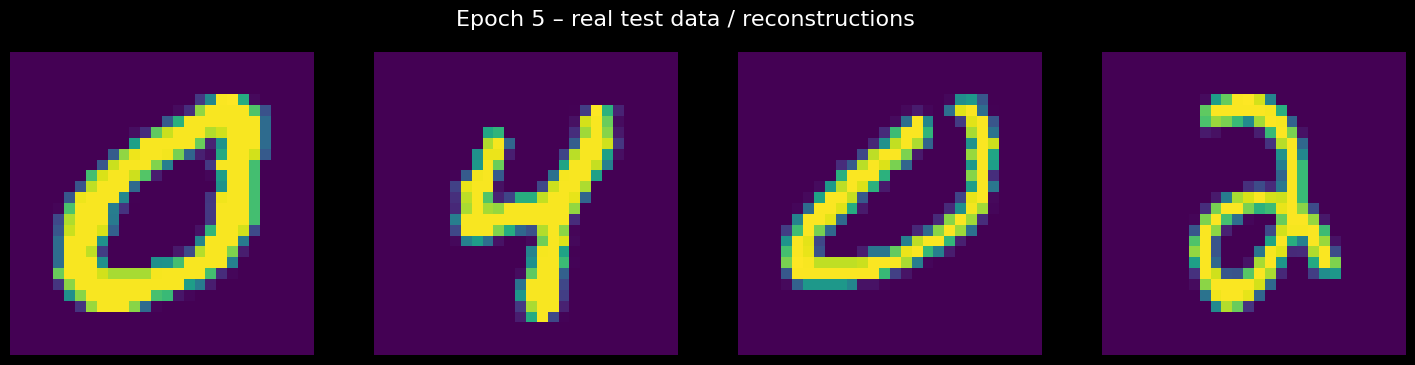

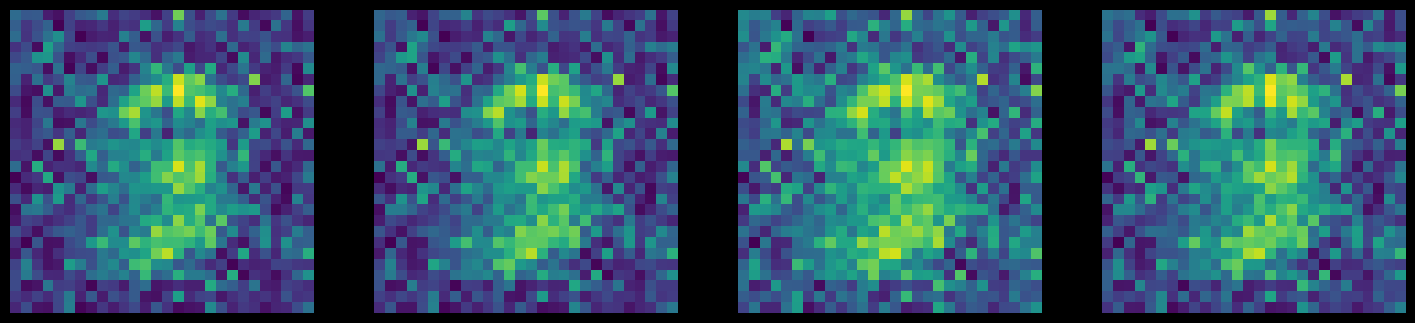

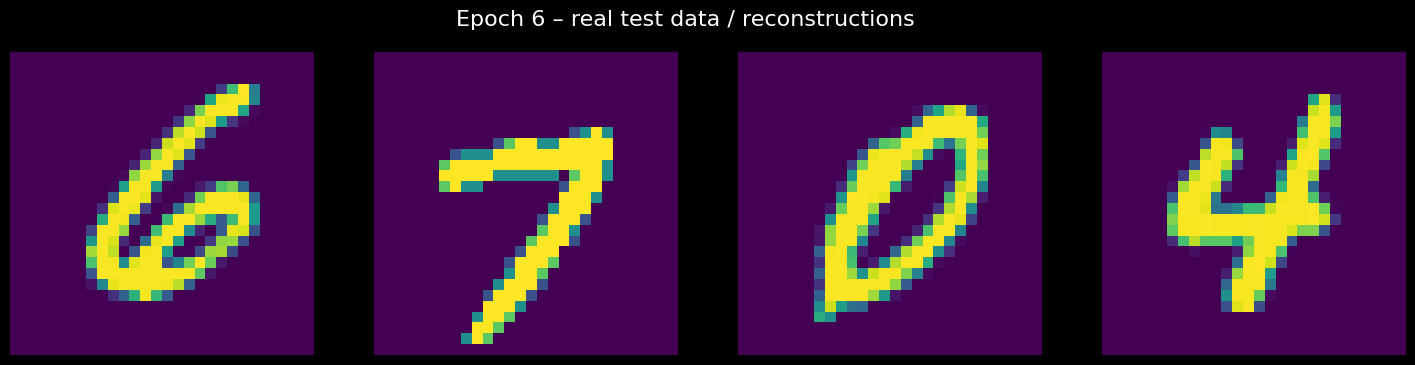

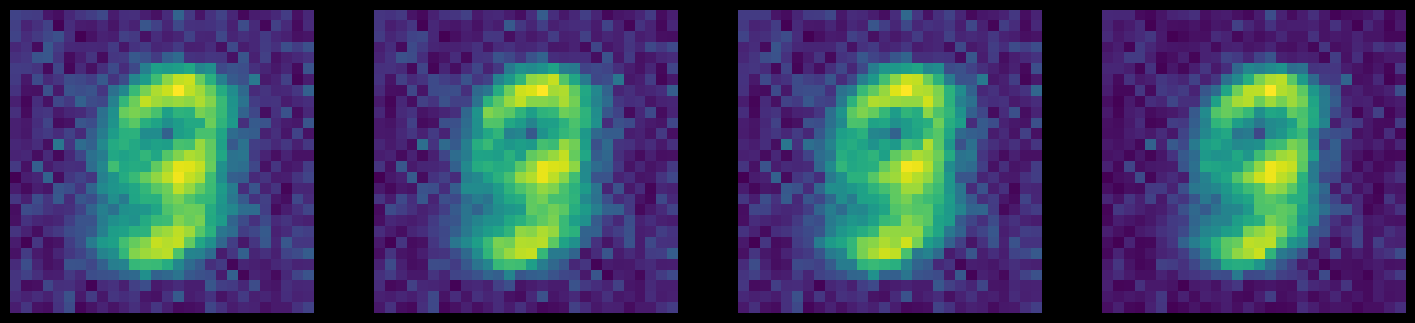

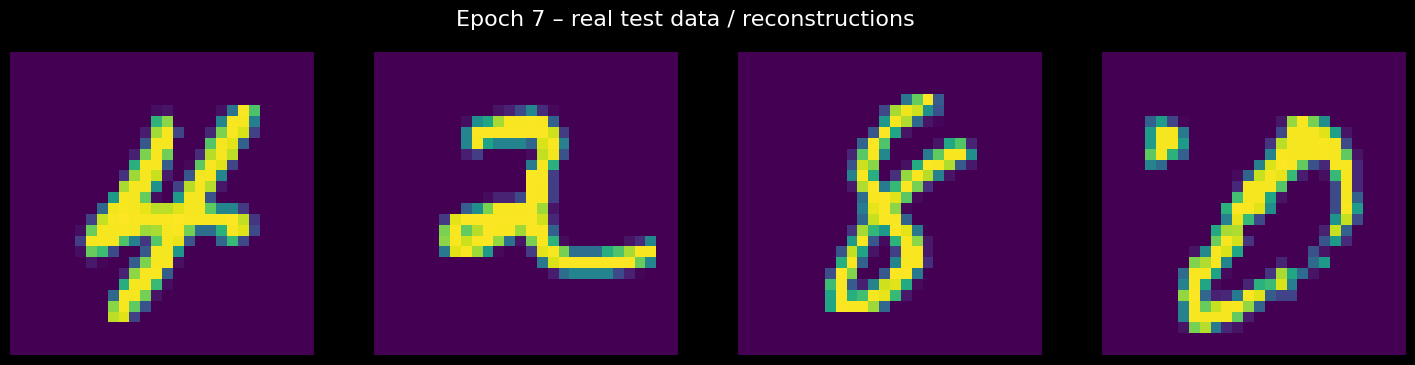

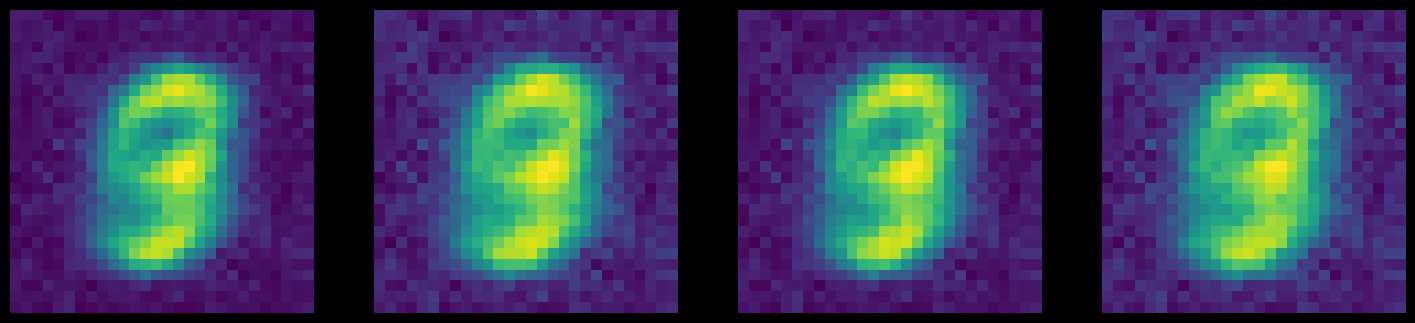

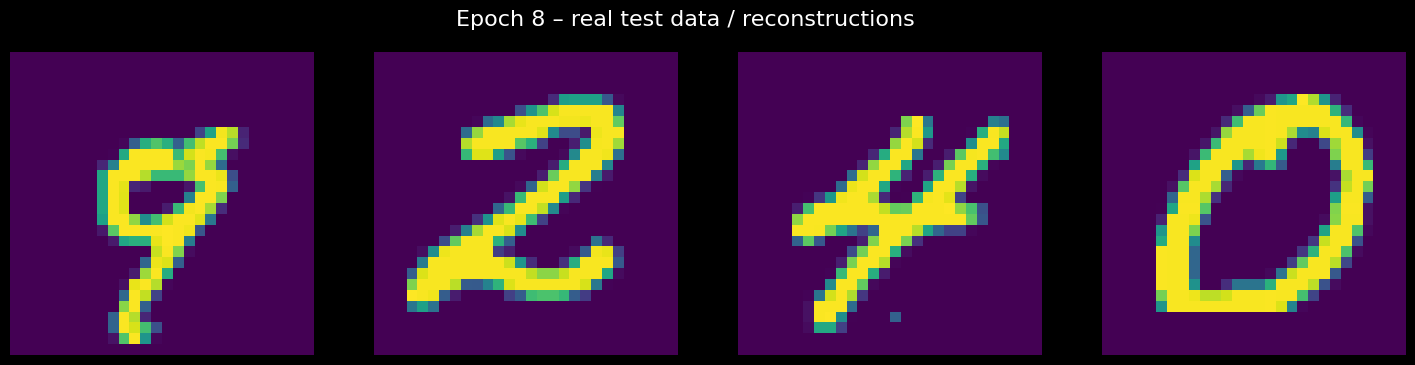

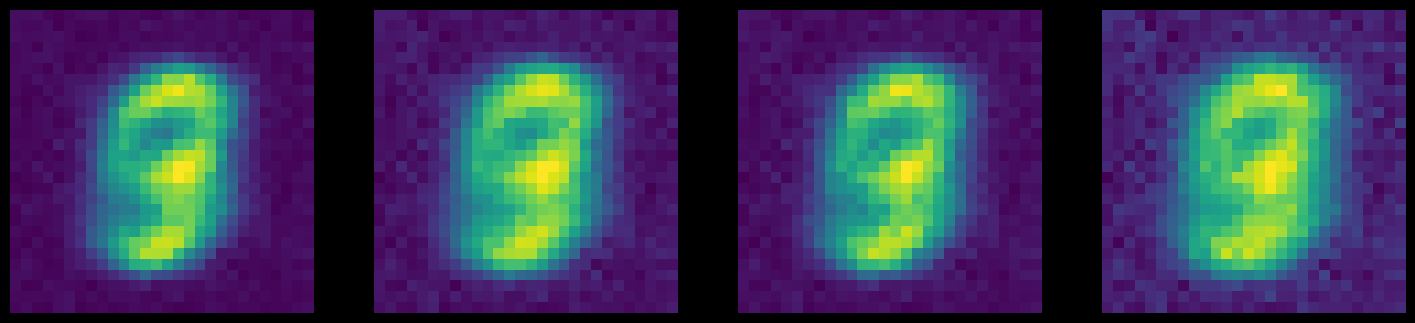

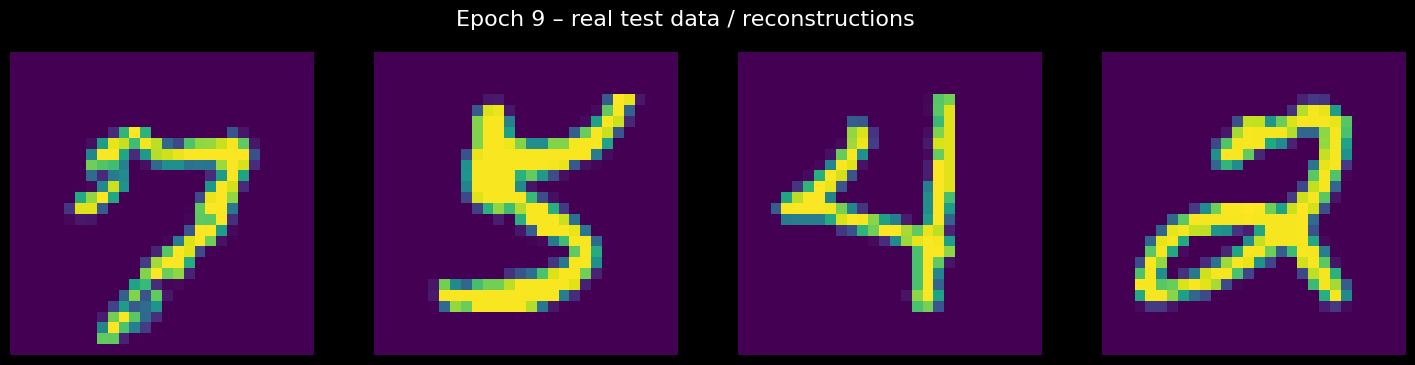

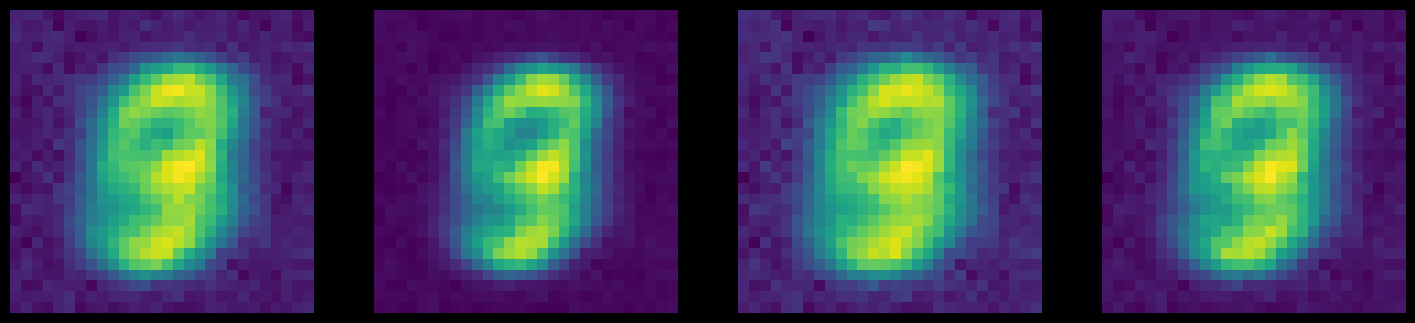

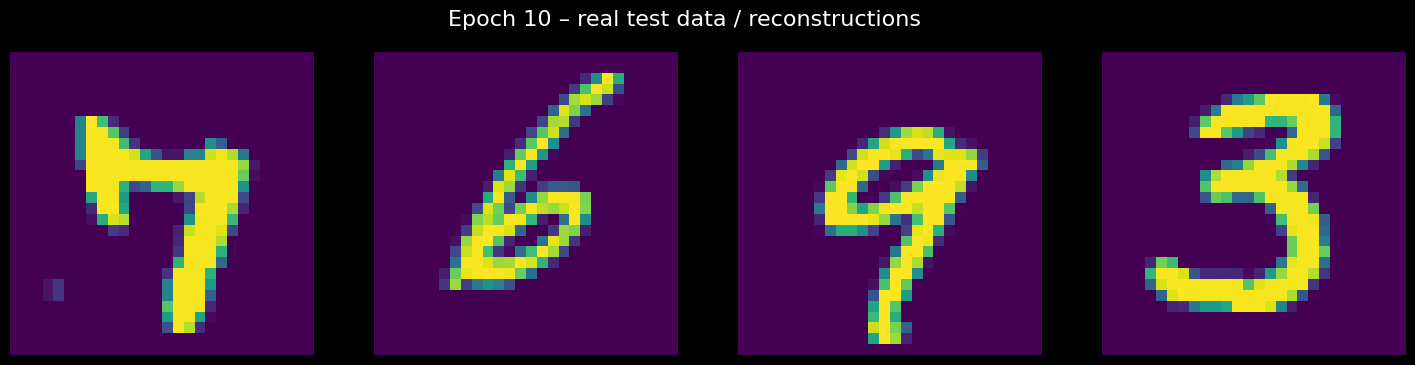

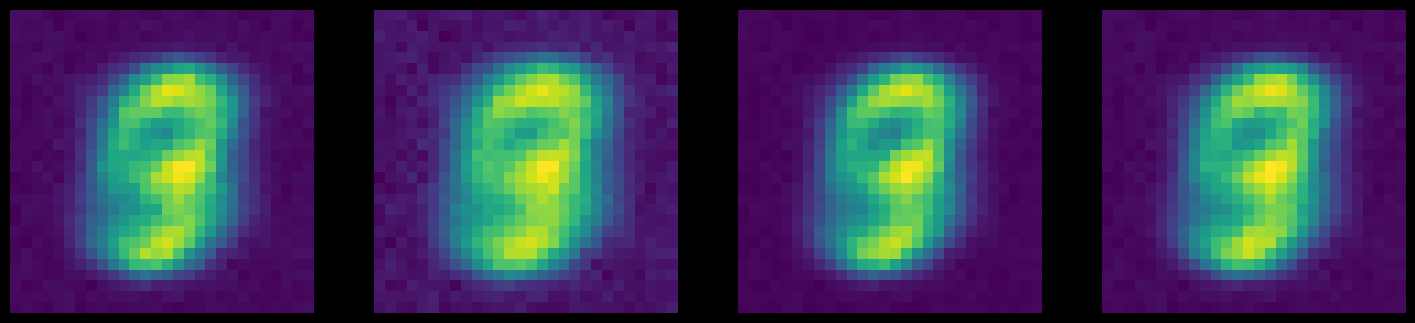

In [20]:
# Test Adadelta
optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
experiment(optimizer)

Coefficient: 0.5
====> Test set loss: 532.6390
====> Epoch: 1 Average loss: 210.3992
====> Test set loss: 151.7779
====> Epoch: 2 Average loss: 144.6799
====> Test set loss: 125.0712
====> Epoch: 3 Average loss: 126.7959
====> Test set loss: 113.8403
====> Epoch: 4 Average loss: 118.3335
====> Test set loss: 106.9723
====> Epoch: 5 Average loss: 112.7076
====> Test set loss: 102.7204
====> Epoch: 6 Average loss: 108.9791
====> Test set loss: 99.7104
====> Epoch: 7 Average loss: 106.2540
====> Test set loss: 97.3031
====> Epoch: 8 Average loss: 104.1240
====> Test set loss: 95.2846
====> Epoch: 9 Average loss: 102.3940
====> Test set loss: 93.8374
====> Epoch: 10 Average loss: 100.9554
====> Test set loss: 92.6330


<ipython-input-2-86cf5db85052>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


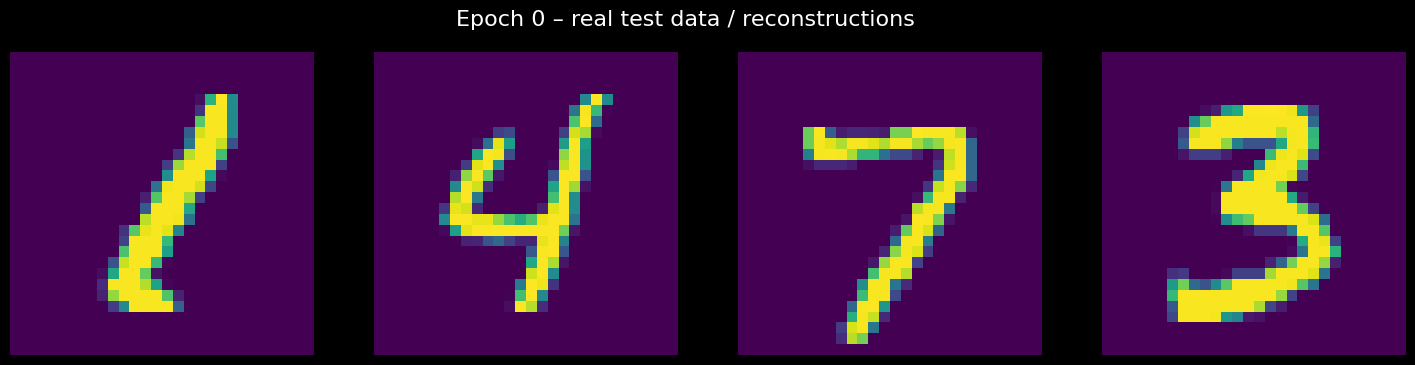

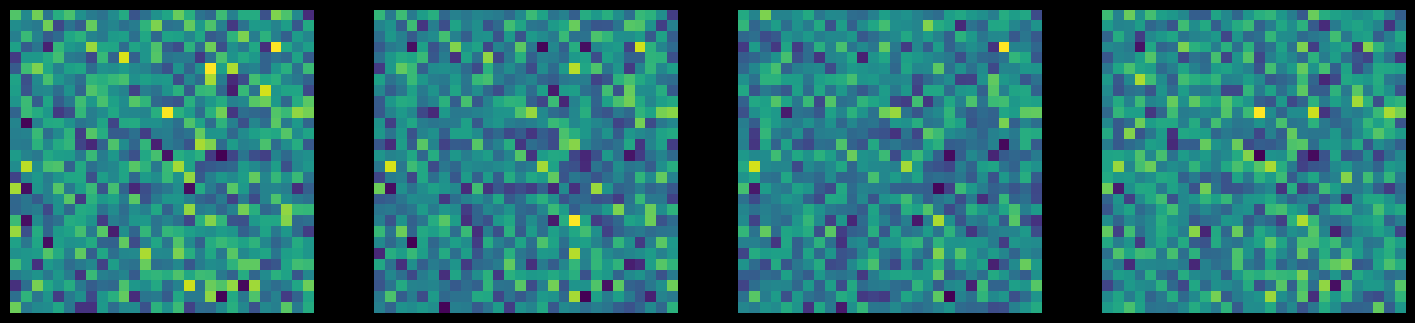

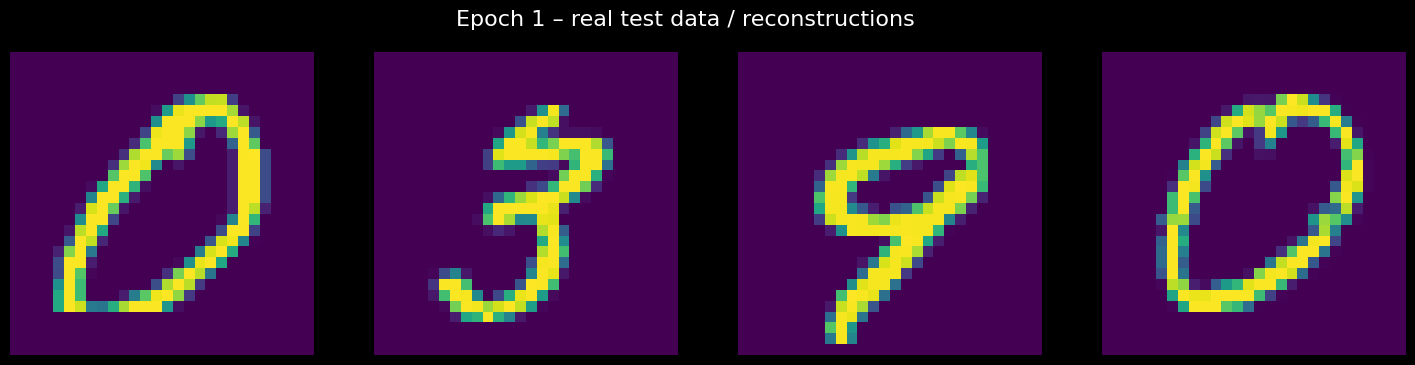

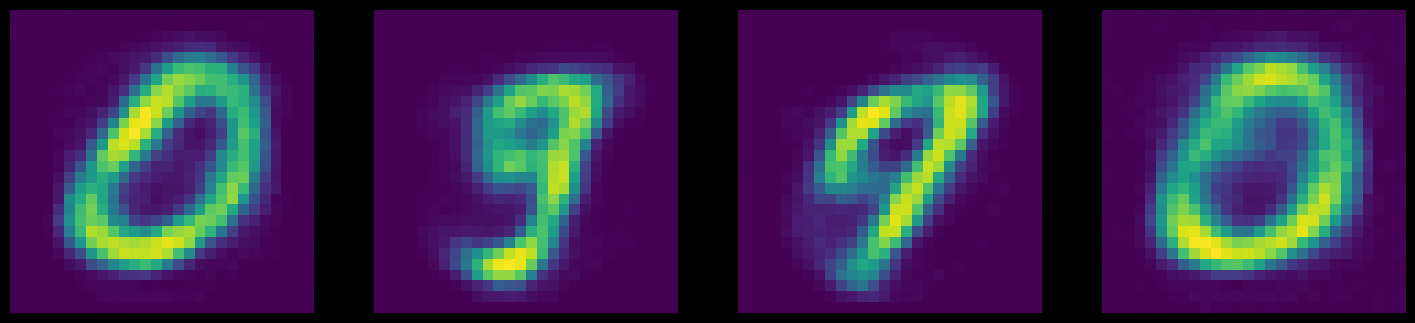

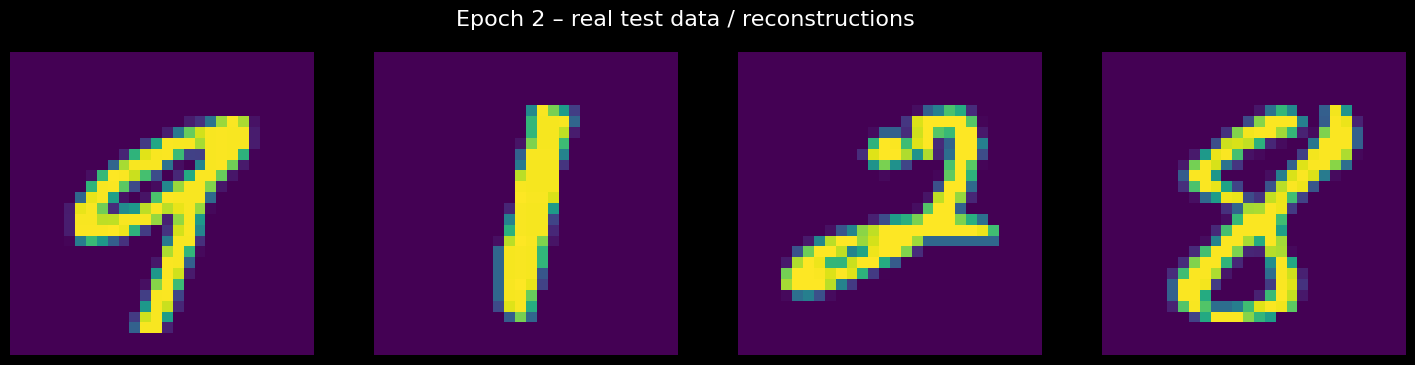

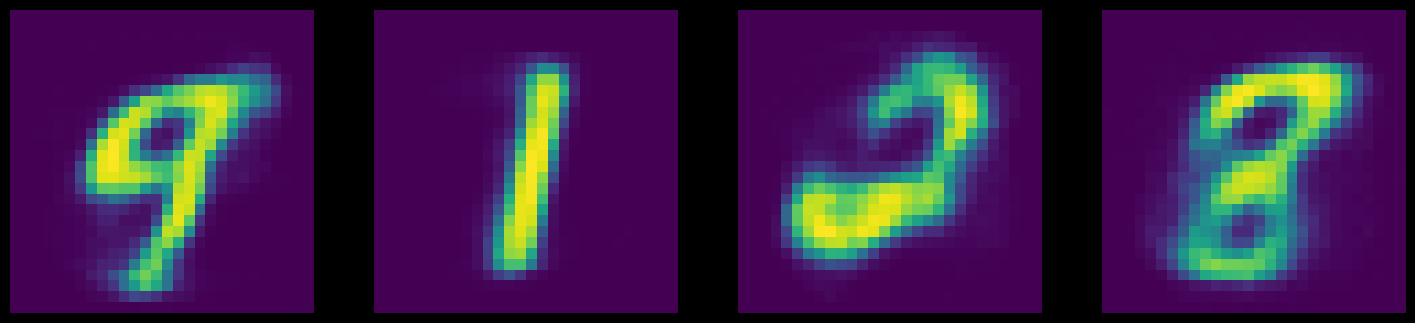

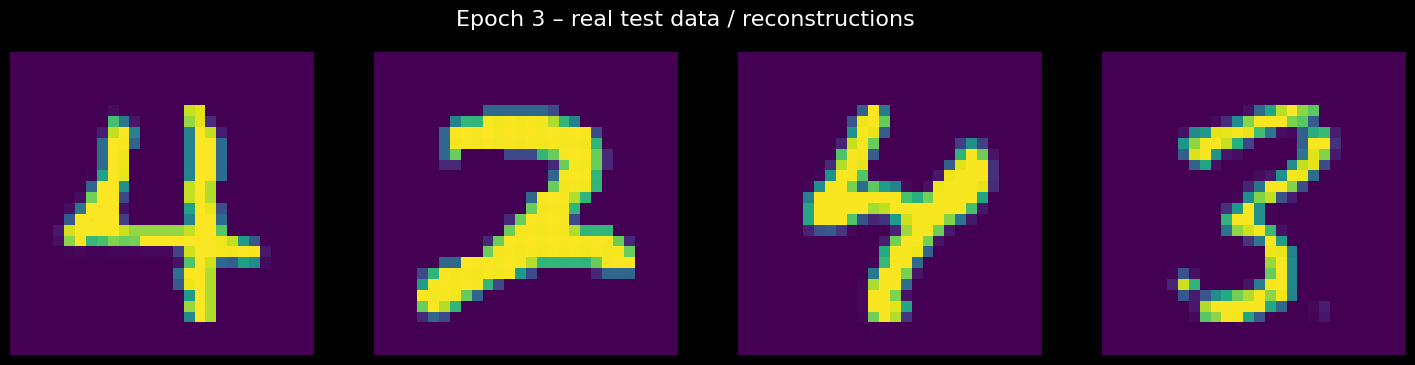

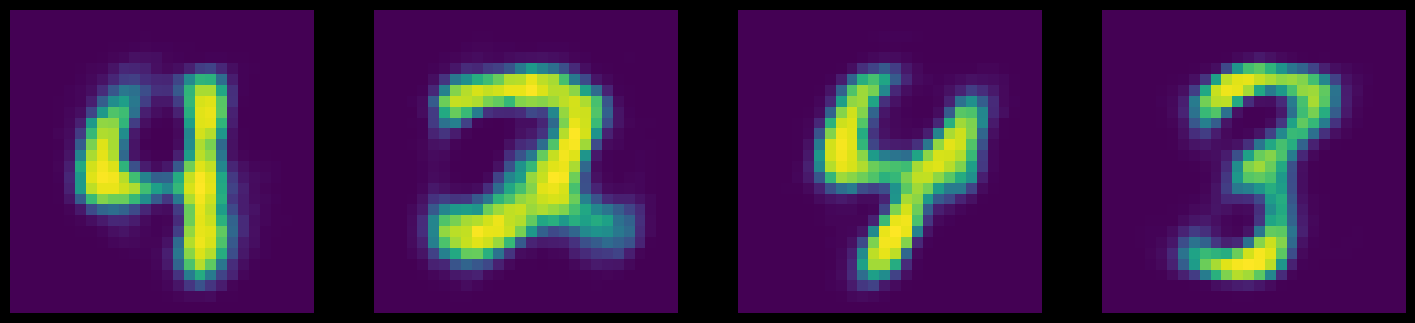

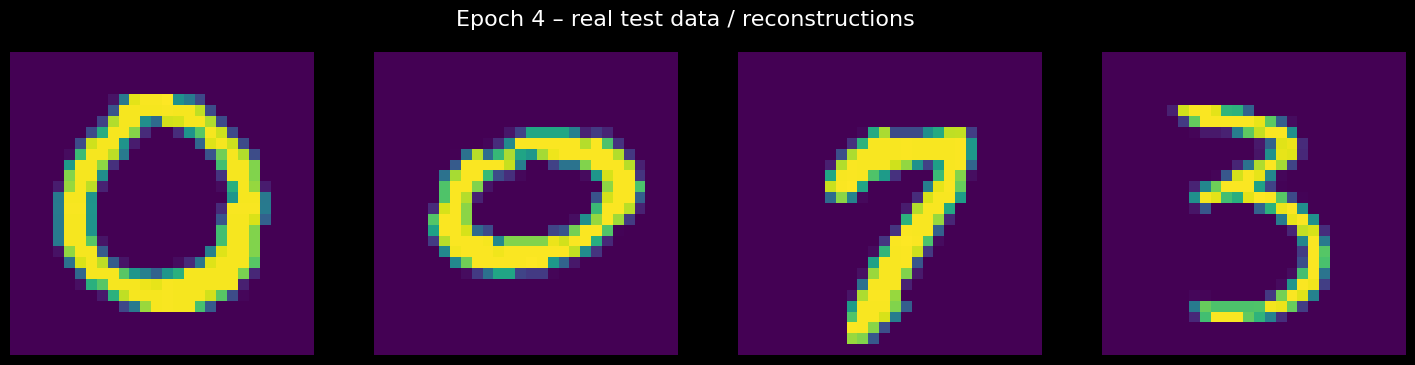

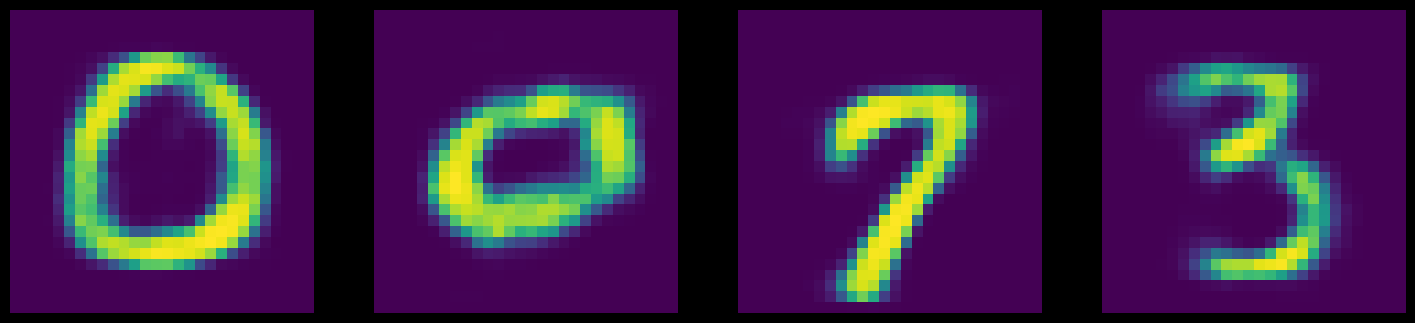

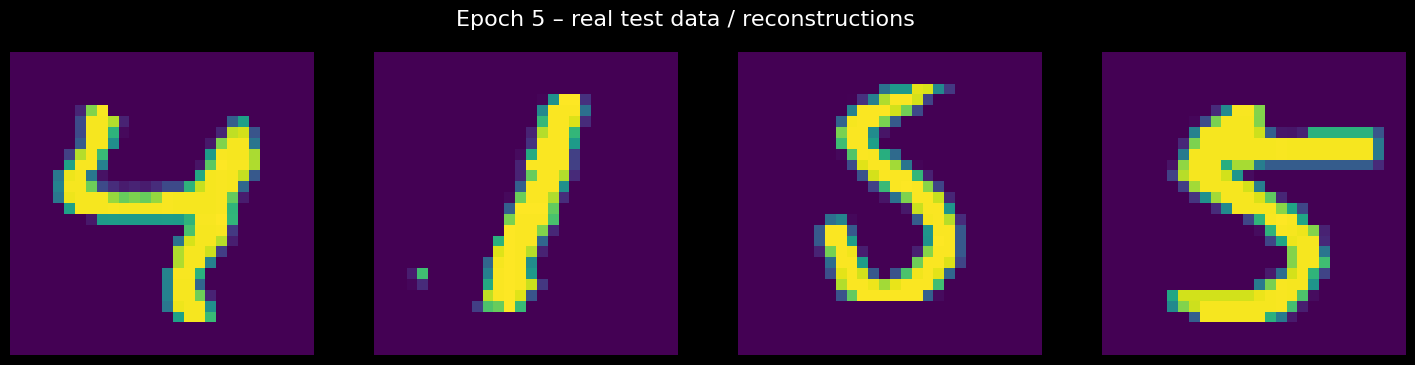

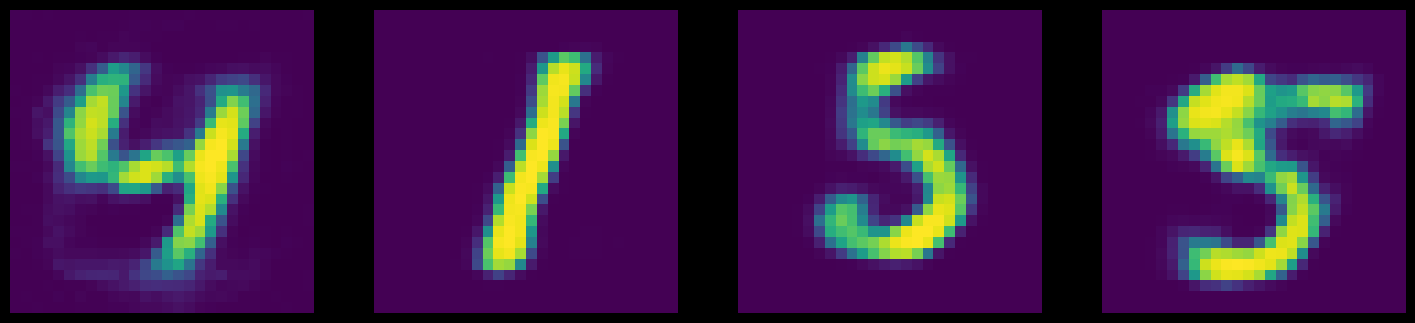

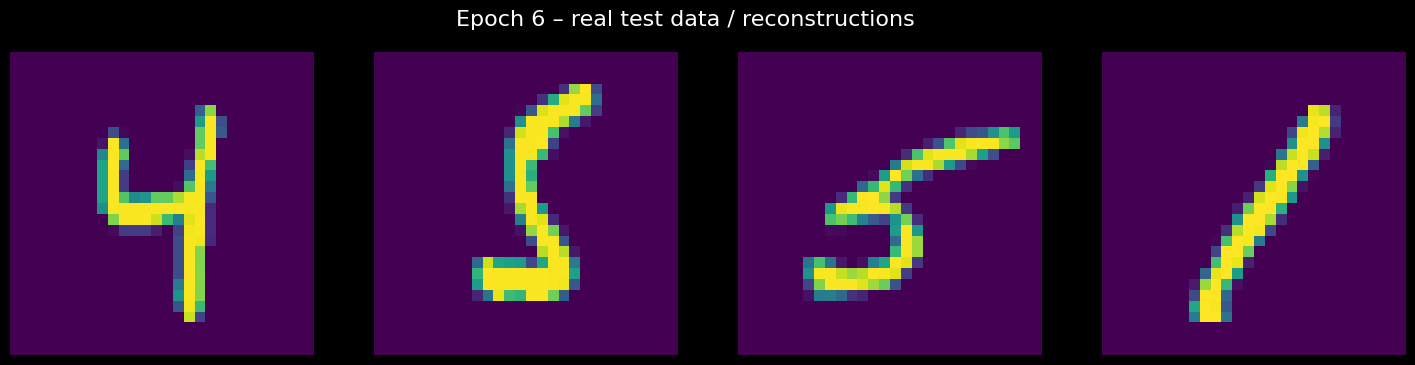

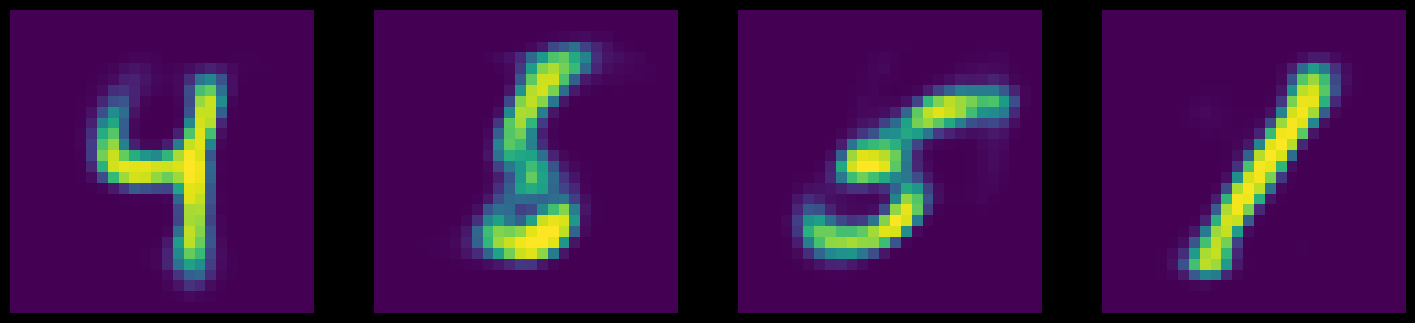

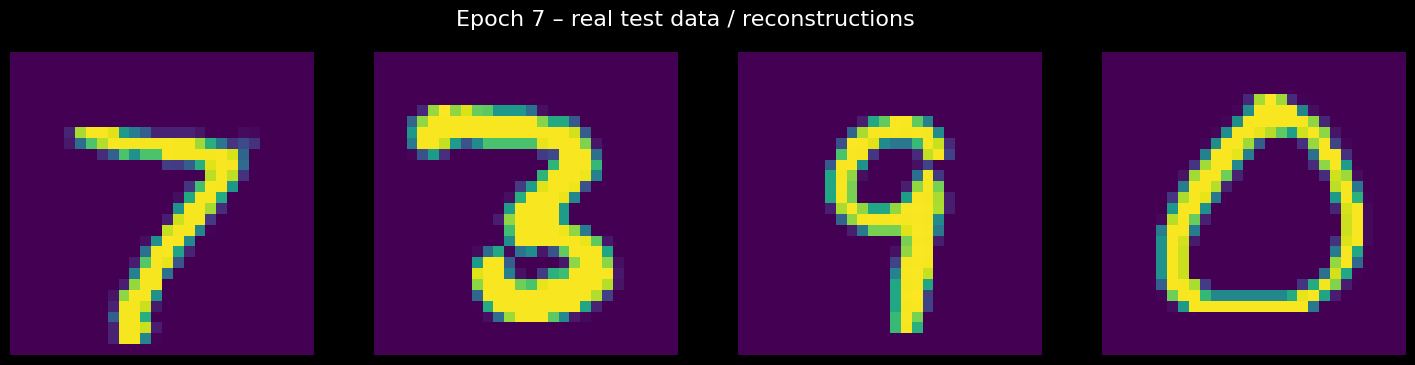

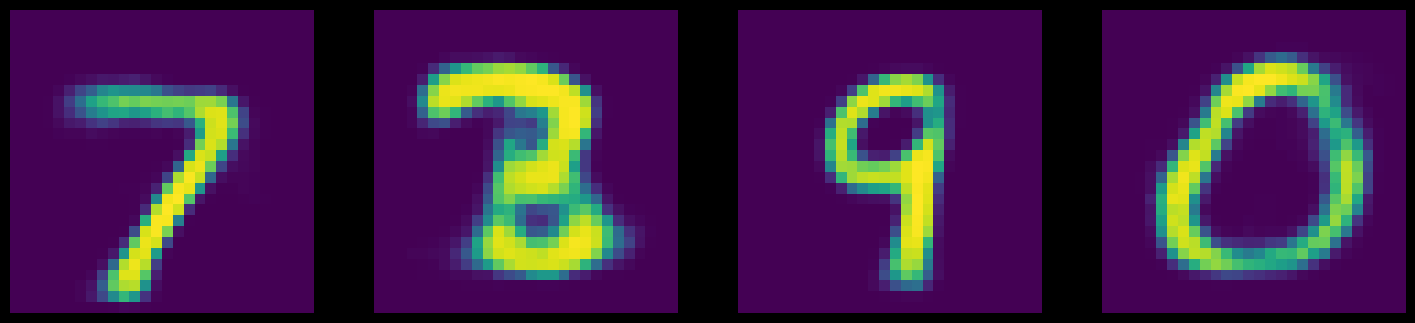

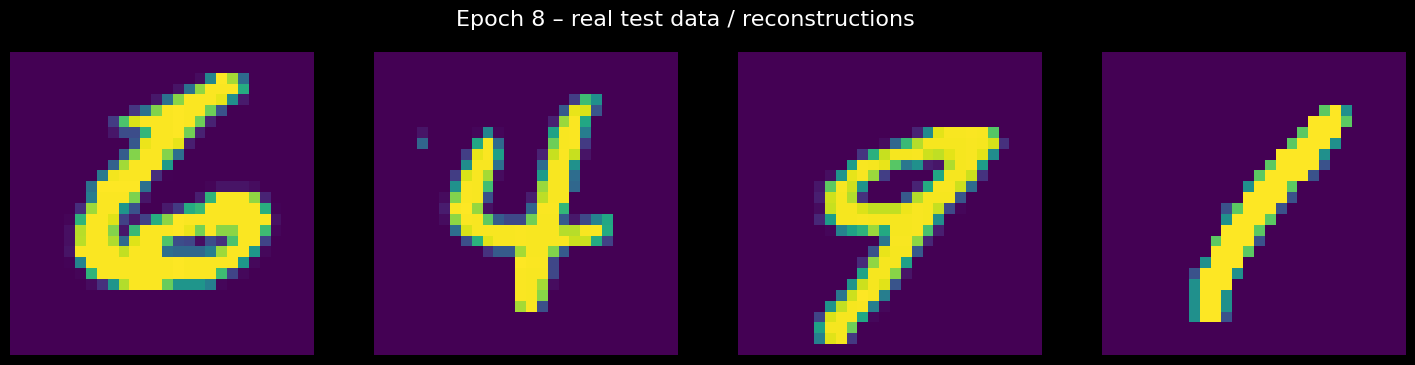

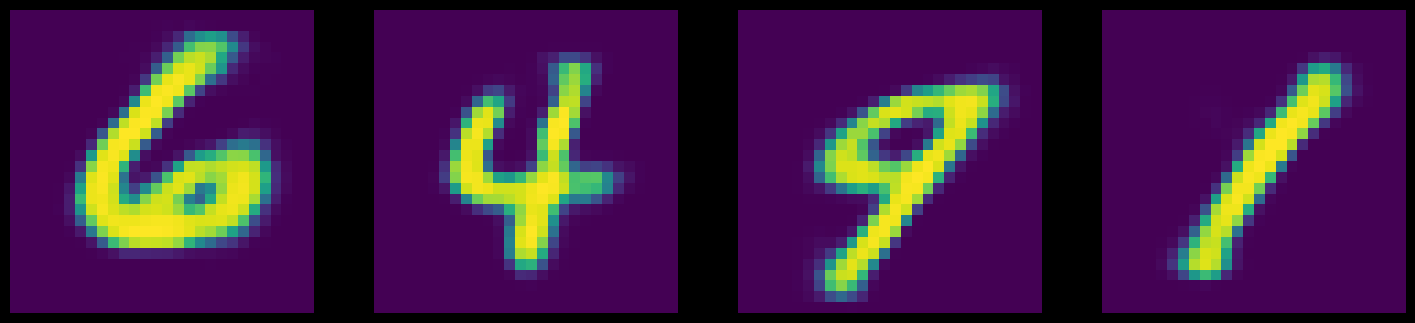

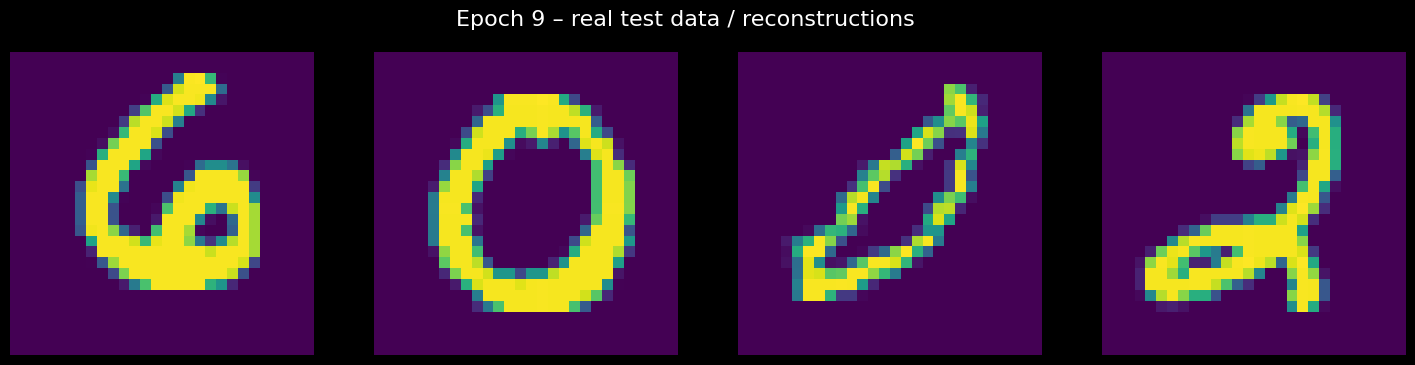

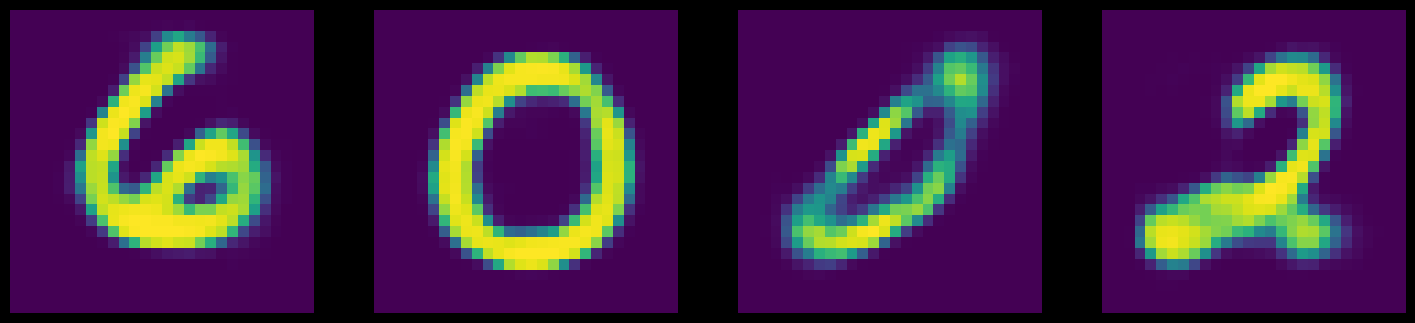

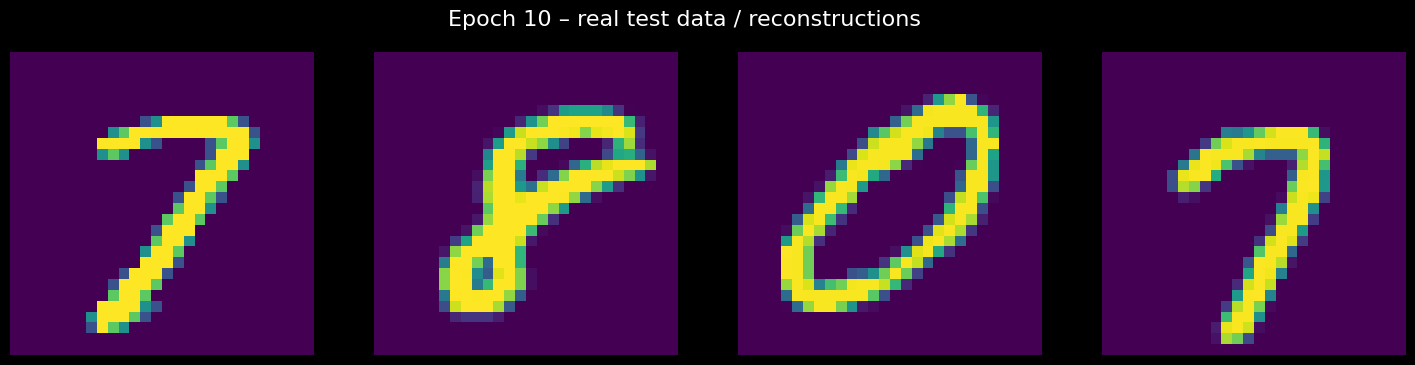

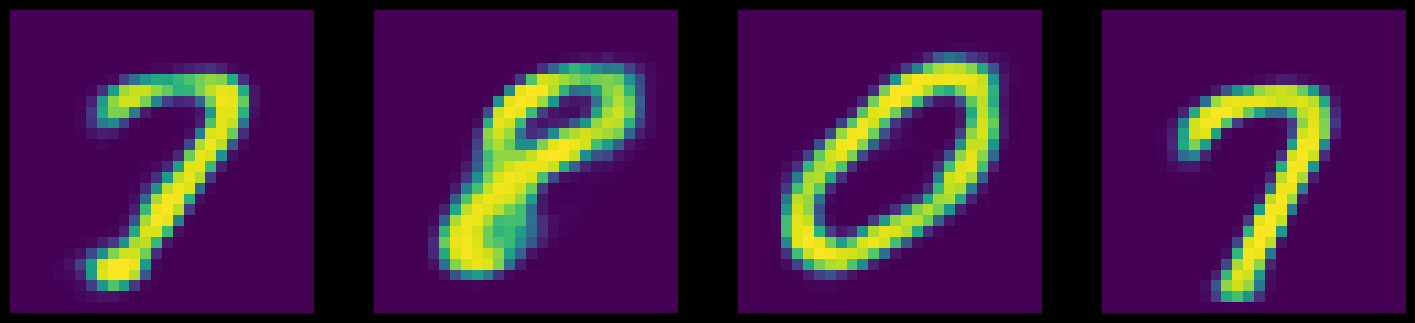

In [21]:
# Test Adamax
optimizer = keras.optimizers.Adamax(learning_rate=learning_rate)
experiment(optimizer)

Coefficient: 0.5
====> Test set loss: 532.4686
====> Epoch: 1 Average loss: 243.5428
====> Test set loss: 195.2866
====> Epoch: 2 Average loss: 189.2105
====> Test set loss: 171.7839
====> Epoch: 3 Average loss: 172.9265
====> Test set loss: 160.2104
====> Epoch: 4 Average loss: 164.1083
====> Test set loss: 153.3044
====> Epoch: 5 Average loss: 158.5344
====> Test set loss: 148.6028
====> Epoch: 6 Average loss: 154.4392
====> Test set loss: 144.8654
====> Epoch: 7 Average loss: 151.0653
====> Test set loss: 141.7265
====> Epoch: 8 Average loss: 148.2445
====> Test set loss: 139.0757
====> Epoch: 9 Average loss: 145.8081
====> Test set loss: 136.7406
====> Epoch: 10 Average loss: 143.6182
====> Test set loss: 134.6662


<ipython-input-2-86cf5db85052>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


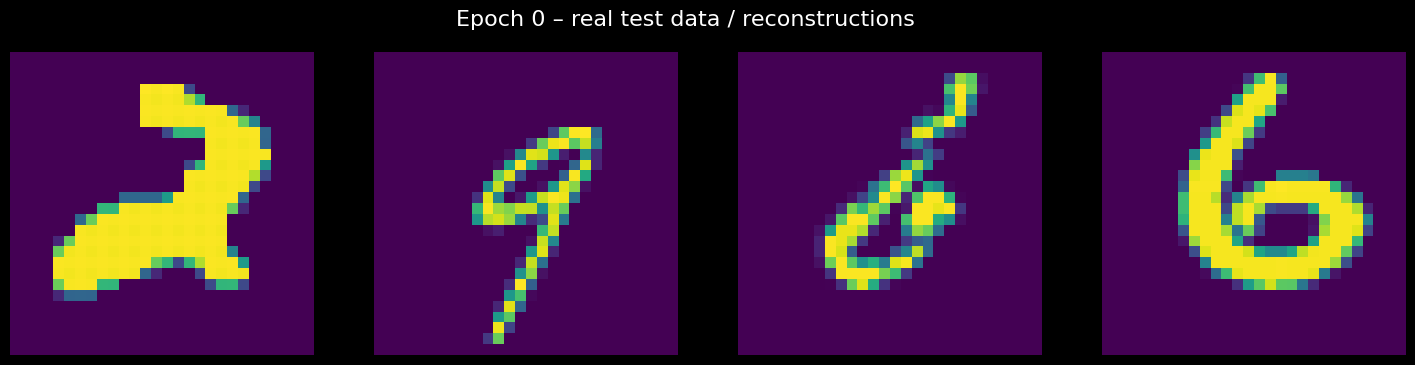

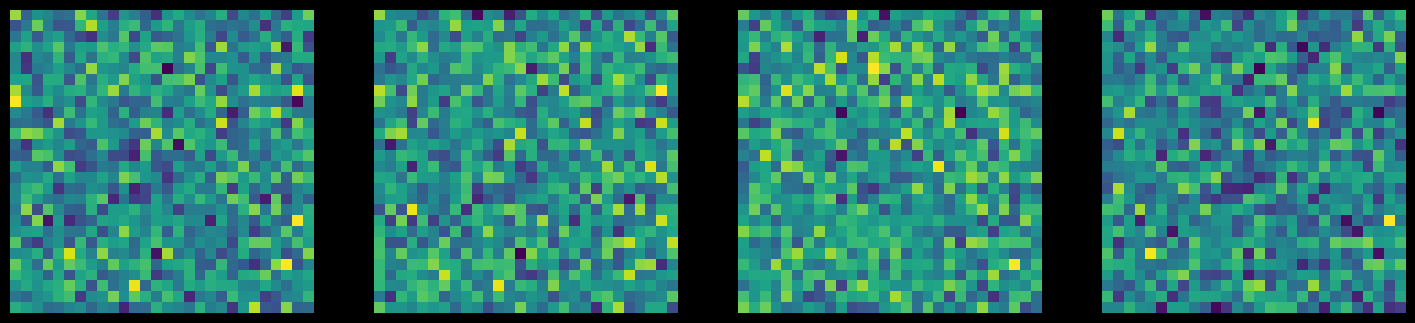

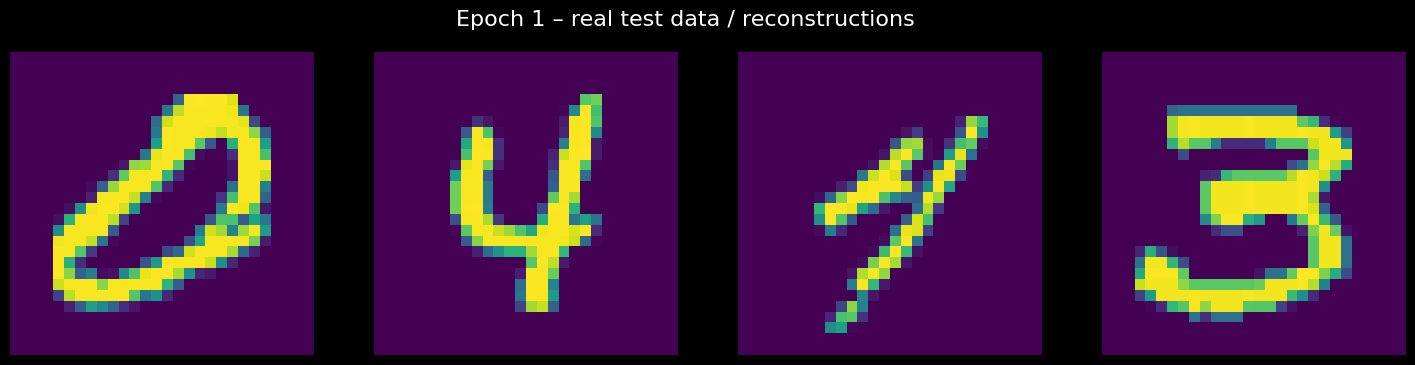

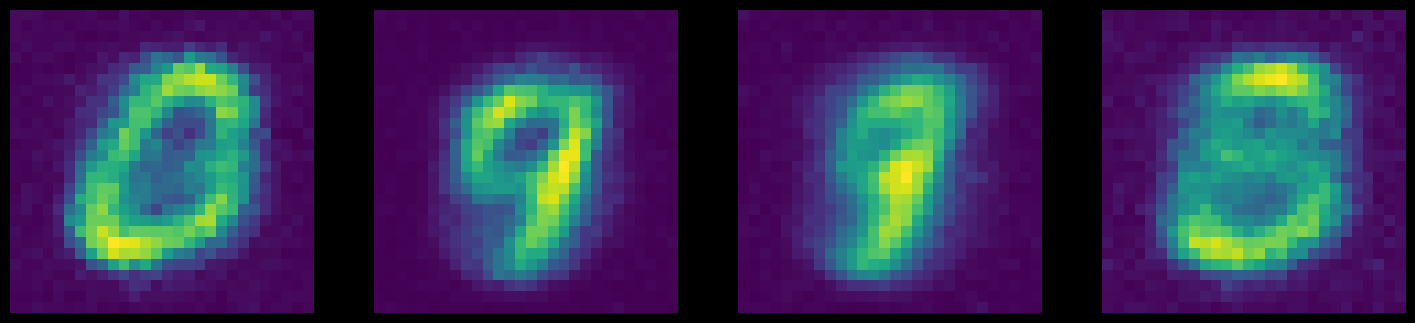

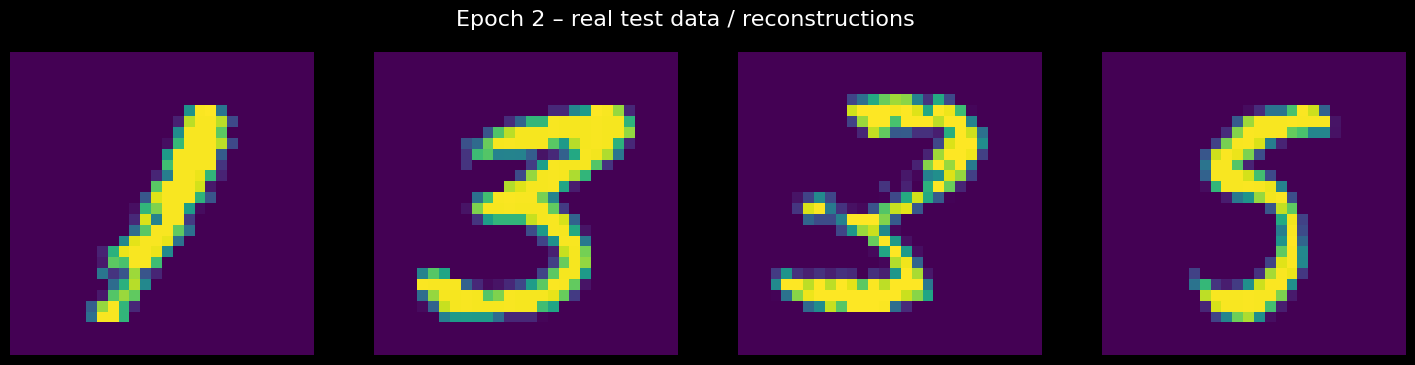

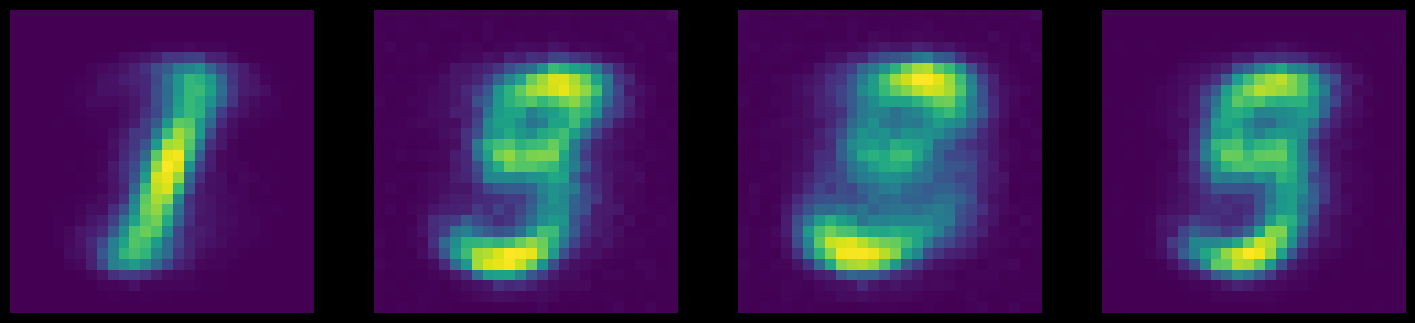

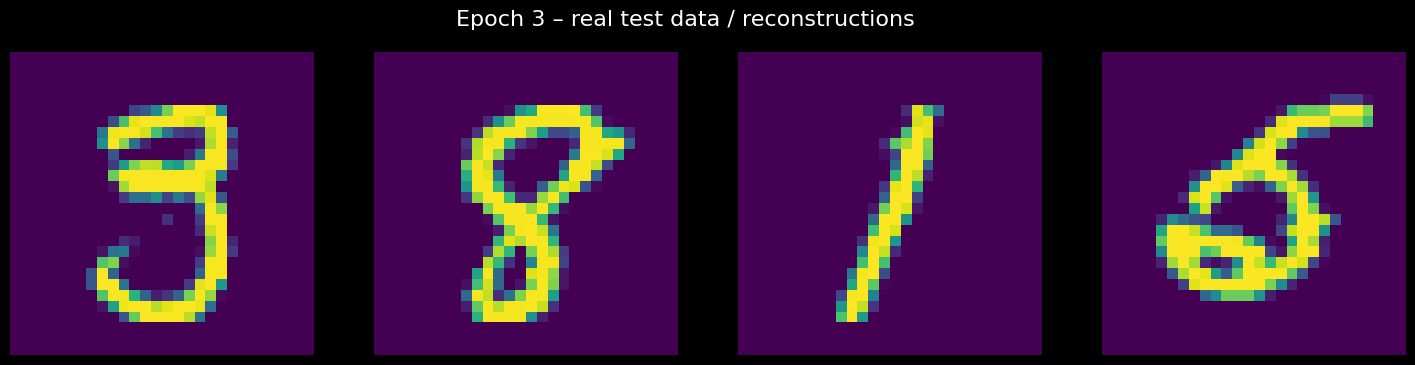

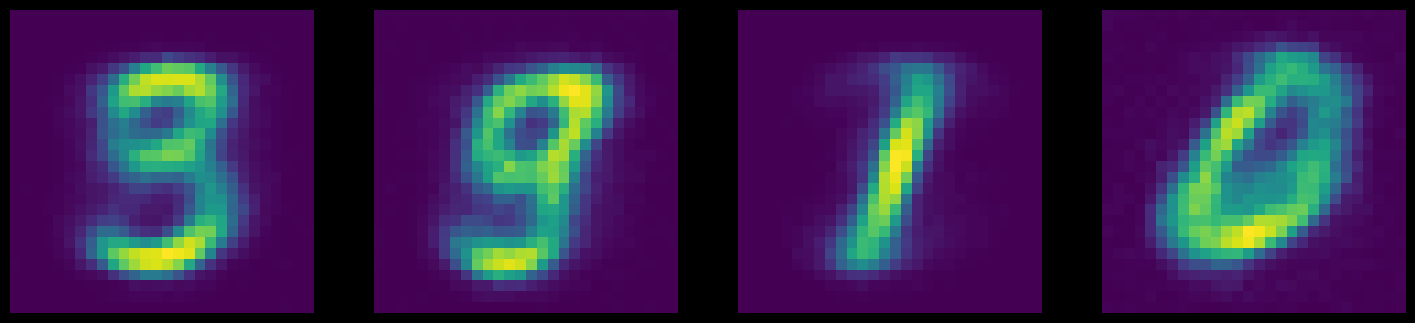

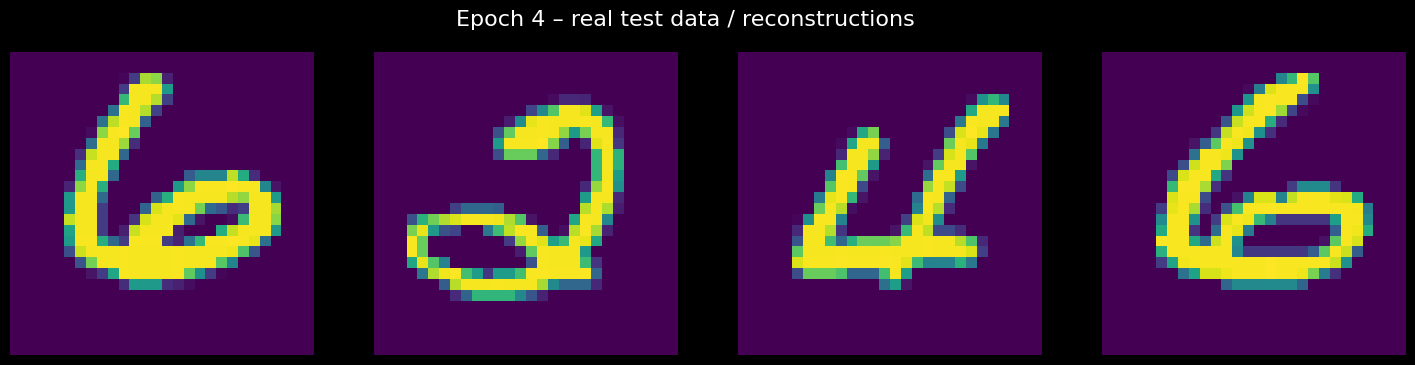

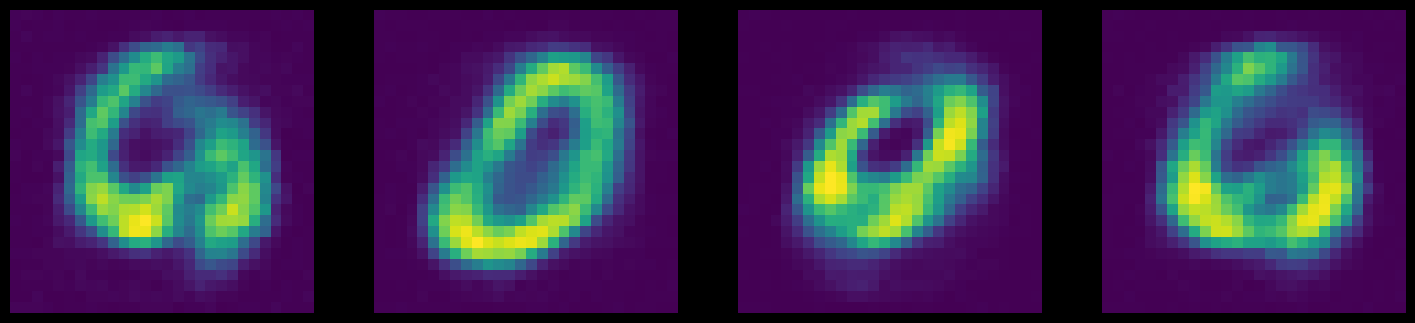

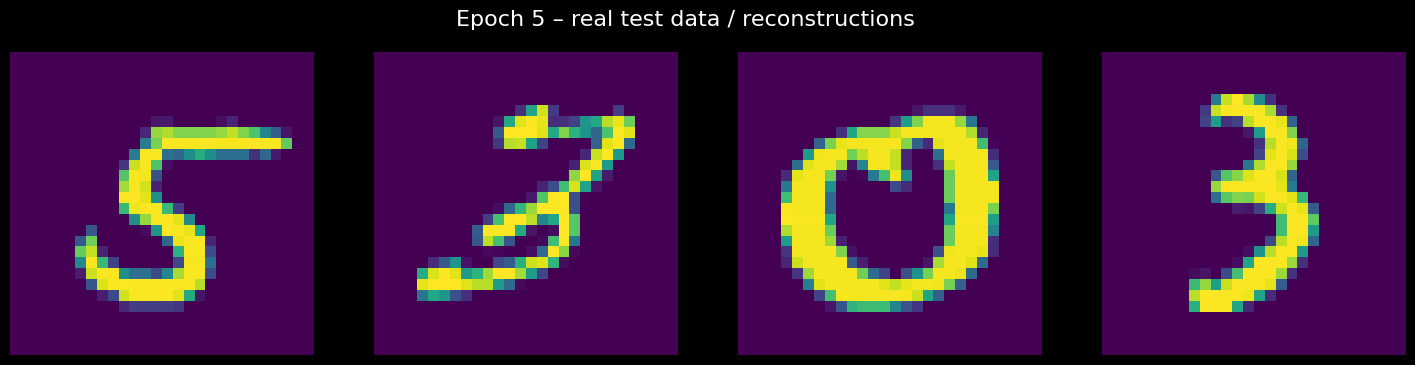

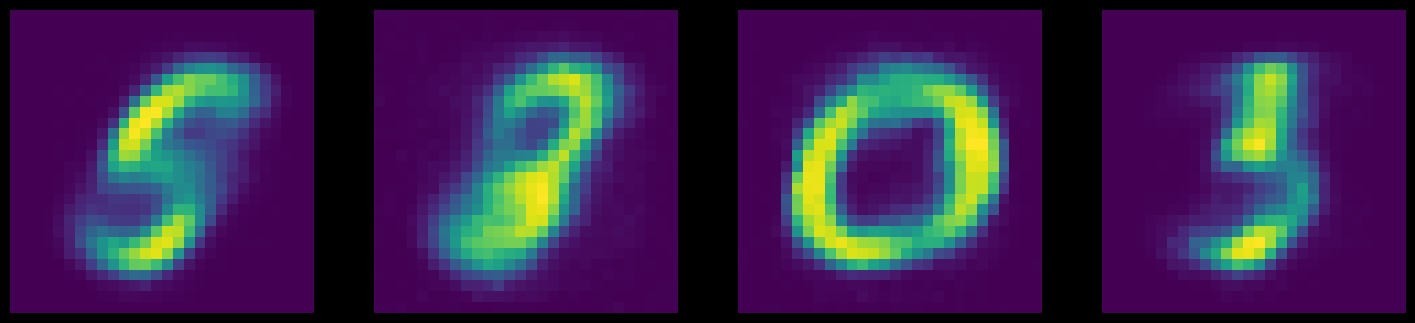

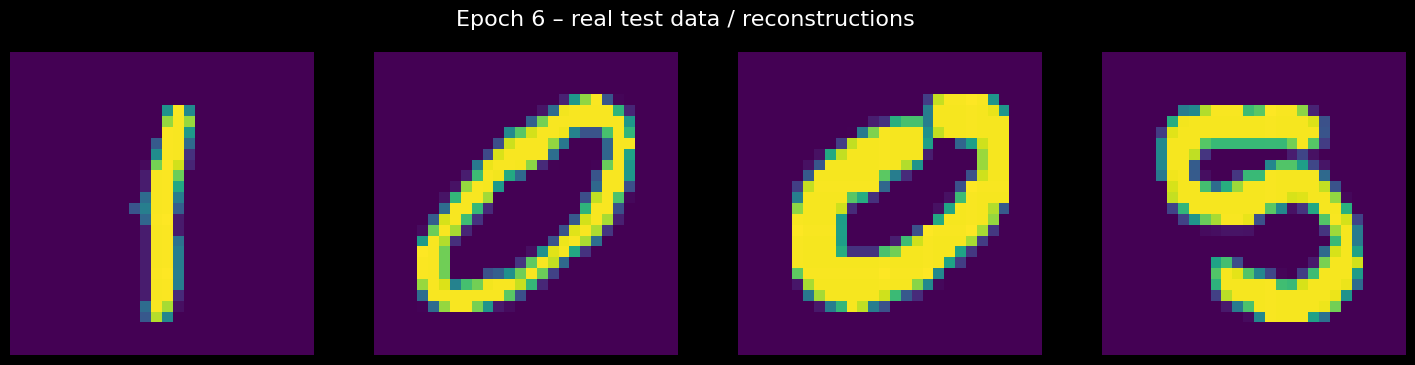

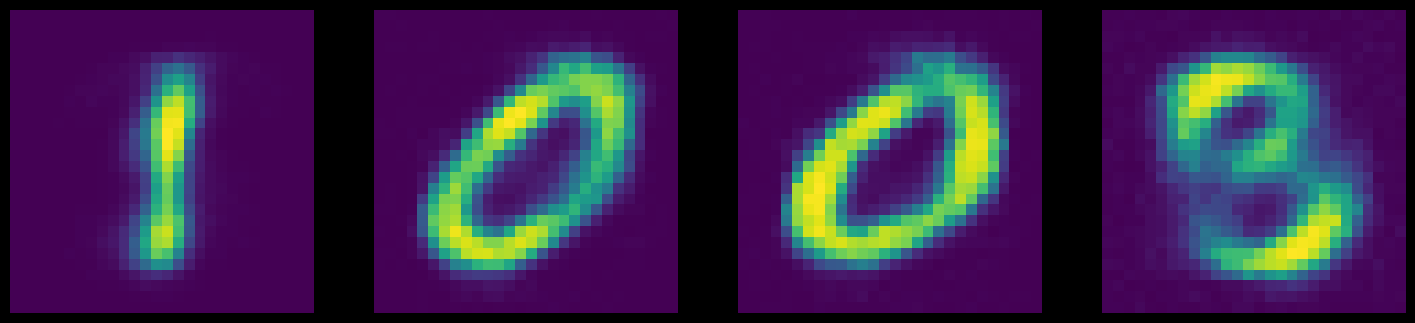

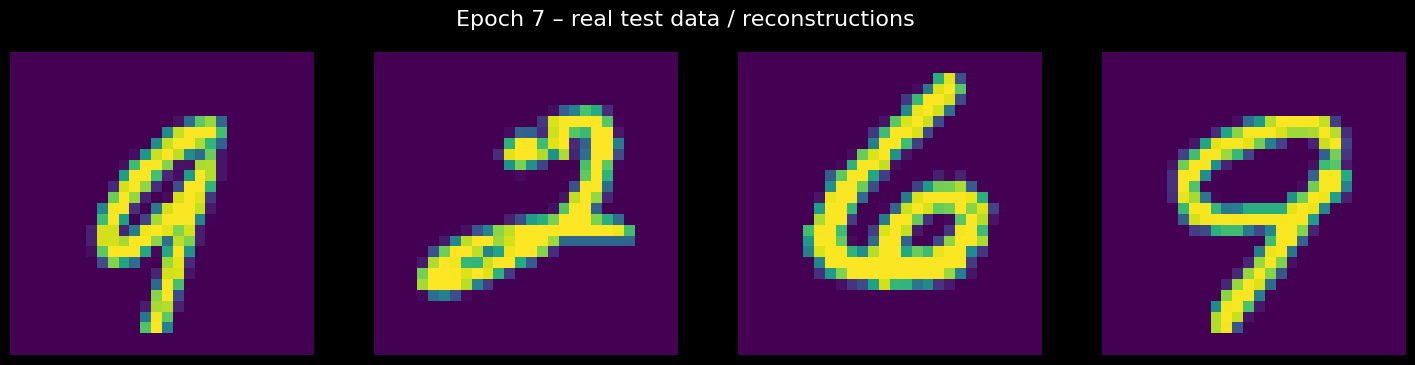

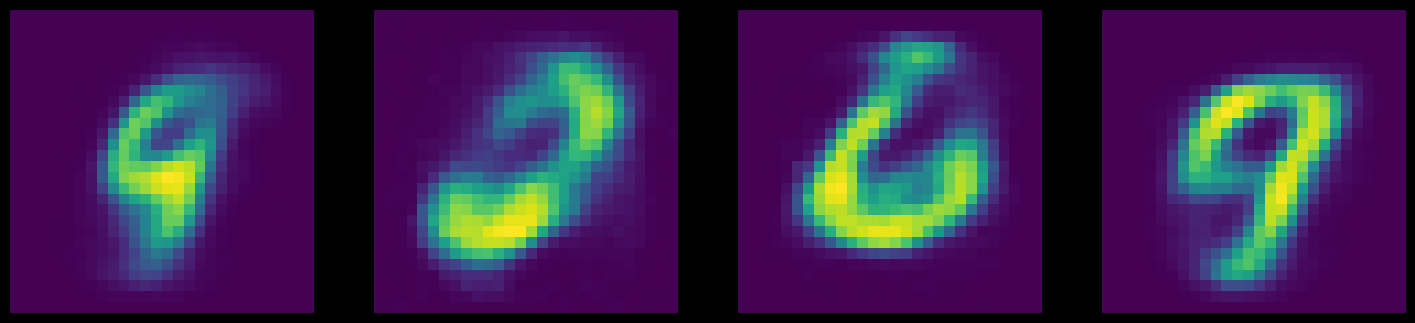

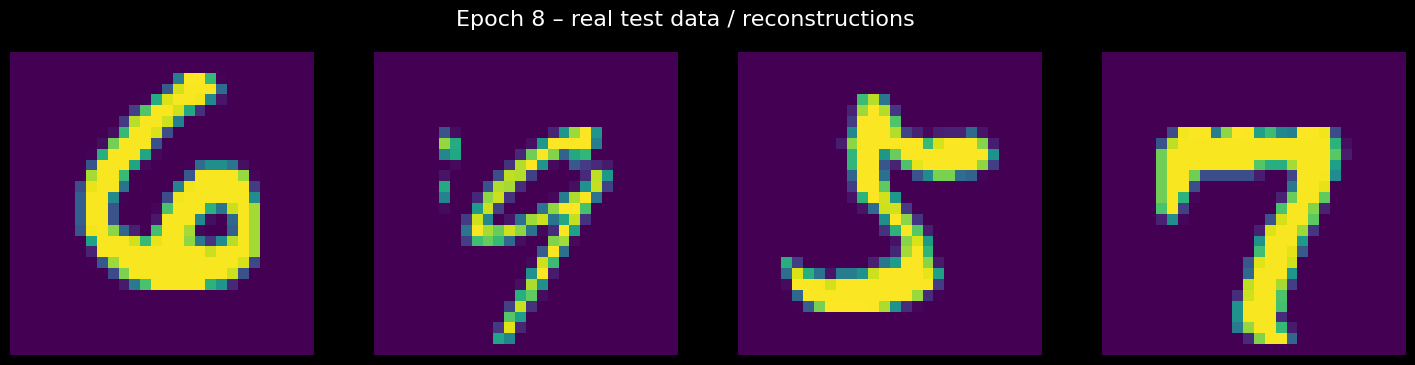

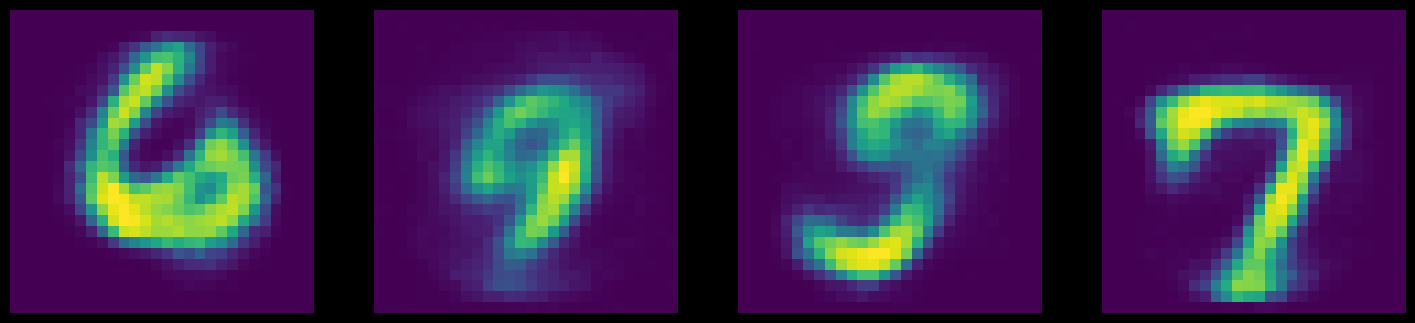

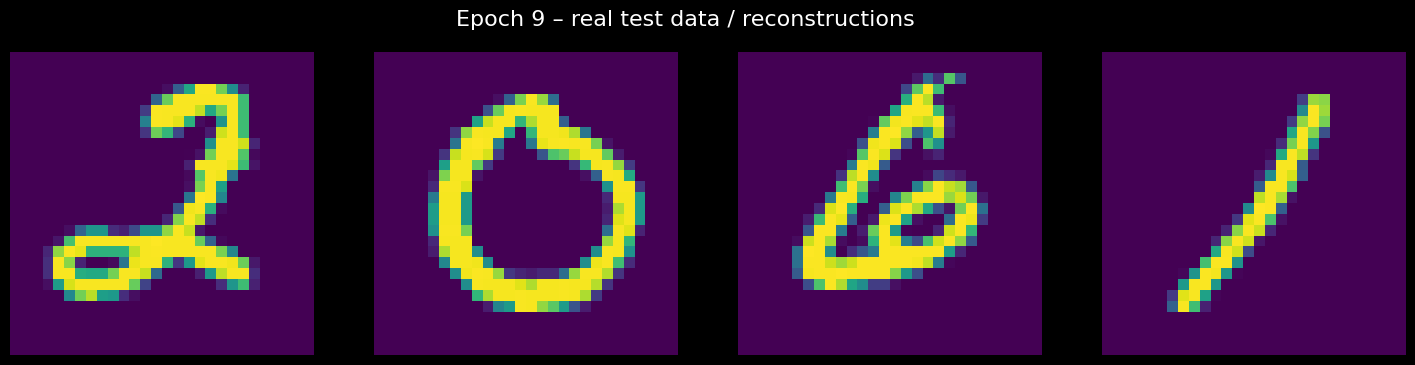

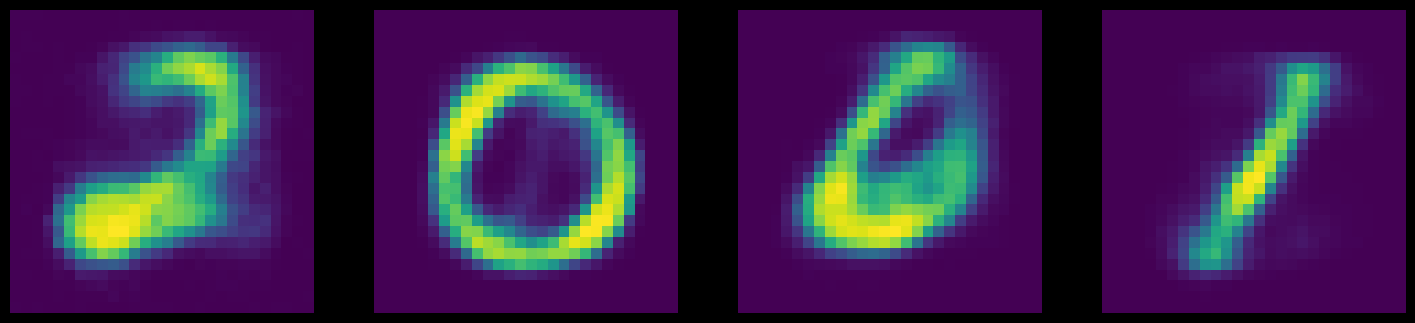

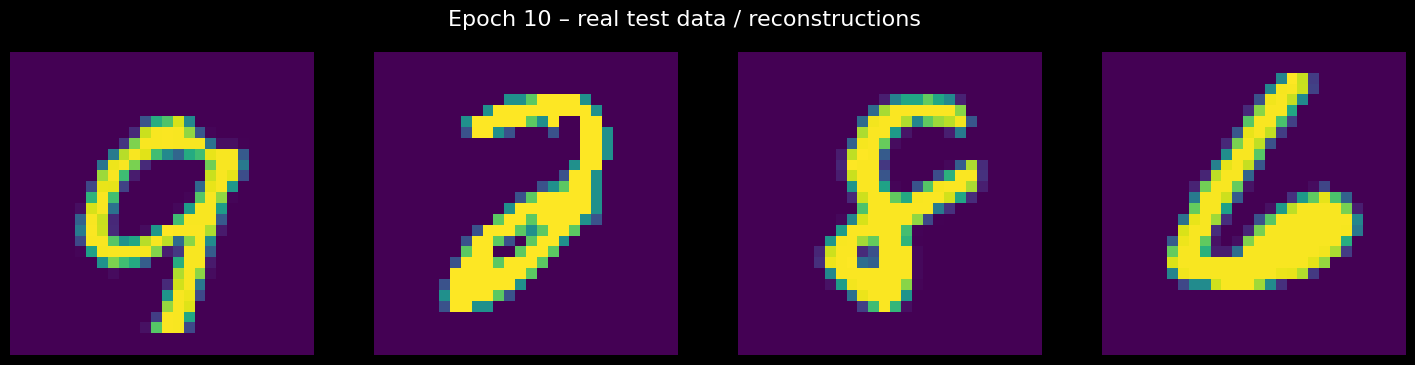

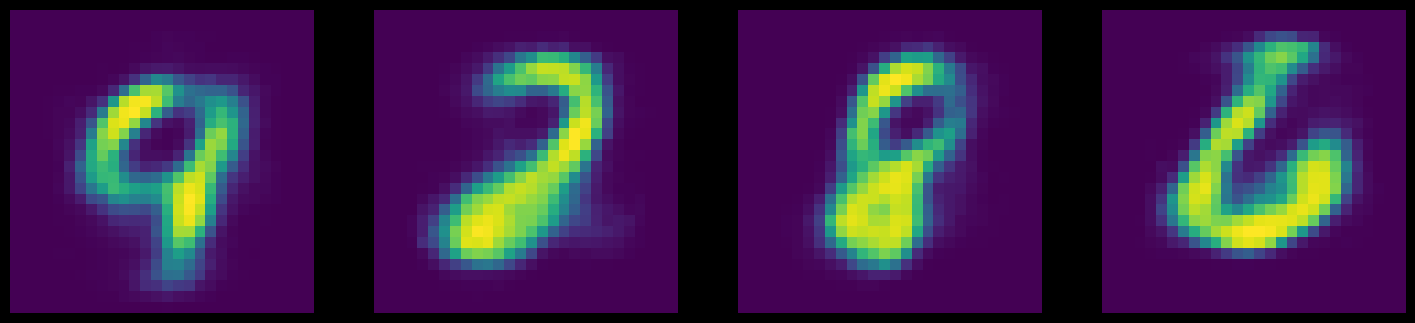

In [22]:
# Test Ftrl
optimizer = keras.optimizers.Ftrl(learning_rate=learning_rate)
experiment(optimizer)

Coefficient: 0.5
====> Test set loss: 531.8077
====> Epoch: 1 Average loss: 166.5272
====> Test set loss: 114.4064
====> Epoch: 2 Average loss: 112.4131
====> Test set loss: 97.0958
====> Epoch: 3 Average loss: 102.3185
====> Test set loss: 91.6515
====> Epoch: 4 Average loss: 98.4436
====> Test set loss: 89.9336
====> Epoch: 5 Average loss: 96.4210
====> Test set loss: 88.6973
====> Epoch: 6 Average loss: 95.2242
====> Test set loss: 87.2310
====> Epoch: 7 Average loss: 94.2794
====> Test set loss: 86.8893
====> Epoch: 8 Average loss: 93.5249
====> Test set loss: 86.7385
====> Epoch: 9 Average loss: 92.9946
====> Test set loss: 86.0555
====> Epoch: 10 Average loss: 92.5047
====> Test set loss: 85.8458


<ipython-input-2-86cf5db85052>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


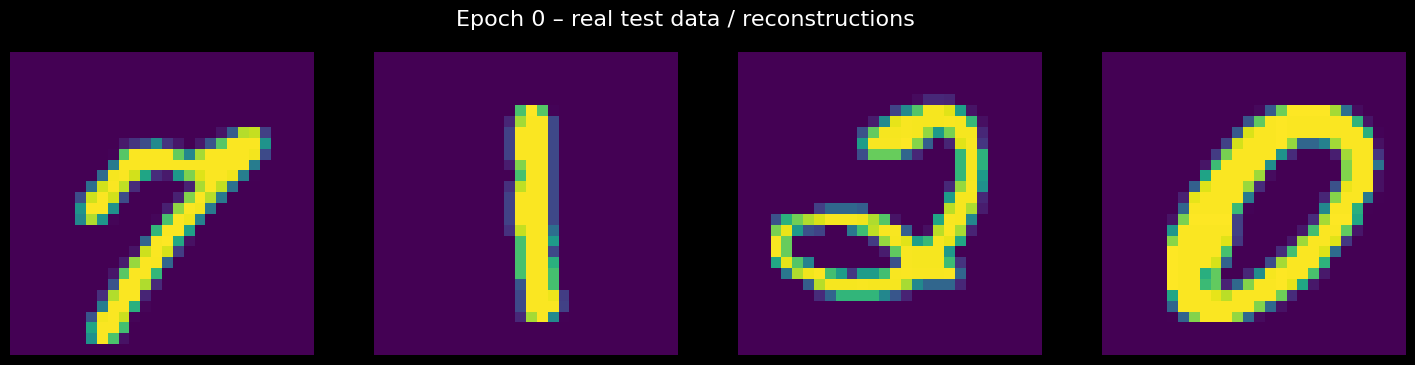

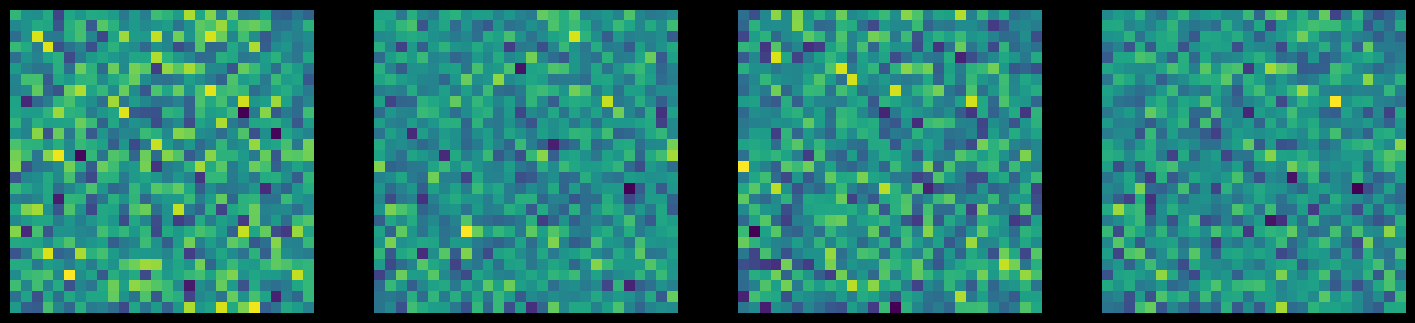

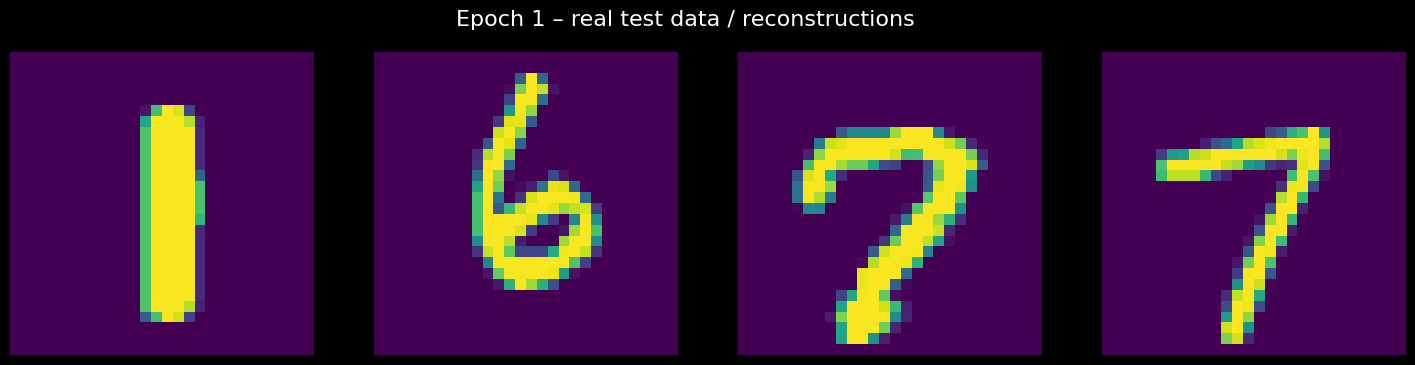

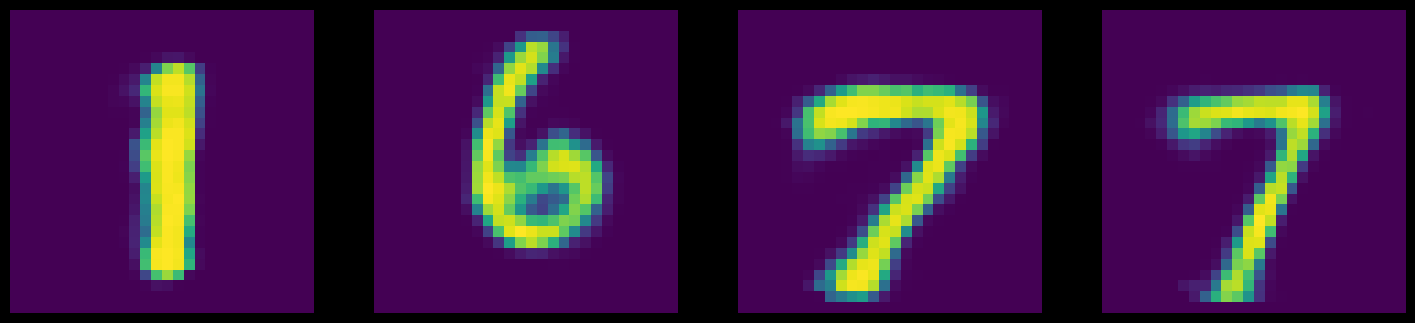

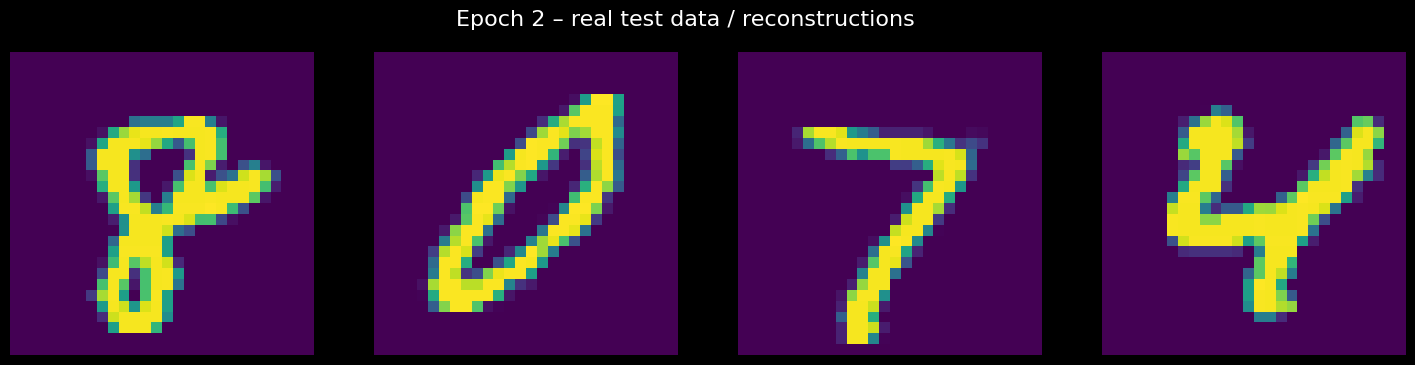

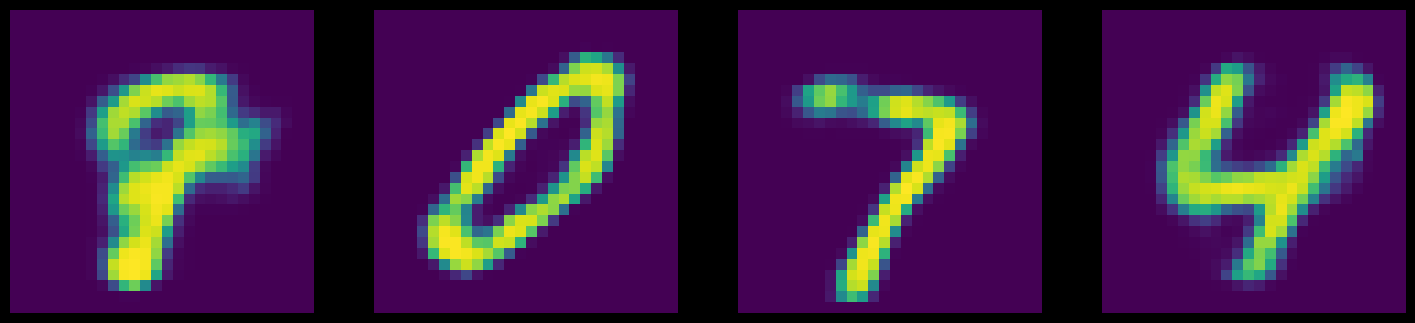

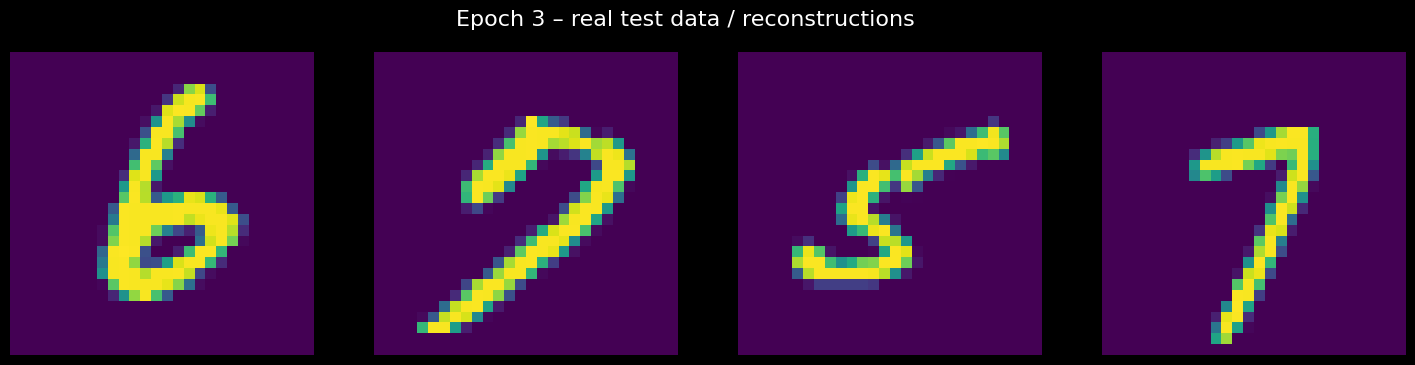

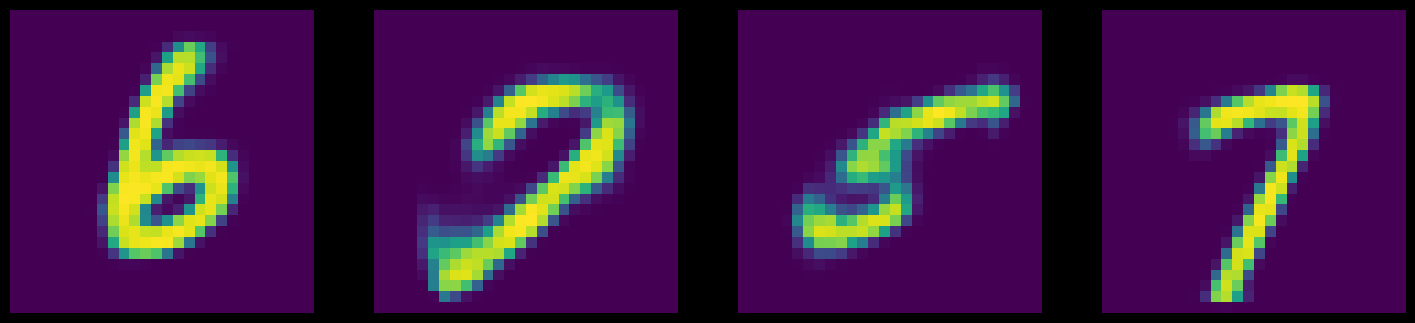

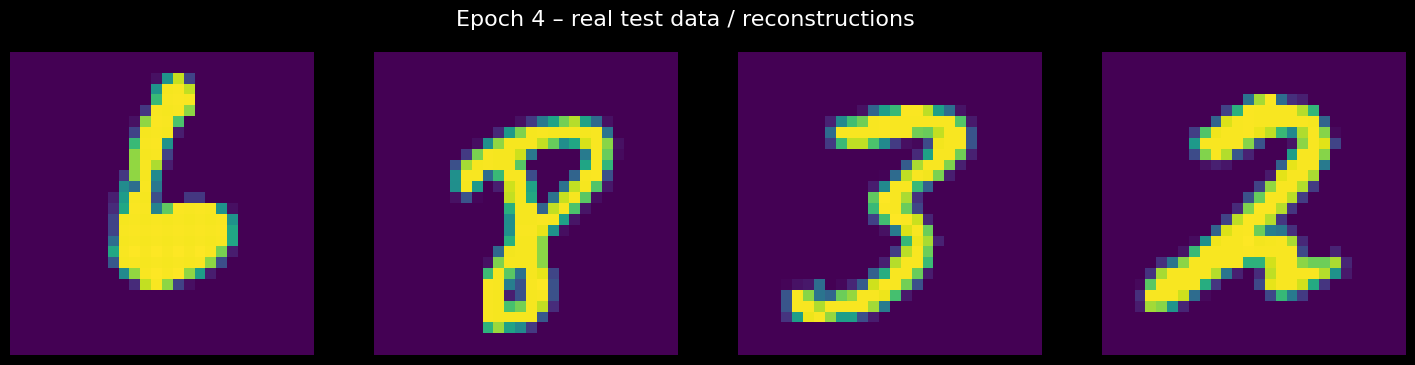

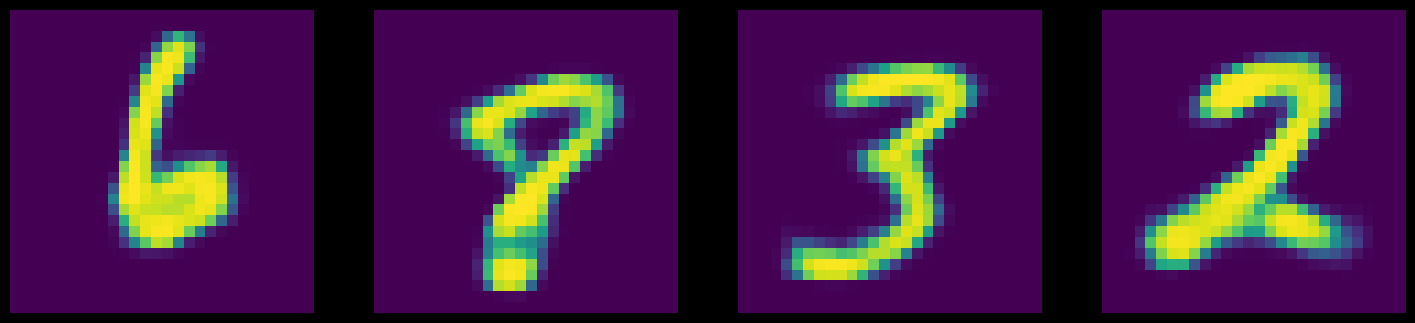

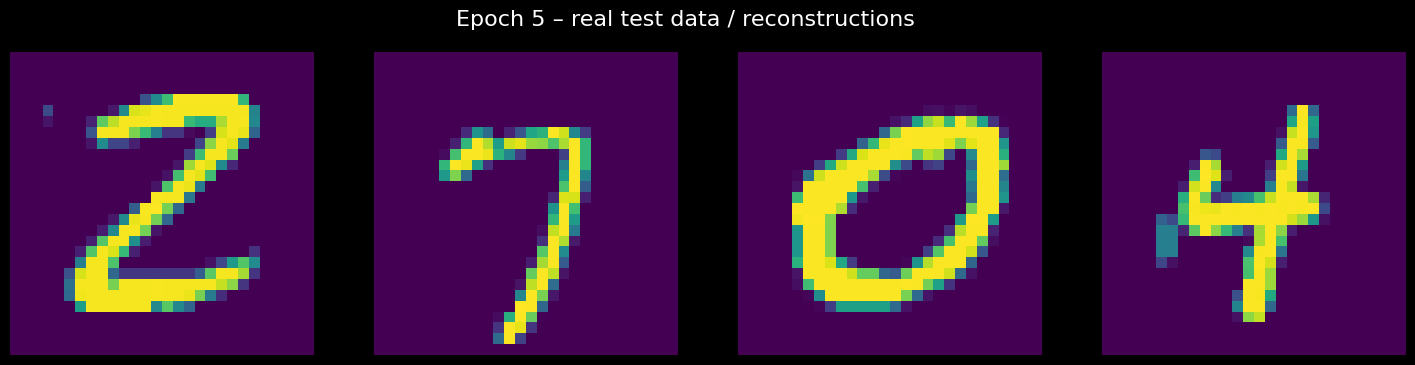

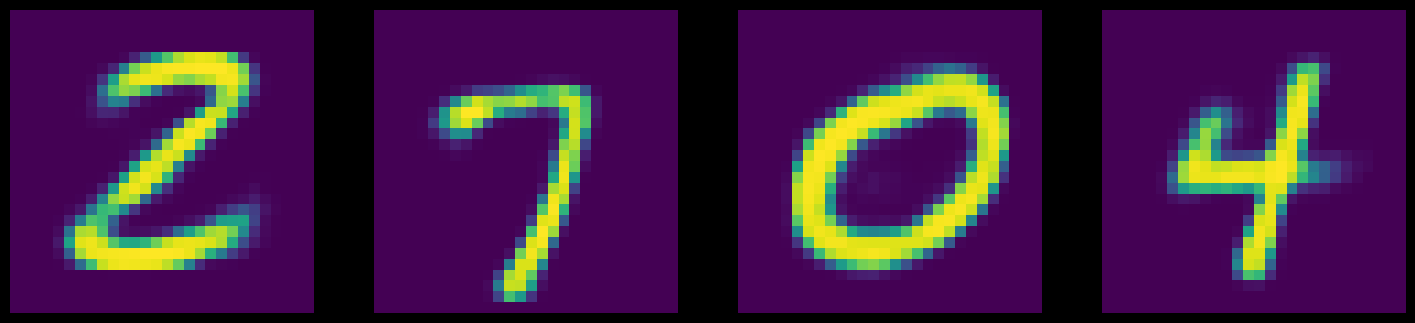

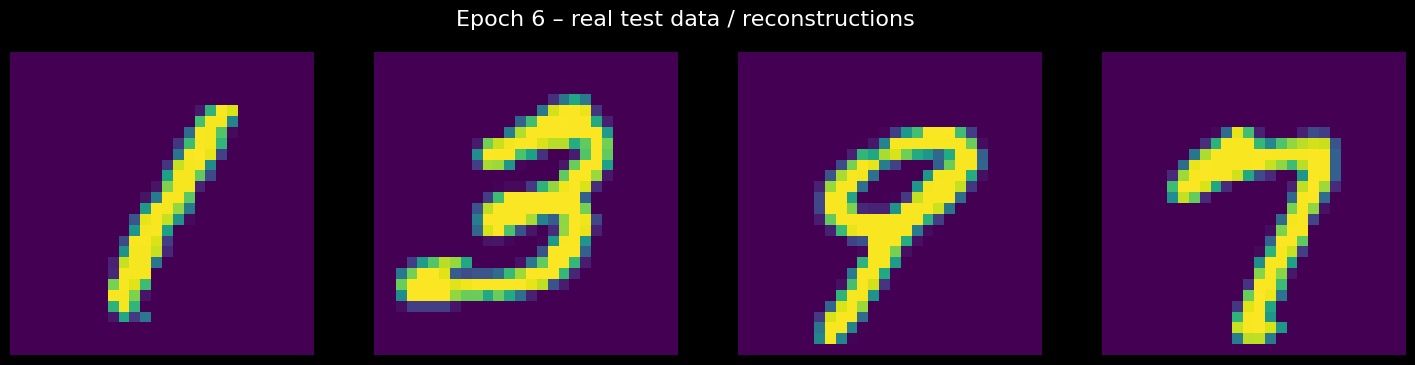

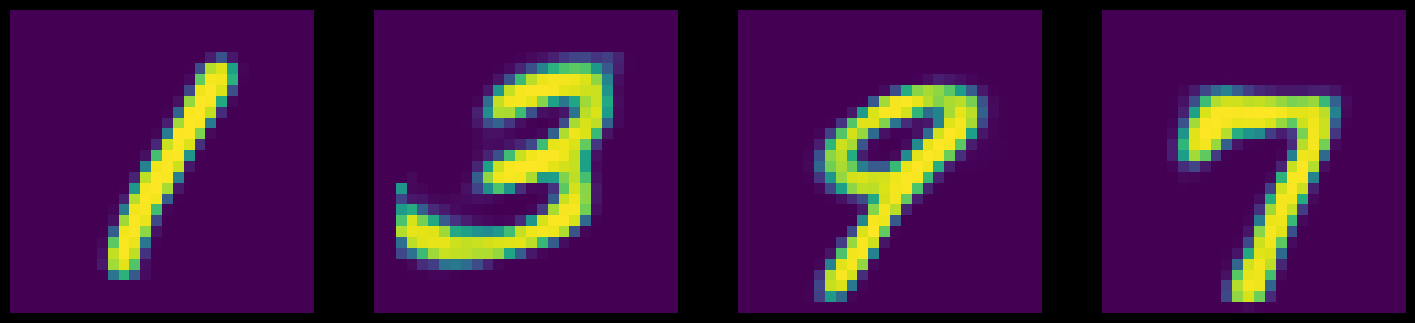

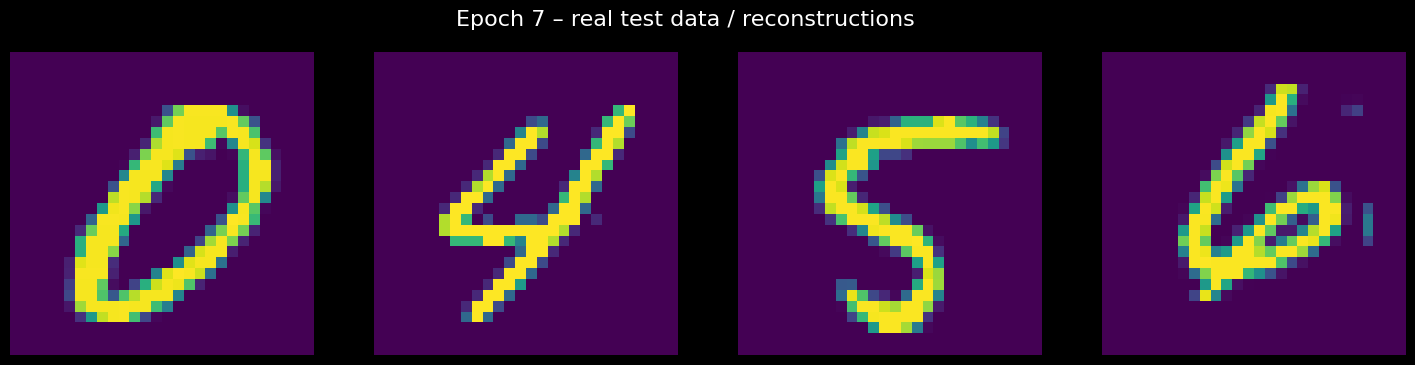

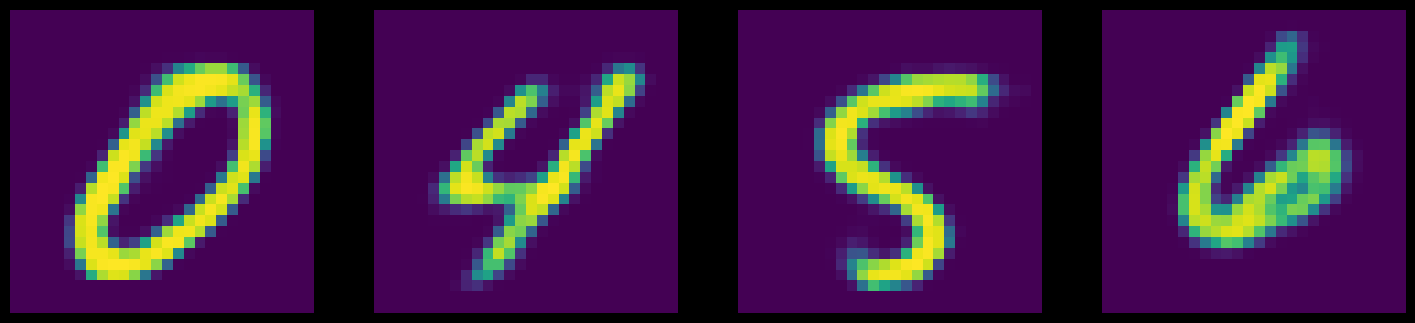

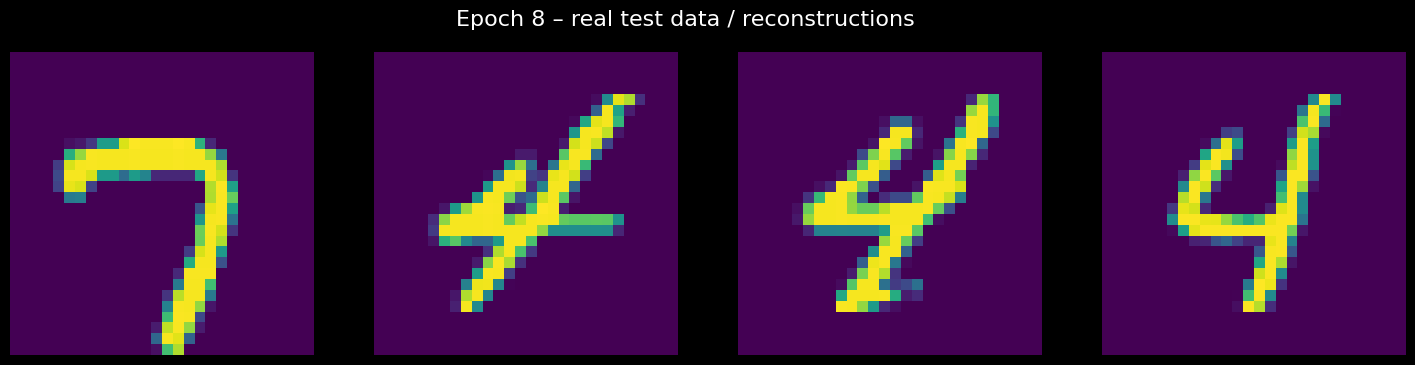

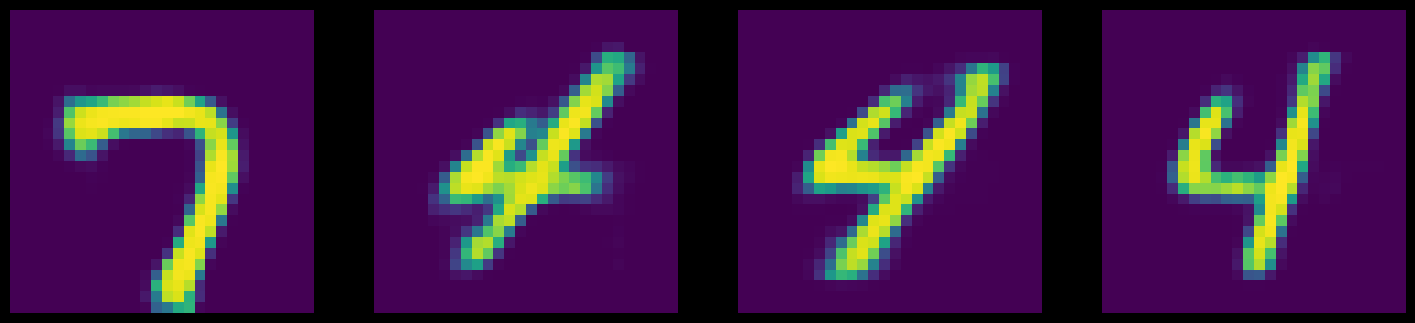

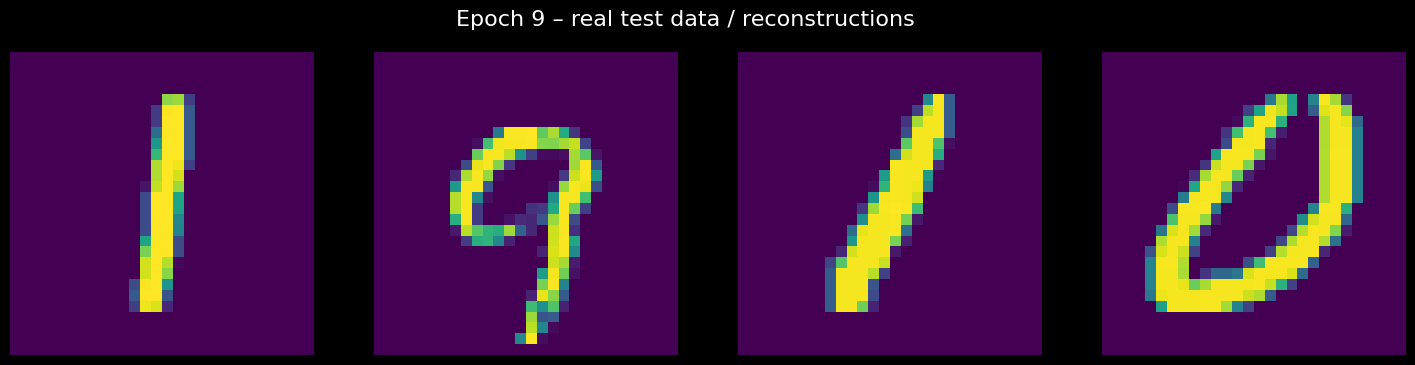

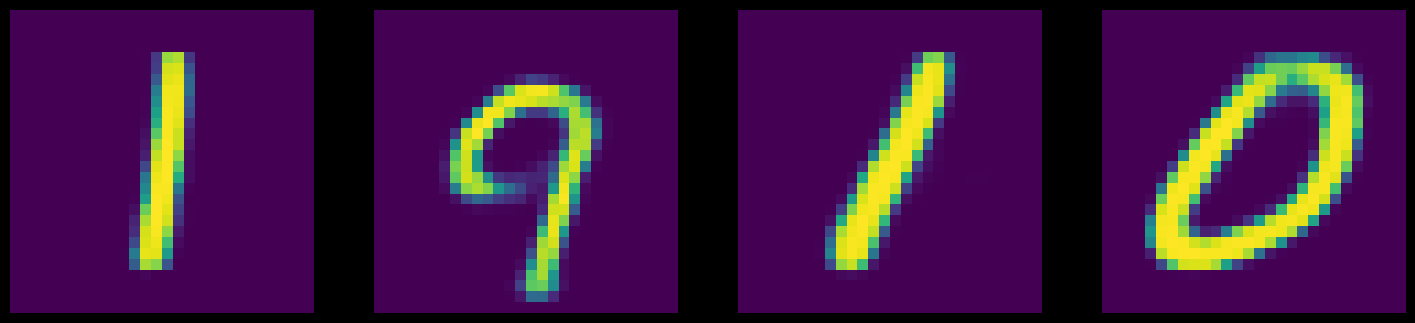

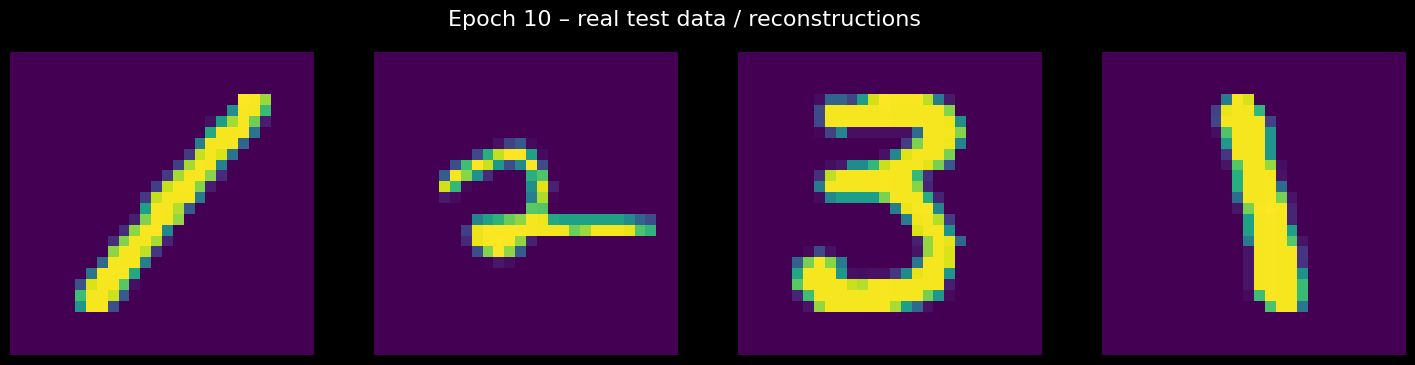

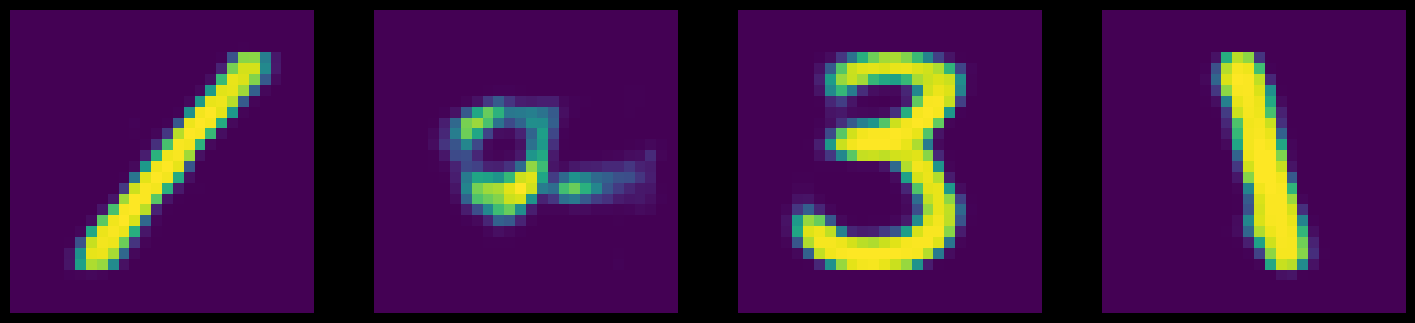

In [23]:
# Test Lion
optimizer = keras.optimizers.Lion(learning_rate=learning_rate)
experiment(optimizer)

Coefficient: 0.5
====> Test set loss: 531.4701


2023-12-17 18:31:08.904918: I external/local_xla/xla/service/service.cc:168] XLA service 0x55a4d99db4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-17 18:31:08.904961: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-17 18:31:08.918169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-17 18:31:08.956253: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1702855868.987732  113733 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


====> Epoch: 1 Average loss: 165.4153
====> Test set loss: 119.8657
====> Epoch: 2 Average loss: 121.2276
====> Test set loss: 104.1259
====> Epoch: 3 Average loss: 110.3205
====> Test set loss: 97.2613
====> Epoch: 4 Average loss: 104.9455
====> Test set loss: 93.8289
====> Epoch: 5 Average loss: 101.7572
====> Test set loss: 91.4164
====> Epoch: 6 Average loss: 99.6807
====> Test set loss: 89.7634
====> Epoch: 7 Average loss: 98.1947
====> Test set loss: 88.7803
====> Epoch: 8 Average loss: 97.0595
====> Test set loss: 87.8576
====> Epoch: 9 Average loss: 96.1794
====> Test set loss: 87.0704
====> Epoch: 10 Average loss: 95.4400
====> Test set loss: 86.8105


/tmp/ipykernel_113733/8802285.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


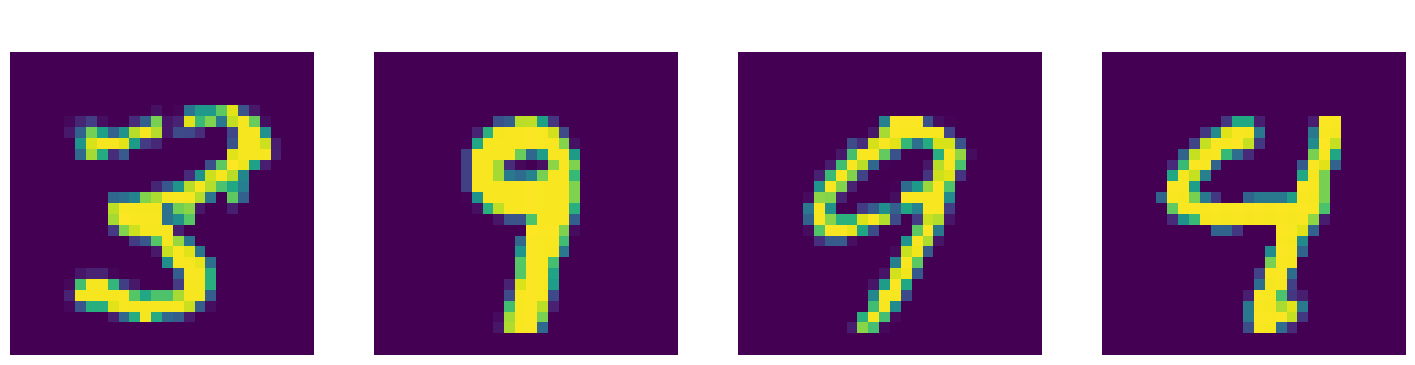

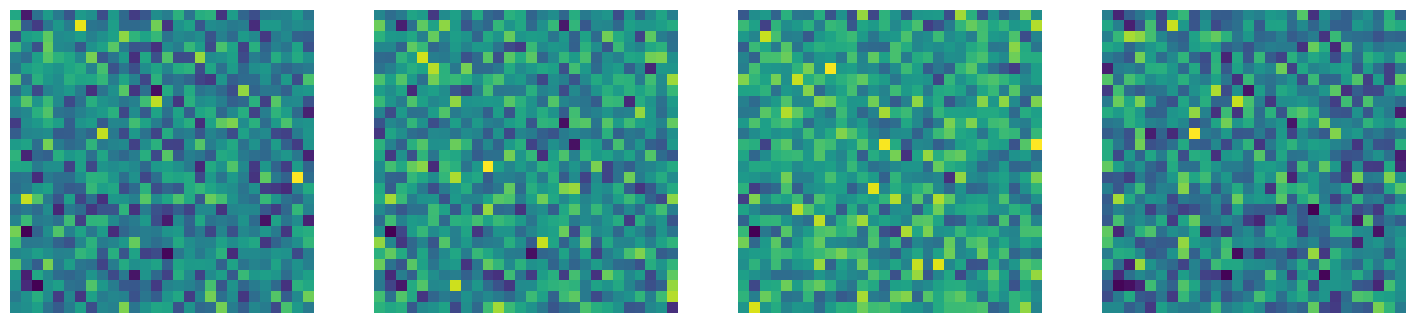

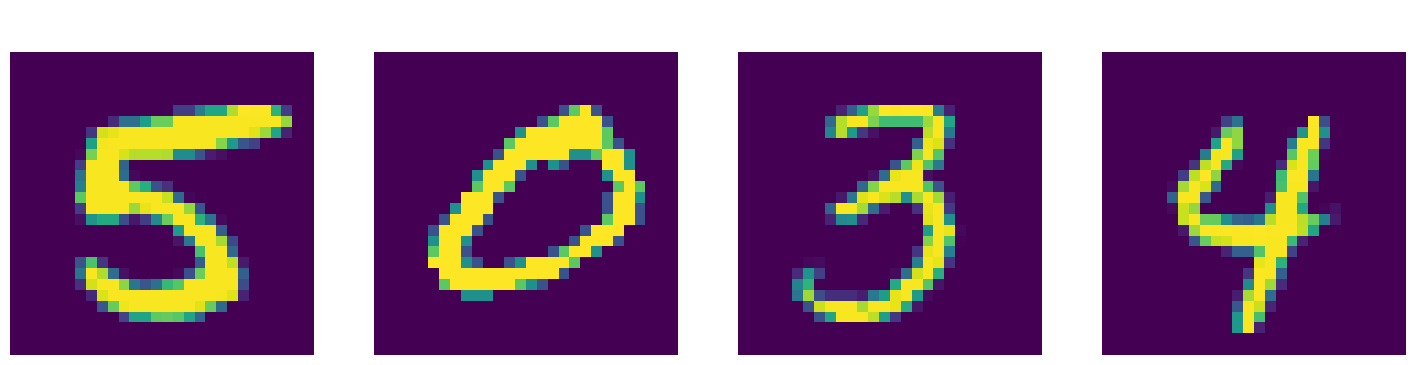

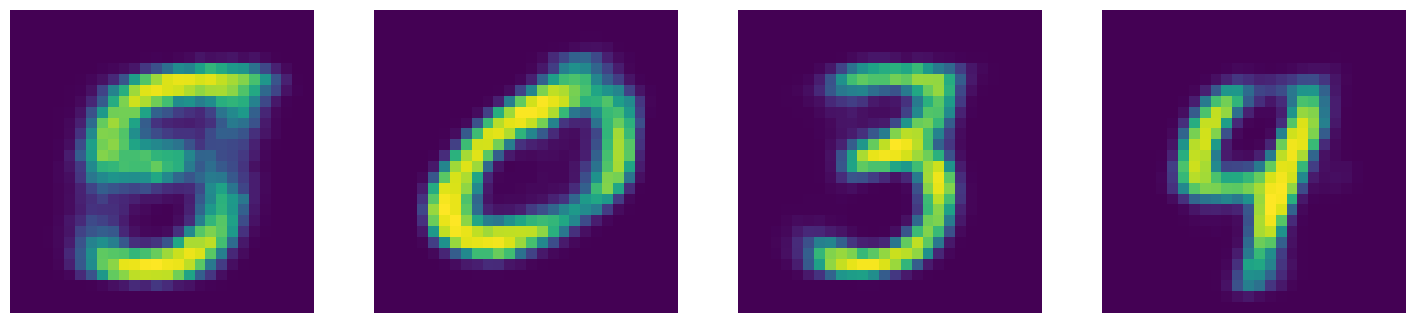

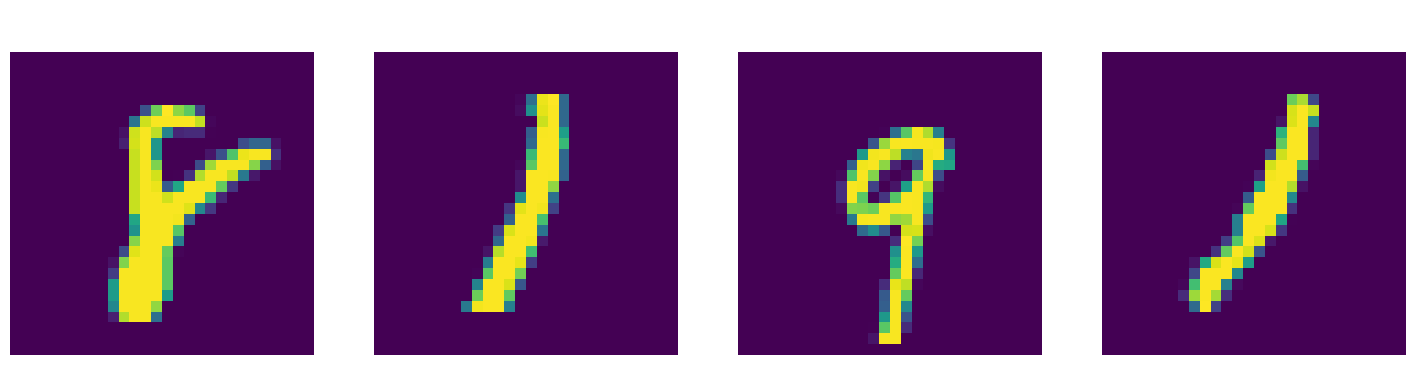

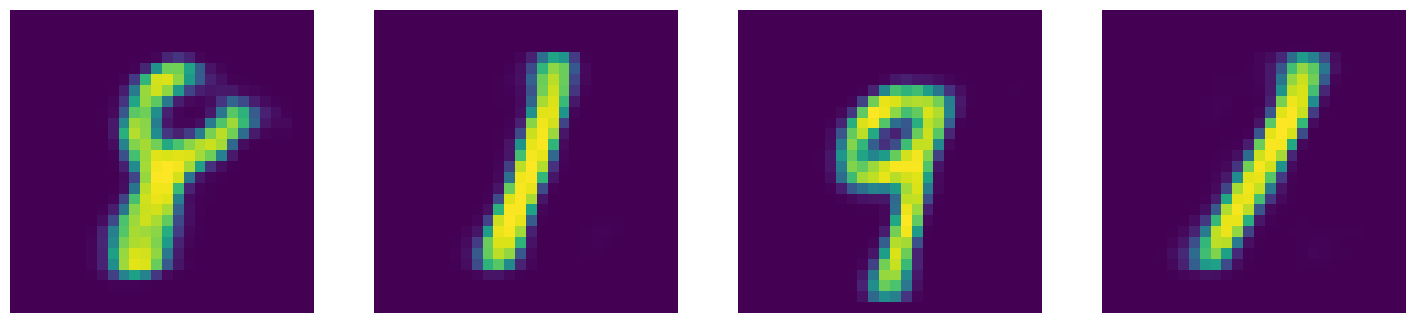

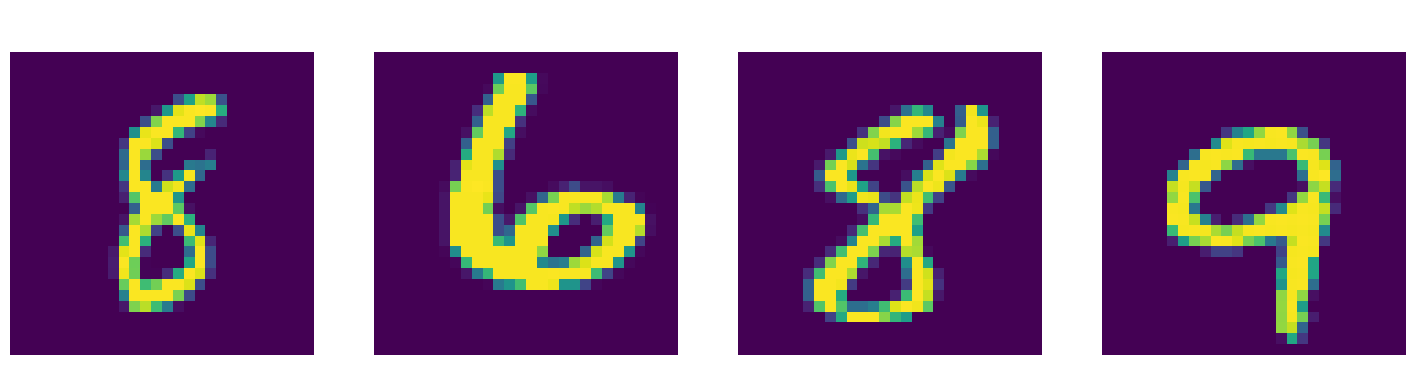

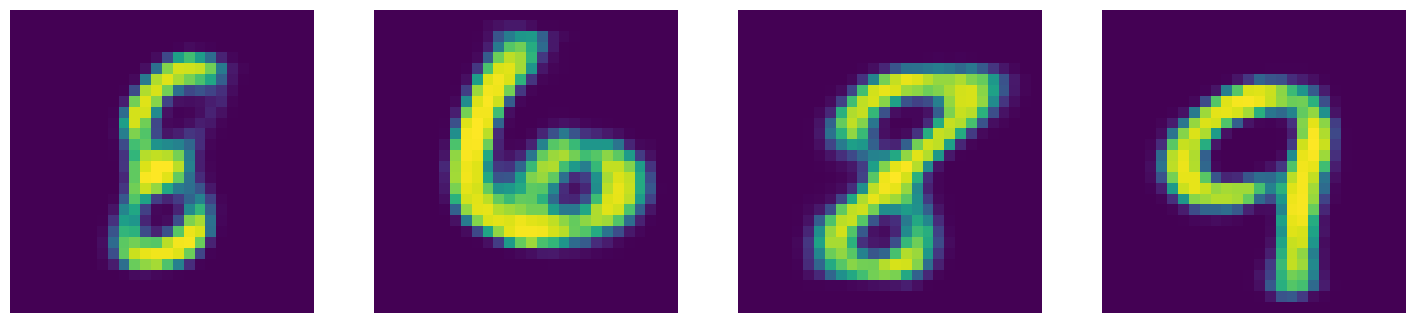

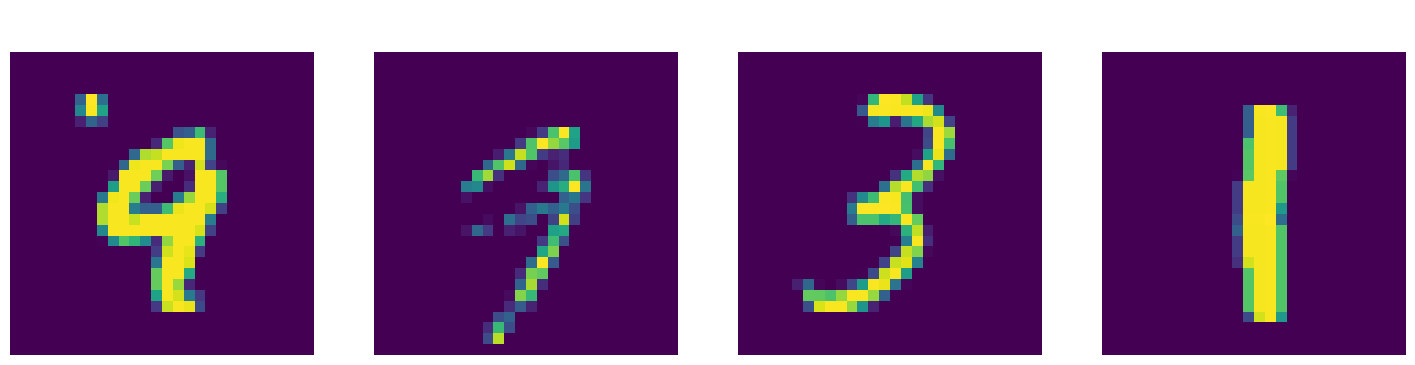

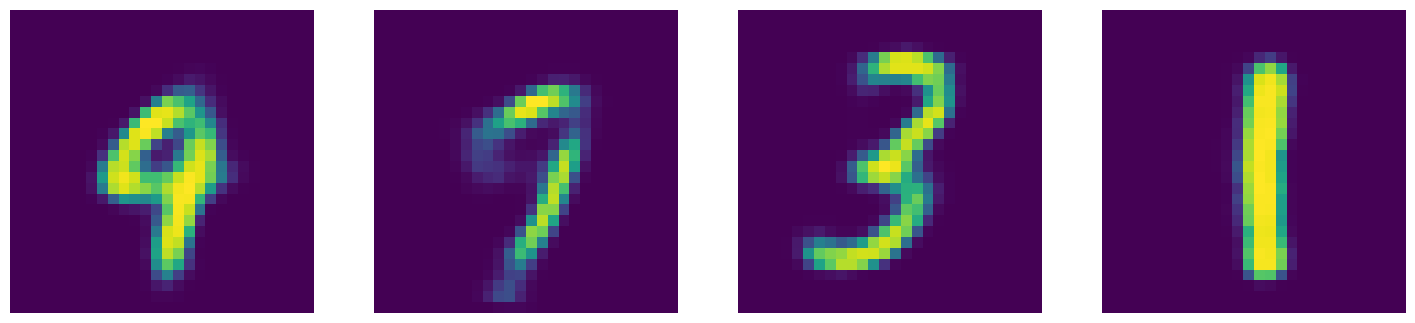

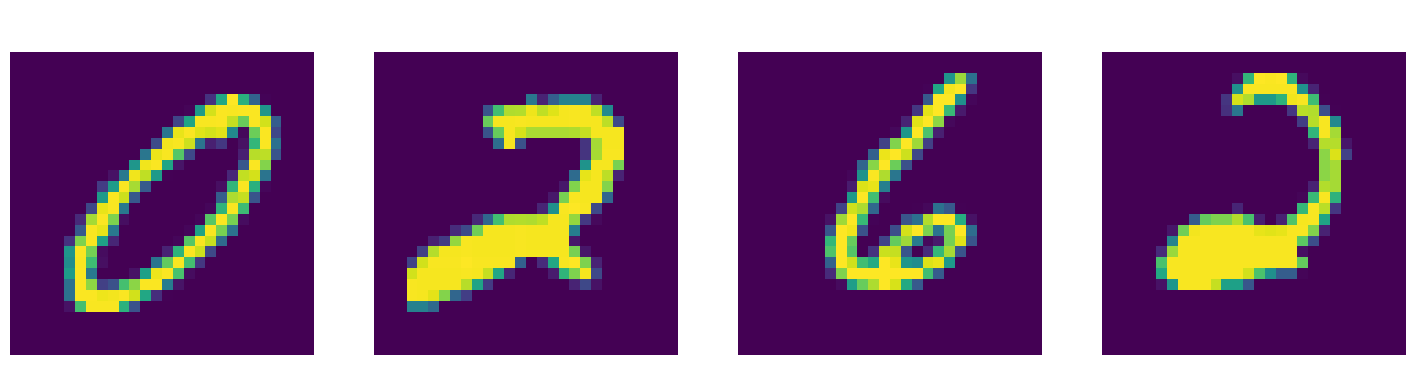

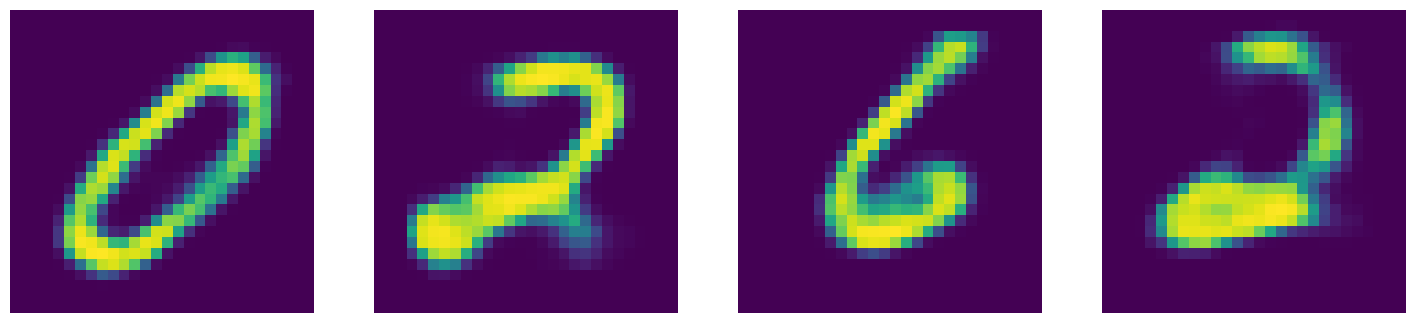

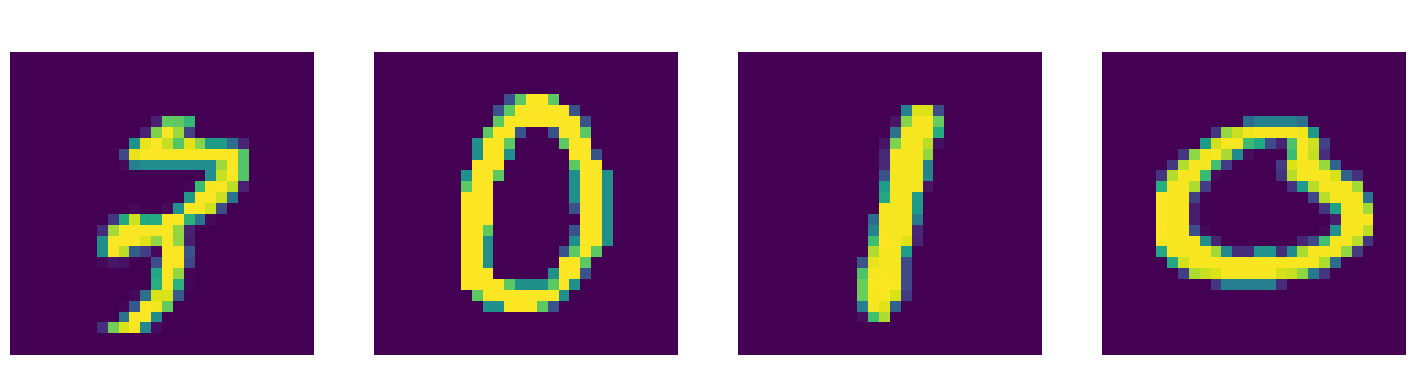

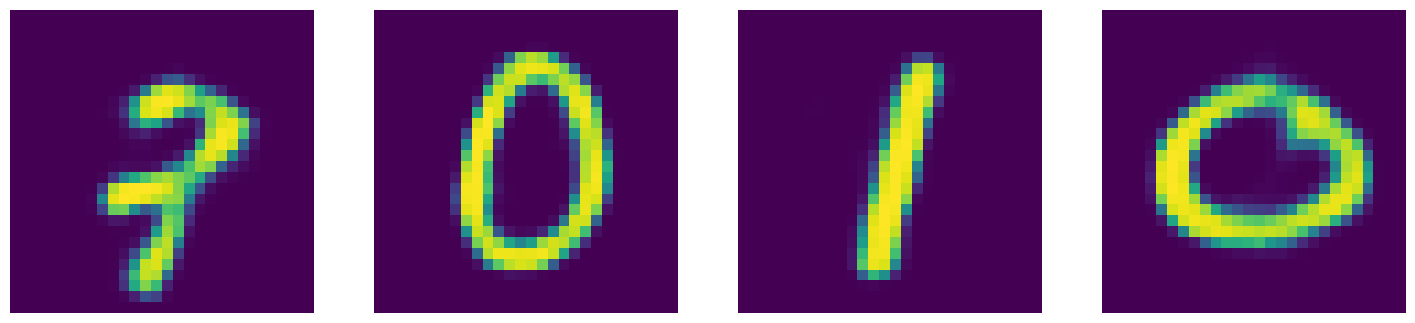

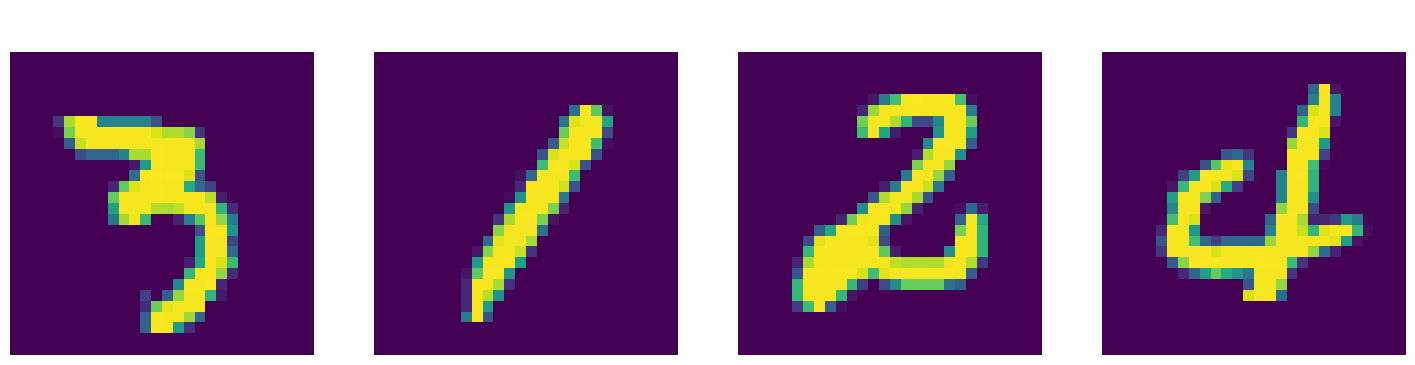

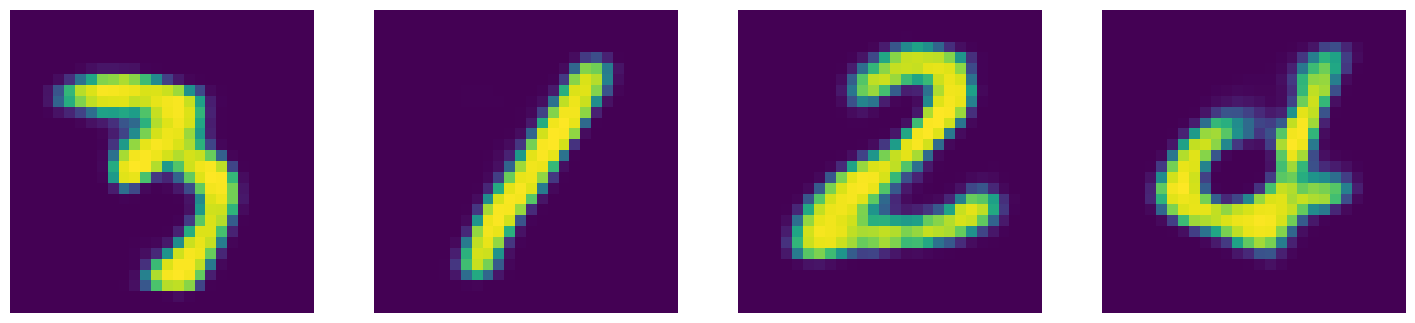

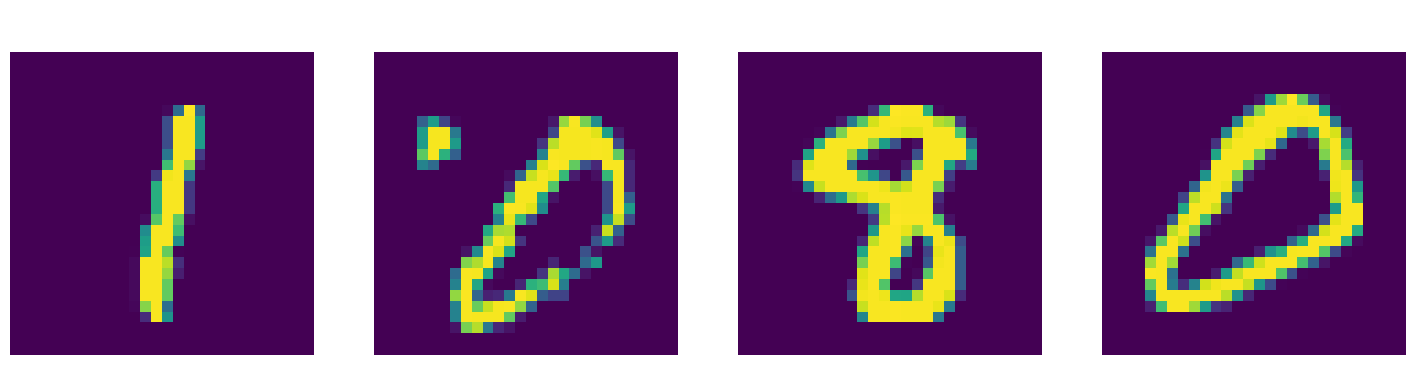

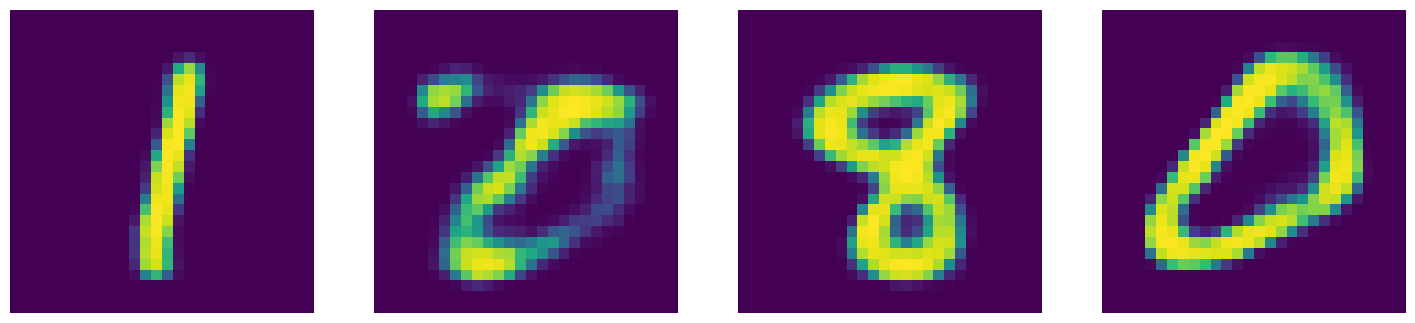

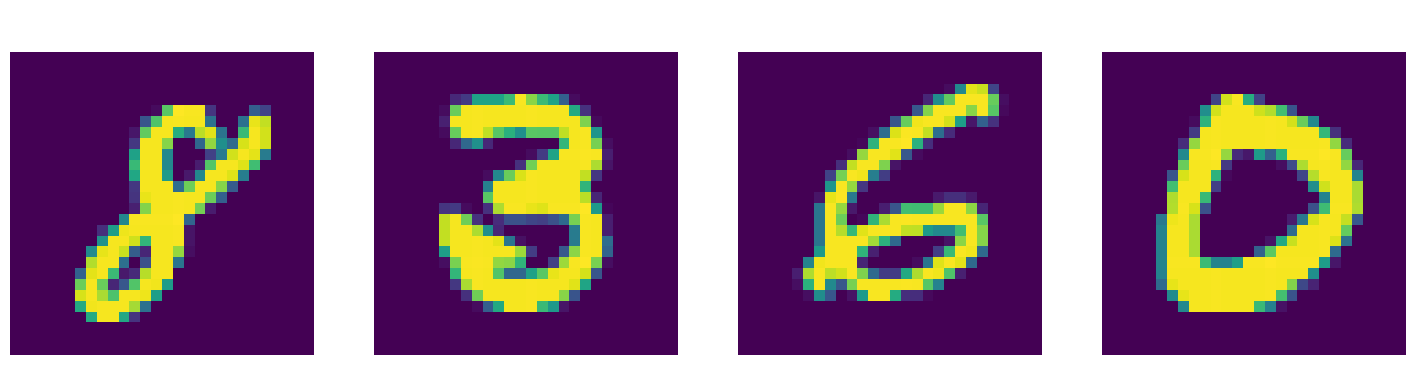

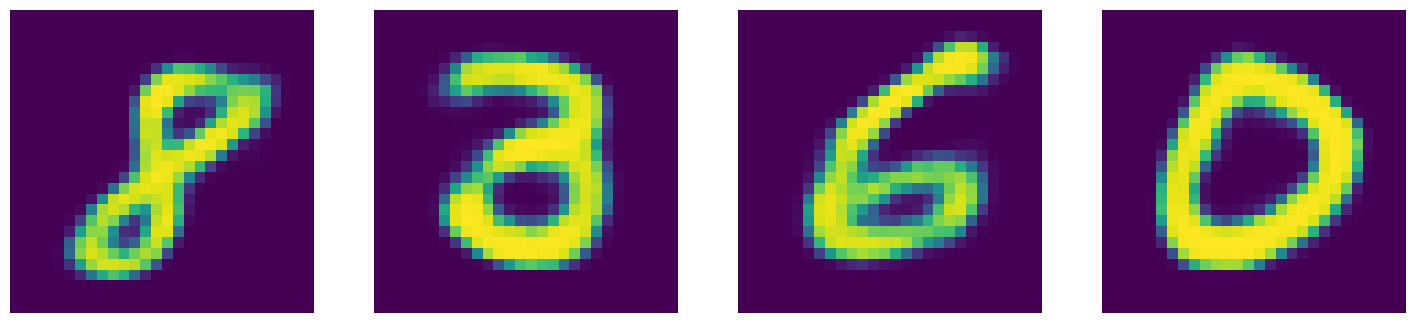

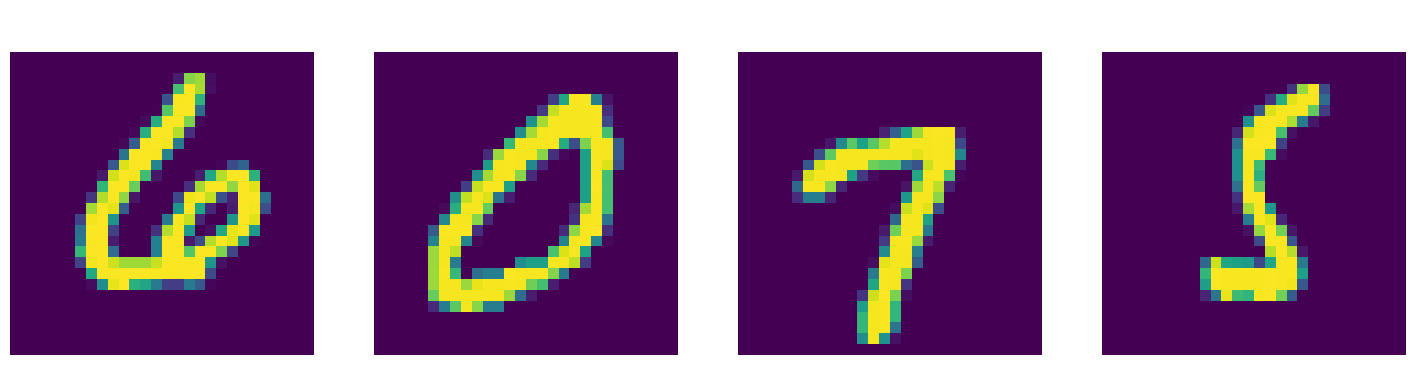

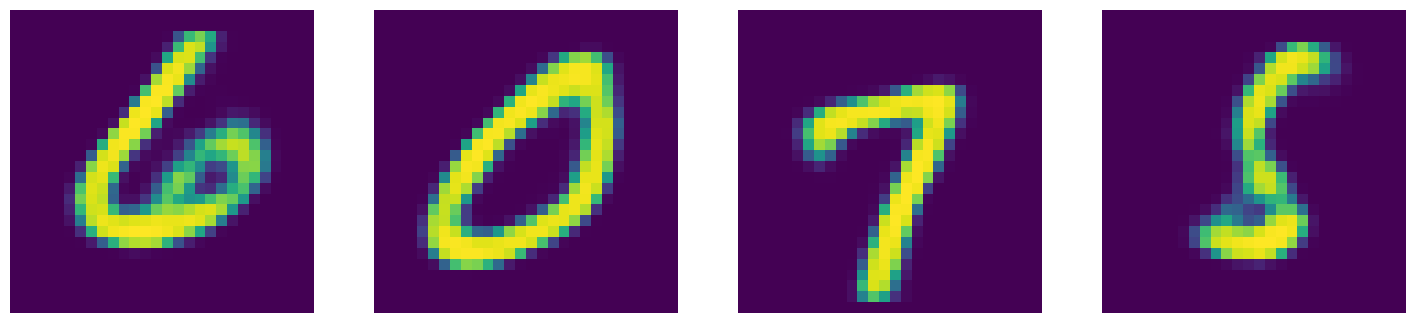

In [11]:
# Test RMSprop
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
experiment(optimizer)

#### Modify coefficient

In [12]:
# Test a range of coefficients from 0.1 to 5 using step 0.1
coeff_range = np.arange(0.1, 5.1, 0.1)

for coeff in coeff_range:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    experiment(optimizer, coeff, False)

Coefficient: 0.1
====> Test set loss: 531.4406
====> Epoch: 1 Average loss: 165.3679
====> Test set loss: 107.1014
====> Epoch: 2 Average loss: 101.0382
====> Test set loss: 91.0461
====> Epoch: 3 Average loss: 91.5351
====> Test set loss: 85.3779
====> Epoch: 4 Average loss: 86.9506
====> Test set loss: 81.8416
====> Epoch: 5 Average loss: 84.0607
====> Test set loss: 79.5889
====> Epoch: 6 Average loss: 82.0452
====> Test set loss: 78.1685
====> Epoch: 7 Average loss: 80.4926
====> Test set loss: 76.6873
====> Epoch: 8 Average loss: 79.3018
====> Test set loss: 75.6307
====> Epoch: 9 Average loss: 78.3334
====> Test set loss: 74.8794
====> Epoch: 10 Average loss: 77.5693
====> Test set loss: 74.3500
Coefficient: 0.2
====> Test set loss: 532.0950
====> Epoch: 1 Average loss: 170.5951
====> Test set loss: 112.3402
====> Epoch: 2 Average loss: 106.3045
====> Test set loss: 94.3381
====> Epoch: 3 Average loss: 96.2290
====> Test set loss: 88.9030
====> Epoch: 4 Average loss: 91.8310
====